### Завантаження датасетів та функція для тренування моделі

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import json
import warnings
import time
from tqdm import tqdm
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import RandomOverSampler

In [4]:
df_train_fe_0 = pd.read_parquet('/kaggle/input/other-datasets/df_train_fe', engine='pyarrow')
df_train_bnum_0 = pd.read_parquet('/kaggle/input/other-datasets/df_train_bnum', engine='pyarrow')
df_train_dpi_0 = pd.read_parquet('/kaggle/input/other-datasets/df_train_dpi', engine='pyarrow')

In [5]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, recall_score, confusion_matrix, 
    classification_report, roc_curve, precision_recall_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Функція для тренування моделі та обчислення метрик
def train_and_evaluate(model, X_train, X_val, y_train, y_val, model_name):
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train
        
    start_val = time.time()
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    end_val = time.time()
    val_time = end_val - start_val
    
    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    val_auc = roc_auc_score(y_val, y_val_pred_prob)
    auc_diff = train_auc - val_auc
    y_val_pred = model.predict(X_val)
    recall = recall_score(y_val, y_val_pred)
    cm = confusion_matrix(y_val, y_val_pred)
    fp_tp_ratio = cm[0, 1] / cm[1, 1] if cm[1, 1] != 0 else float('inf')
    
    return {
        'train_auc': train_auc,
        'val_auc': val_auc,
        'auc_diff': auc_diff,
        'recall': recall,
        'fp_tp_ratio': fp_tp_ratio,
        'train_time': train_time,
        'val_time': val_time
    }


### Оригінальний датасет без неінформативних ознак

In [94]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)

def find_all_empty_features(df, df_name):
    empty_features = [col for col in df.columns if df[col].isna().all()]
#    print(f"Ознаки з усіма порожніми значеннями у {df_name}:")
#    print(empty_features)
    return empty_features

empty_features_train = find_all_empty_features(df_train_fe, 'df_train_fe')
df_train_fe.drop(columns=empty_features_train, inplace=True)

single_unique_no_missing_columns = [col for col in df_train_fe.columns if df_train_fe[col].nunique() == 1 and df_train_fe[col].isna().sum() == 0]
df_train_fe.drop(columns=single_unique_no_missing_columns, inplace=True)
# print(f"Ознаки з 1 унікальним значенням та без порожніх значень:")
# print(single_unique_no_missing_columns)

df_train_fe.drop("MV_FRAUD_BLOCK", axis=1, inplace=True)
df_train_fe.drop("entertainment", axis=1, inplace=True)

In [95]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = 'Original'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.955721,0.901549,0.054172,0.782946,2.492409,75.862342,2.902722,Original


### Оригінальний датасет без неінформативних ознак плюс 5 нових ознак з датасету DPI

In [96]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [97]:
# DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI 
# Нові ознаки 5 - кількість застосунків та суми всіх метрик по всіх застосунках

agg_functions = {
    'Application': pd.Series.nunique,  # кількість різних значень ознаки Application
    'SUM_of_Duration_sec': 'sum',      # сума всіх значень ознаки SUM_of_Duration_sec
    'SUM_of_Volume_kb': 'sum',         # сума всіх значень ознаки SUM_of_Volume_kb
    'SUM_of_Count_events': 'sum',      # сума всіх значень ознаки SUM_of_Count_events
    'MAX_of_day_cnt': 'sum'            # сума всіх значень ознаки MAX_of_day_cnt
}

def create_features(df_dpi, df_fe):
    aggregated = df_dpi.groupby('abon_id').agg(agg_functions).reset_index()
    aggregated.columns = ['abon_id', 'unique_applications', 'total_duration_sec', 'total_volume_kb', 'total_count_events', 'total_day_count']
    df_fe = df_fe.merge(aggregated, on='abon_id', how='left')
    return df_fe

df_train_fe = create_features(df_train_dpi, df_train_fe)

print(df_train_fe.head())

   Ama_rchrgmnt_sum_max_mnt1  content_clc_mea_mnt1  content_cnt_max_mnt1  \
0                          0                   0.0             13.841608   
1                          0                   0.0             11.361162   
2                          0                   0.0             10.269117   
3                          0                   0.0              9.974412   
4                          0                   0.0              6.749902   

   voice_out_short_part_max_mnt1  voice_mts_in_nrest_part_std_mnt1  \
0                       1.480453                          0.000000   
1                       1.000313                          1.000007   
2                       0.000000                          0.000000   
3                       1.033241                          1.000128   
4                       1.000641                          1.000548   

   num_act_days_max_mnt1  sms_roam_clc_min_mnt1  \
0               5.324077                      0   
1               5.32

In [98]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)

def find_all_empty_features(df, df_name):
    empty_features = [col for col in df.columns if df[col].isna().all()]
#    print(f"Ознаки з усіма порожніми значеннями у {df_name}:")
#    print(empty_features)
    return empty_features

empty_features_train = find_all_empty_features(df_train_fe, 'df_train_fe')
df_train_fe.drop(columns=empty_features_train, inplace=True)

single_unique_no_missing_columns = [col for col in df_train_fe.columns if df_train_fe[col].nunique() == 1 and df_train_fe[col].isna().sum() == 0]
df_train_fe.drop(columns=single_unique_no_missing_columns, inplace=True)
# print(f"Ознаки з 1 унікальним значенням та без порожніх значень:")
# print(single_unique_no_missing_columns)

df_train_fe.drop("MV_FRAUD_BLOCK", axis=1, inplace=True)
df_train_fe.drop("entertainment", axis=1, inplace=True)

In [99]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '+5 DPI'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.955914,0.901064,0.05485,0.786047,2.464168,76.43042,3.30685,+5 DPI


### Оригінальний датасет без неінформативних ознак плюс 2500 нових ознак з датасету BNUM

In [100]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [101]:
# BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM 
# + 2500 нових ознак
values_to_remove = ['cyberpolice',
'cyberpolic',
'ukraine',
'taxi-838',
'icu',
'dsns ukr',
]

df_train_bnum = df_train_bnum[~df_train_bnum['bnum'].isin(values_to_remove)]

# Видалення спостережень з df_train_bnum, де для одного abon_id менше ніж 50 унікальних значень bnum
abon_id_counts = df_train_bnum.groupby('abon_id')['bnum'].nunique()
valid_abon_ids = abon_id_counts[abon_id_counts >= 50].index
df_train_bnum_filtered = df_train_bnum[df_train_bnum['abon_id'].isin(valid_abon_ids)]

def create_bnum_features(df_bnum, df_fe):

    df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
    df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
    df_bnum['cnt_sms_total'] = df_bnum['cnt_sms_out'] + df_bnum['cnt_sms_in']
    
    grouped = df_bnum.groupby(['abon_id', 'bnum']).agg({
        'call_cnt_total': 'sum',
        'call_dur_total': 'sum',
        'cnt_sms_total': 'sum'
    }).reset_index()
    
    pivot_df = grouped.pivot(index='abon_id', columns='bnum', values=['call_cnt_total', 'call_dur_total', 'cnt_sms_total'])
    pivot_df.columns = [f'{metric}_{bnum}' for metric, bnum in pivot_df.columns]
    
    df_fe = df_fe.merge(pivot_df, on='abon_id', how='left')
    
    return df_fe

df_train_fe = create_bnum_features(df_train_bnum_filtered, df_train_fe)
print(df_train_fe.head())

/tmp/ipykernel_33/1906798896.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
/tmp/ipykernel_33/1906798896.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
/tmp/ipykernel_33/1906798896.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

   Ama_rchrgmnt_sum_max_mnt1  content_clc_mea_mnt1  content_cnt_max_mnt1  \
0                          0                   0.0             13.841608   
1                          0                   0.0             11.361162   
2                          0                   0.0             10.269117   
3                          0                   0.0              9.974412   
4                          0                   0.0              6.749902   

   voice_out_short_part_max_mnt1  voice_mts_in_nrest_part_std_mnt1  \
0                       1.480453                          0.000000   
1                       1.000313                          1.000007   
2                       0.000000                          0.000000   
3                       1.033241                          1.000128   
4                       1.000641                          1.000548   

   num_act_days_max_mnt1  sms_roam_clc_min_mnt1  \
0               5.324077                      0   
1               5.32

In [102]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)

def find_all_empty_features(df, df_name):
    empty_features = [col for col in df.columns if df[col].isna().all()]
#    print(f"Ознаки з усіма порожніми значеннями у {df_name}:")
#    print(empty_features)
    return empty_features

empty_features_train = find_all_empty_features(df_train_fe, 'df_train_fe')
df_train_fe.drop(columns=empty_features_train, inplace=True)

single_unique_no_missing_columns = [col for col in df_train_fe.columns if df_train_fe[col].nunique() == 1 and df_train_fe[col].isna().sum() == 0]
df_train_fe.drop(columns=single_unique_no_missing_columns, inplace=True)
# print(f"Ознаки з 1 унікальним значенням та без порожніх значень:")
# print(single_unique_no_missing_columns)

df_train_fe.drop("MV_FRAUD_BLOCK", axis=1, inplace=True)
df_train_fe.drop("entertainment", axis=1, inplace=True)

In [103]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '+2500 BNUM'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.955721,0.901549,0.054172,0.782946,2.492409,95.687021,8.968817,+2500 BNUM


### Оригінальний датасет без неінформативних ознак плюс 600 нових ознак з датасету DPI

In [104]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [105]:
# # DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI 
# # Нові фічі 2500+: кількість взаємодії з кожним застосунком усі метрики (600 ознак на кожну)

def create_application_features(df_dpi, df_fe):
    #pivot_count = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Count_events', aggfunc='sum', fill_value=0).reset_index()
    pivot_duration = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Duration_sec', aggfunc='sum', fill_value=0).reset_index()
    #pivot_volume = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Volume_kb', aggfunc='sum', fill_value=0).reset_index()
    #pivot_day_cnt = df_dpi.pivot_table(index='abon_id', columns='Application', values='MAX_of_day_cnt', aggfunc='max', fill_value=0).reset_index()
    
    #pivot_count = pivot_count.add_suffix('_count')
    pivot_duration = pivot_duration.add_suffix('_duration')
    #pivot_volume = pivot_volume.add_suffix('_volume')
    #pivot_day_cnt = pivot_day_cnt.add_suffix('_day_cnt')
    
    #pivot_count.rename(columns={'abon_id_count': 'abon_id'}, inplace=True)
    pivot_duration.rename(columns={'abon_id_duration': 'abon_id'}, inplace=True)
    #pivot_volume.rename(columns={'abon_id_volume': 'abon_id'}, inplace=True)
    #pivot_day_cnt.rename(columns={'abon_id_day_cnt': 'abon_id'}, inplace=True)
    
    #df_fe = df_fe.merge(pivot_count, on='abon_id', how='left')
    df_fe = df_fe.merge(pivot_duration, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_volume, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_day_cnt, on='abon_id', how='left')
    
    df_fe.fillna(0, inplace=True)
    
    return df_fe

df_train_fe = create_application_features(df_train_dpi, df_train_fe)

print(df_train_fe.head())


   Ama_rchrgmnt_sum_max_mnt1  content_clc_mea_mnt1  content_cnt_max_mnt1  \
0                          0                   0.0             13.841608   
1                          0                   0.0             11.361162   
2                          0                   0.0             10.269117   
3                          0                   0.0              9.974412   
4                          0                   0.0              6.749902   

   voice_out_short_part_max_mnt1  voice_mts_in_nrest_part_std_mnt1  \
0                       1.480453                          0.000000   
1                       1.000313                          1.000007   
2                       0.000000                          0.000000   
3                       1.033241                          1.000128   
4                       1.000641                          1.000548   

   num_act_days_max_mnt1  sms_roam_clc_min_mnt1  \
0               5.324077                      0   
1               5.32

In [106]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)

def find_all_empty_features(df, df_name):
    empty_features = [col for col in df.columns if df[col].isna().all()]
#    print(f"Ознаки з усіма порожніми значеннями у {df_name}:")
#    print(empty_features)
    return empty_features

empty_features_train = find_all_empty_features(df_train_fe, 'df_train_fe')
df_train_fe.drop(columns=empty_features_train, inplace=True)

single_unique_no_missing_columns = [col for col in df_train_fe.columns if df_train_fe[col].nunique() == 1 and df_train_fe[col].isna().sum() == 0]
df_train_fe.drop(columns=single_unique_no_missing_columns, inplace=True)
# print(f"Ознаки з 1 унікальним значенням та без порожніх значень:")
# print(single_unique_no_missing_columns)

df_train_fe.drop("MV_FRAUD_BLOCK", axis=1, inplace=True)
df_train_fe.drop("entertainment", axis=1, inplace=True)

In [107]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '+600 DPI'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.9565,0.90212,0.05438,0.786563,2.446124,89.313191,4.420897,+600 DPI


### Оригінальний датасет без неінформативних ознак плюс 600 нових ознак з датасету DPI та 2500 з датасету BNUM

In [108]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [109]:
# BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM 
# + 2500 нових ознак
values_to_remove = ['cyberpolice',
'cyberpolic',
'ukraine',
'taxi-838',
'icu',
'dsns ukr',
]

df_train_bnum = df_train_bnum[~df_train_bnum['bnum'].isin(values_to_remove)]

# Видалення спостережень з df_train_bnum, де для одного abon_id менше ніж 50 унікальних значень bnum
abon_id_counts = df_train_bnum.groupby('abon_id')['bnum'].nunique()
valid_abon_ids = abon_id_counts[abon_id_counts >= 50].index
df_train_bnum_filtered = df_train_bnum[df_train_bnum['abon_id'].isin(valid_abon_ids)]

def create_bnum_features(df_bnum, df_fe):

    df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
    df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
    df_bnum['cnt_sms_total'] = df_bnum['cnt_sms_out'] + df_bnum['cnt_sms_in']
    
    grouped = df_bnum.groupby(['abon_id', 'bnum']).agg({
        'call_cnt_total': 'sum',
        'call_dur_total': 'sum',
        'cnt_sms_total': 'sum'
    }).reset_index()
    
    pivot_df = grouped.pivot(index='abon_id', columns='bnum', values=['call_cnt_total', 'call_dur_total', 'cnt_sms_total'])
    pivot_df.columns = [f'{metric}_{bnum}' for metric, bnum in pivot_df.columns]
    
    df_fe = df_fe.merge(pivot_df, on='abon_id', how='left')
    
    return df_fe

df_train_fe = create_bnum_features(df_train_bnum_filtered, df_train_fe)
print(df_train_fe.head())

/tmp/ipykernel_33/1906798896.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
/tmp/ipykernel_33/1906798896.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
/tmp/ipykernel_33/1906798896.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

   Ama_rchrgmnt_sum_max_mnt1  content_clc_mea_mnt1  content_cnt_max_mnt1  \
0                          0                   0.0             13.841608   
1                          0                   0.0             11.361162   
2                          0                   0.0             10.269117   
3                          0                   0.0              9.974412   
4                          0                   0.0              6.749902   

   voice_out_short_part_max_mnt1  voice_mts_in_nrest_part_std_mnt1  \
0                       1.480453                          0.000000   
1                       1.000313                          1.000007   
2                       0.000000                          0.000000   
3                       1.033241                          1.000128   
4                       1.000641                          1.000548   

   num_act_days_max_mnt1  sms_roam_clc_min_mnt1  \
0               5.324077                      0   
1               5.32

In [110]:
# # DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI 
# # Нові фічі 2500+: кількість взаємодії з кожним застосунком усі метрики (600 ознак на кожну)

def create_application_features(df_dpi, df_fe):
    #pivot_count = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Count_events', aggfunc='sum', fill_value=0).reset_index()
    pivot_duration = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Duration_sec', aggfunc='sum', fill_value=0).reset_index()
    #pivot_volume = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Volume_kb', aggfunc='sum', fill_value=0).reset_index()
    #pivot_day_cnt = df_dpi.pivot_table(index='abon_id', columns='Application', values='MAX_of_day_cnt', aggfunc='max', fill_value=0).reset_index()
    
    #pivot_count = pivot_count.add_suffix('_count')
    pivot_duration = pivot_duration.add_suffix('_duration')
    #pivot_volume = pivot_volume.add_suffix('_volume')
    #pivot_day_cnt = pivot_day_cnt.add_suffix('_day_cnt')
    
    #pivot_count.rename(columns={'abon_id_count': 'abon_id'}, inplace=True)
    pivot_duration.rename(columns={'abon_id_duration': 'abon_id'}, inplace=True)
    #pivot_volume.rename(columns={'abon_id_volume': 'abon_id'}, inplace=True)
    #pivot_day_cnt.rename(columns={'abon_id_day_cnt': 'abon_id'}, inplace=True)
    
    #df_fe = df_fe.merge(pivot_count, on='abon_id', how='left')
    df_fe = df_fe.merge(pivot_duration, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_volume, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_day_cnt, on='abon_id', how='left')
    
    df_fe.fillna(0, inplace=True)
    
    return df_fe

df_train_fe = create_application_features(df_train_dpi, df_train_fe)

print(df_train_fe.head())


   Ama_rchrgmnt_sum_max_mnt1  content_clc_mea_mnt1  content_cnt_max_mnt1  \
0                          0                   0.0             13.841608   
1                          0                   0.0             11.361162   
2                          0                   0.0             10.269117   
3                          0                   0.0              9.974412   
4                          0                   0.0              6.749902   

   voice_out_short_part_max_mnt1  voice_mts_in_nrest_part_std_mnt1  \
0                       1.480453                          0.000000   
1                       1.000313                          1.000007   
2                       0.000000                          0.000000   
3                       1.033241                          1.000128   
4                       1.000641                          1.000548   

   num_act_days_max_mnt1  sms_roam_clc_min_mnt1  \
0               5.324077                      0   
1               5.32

In [111]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)

def find_all_empty_features(df, df_name):
    empty_features = [col for col in df.columns if df[col].isna().all()]
#    print(f"Ознаки з усіма порожніми значеннями у {df_name}:")
#    print(empty_features)
    return empty_features

empty_features_train = find_all_empty_features(df_train_fe, 'df_train_fe')
df_train_fe.drop(columns=empty_features_train, inplace=True)

single_unique_no_missing_columns = [col for col in df_train_fe.columns if df_train_fe[col].nunique() == 1 and df_train_fe[col].isna().sum() == 0]
df_train_fe.drop(columns=single_unique_no_missing_columns, inplace=True)
# print(f"Ознаки з 1 унікальним значенням та без порожніх значень:")
# print(single_unique_no_missing_columns)

df_train_fe.drop("MV_FRAUD_BLOCK", axis=1, inplace=True)
df_train_fe.drop("entertainment", axis=1, inplace=True)

In [112]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '+3000 DPI BNUM'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.9565,0.90212,0.05438,0.786563,2.446124,90.923916,6.18774,+3000 DPI BNUM


### 25 найважливіших ознак з оригінального датасету

In [113]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [114]:
features_2_use = ['target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1']

In [115]:
df_train_fe = df_train_fe[features_2_use]

In [116]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = 'Original 25'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.936504,0.896217,0.040287,0.793798,2.768229,4.431842,1.15532,Original 25


### 25 найважливіших ознак з оригінального датасету плюс 5 нових ознак з датасету DPI

In [117]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [118]:
features_2_use = ['abon_id','target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1']

In [119]:
df_train_fe = df_train_fe[features_2_use]

In [120]:
# DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI 
# Нові ознаки 5 - кількість застосунків та суми всіх метрик по всіх застосунках

agg_functions = {
    'Application': pd.Series.nunique,  # кількість різних значень ознаки Application
    'SUM_of_Duration_sec': 'sum',      # сума всіх значень ознаки SUM_of_Duration_sec
    'SUM_of_Volume_kb': 'sum',         # сума всіх значень ознаки SUM_of_Volume_kb
    'SUM_of_Count_events': 'sum',      # сума всіх значень ознаки SUM_of_Count_events
    'MAX_of_day_cnt': 'sum'            # сума всіх значень ознаки MAX_of_day_cnt
}

def create_features(df_dpi, df_fe):
    aggregated = df_dpi.groupby('abon_id').agg(agg_functions).reset_index()
    aggregated.columns = ['abon_id', 'unique_applications', 'total_duration_sec', 'total_volume_kb', 'total_count_events', 'total_day_count']
    df_fe = df_fe.merge(aggregated, on='abon_id', how='left')
    return df_fe

df_train_fe = create_features(df_train_dpi, df_train_fe)

print(df_train_fe.head())

   abon_id  target  num_act_days_min_mnt3  device_days_usage  \
0  1545052       0               1.480453          53.249600   
1  1545235       0               5.324077          47.044200   
2  1549358       0               5.324077          27.615852   
3  1549591       0               4.786566          34.201236   
4  1558772       0               5.324077          50.270526   

   loc_market_share  num_act_days_mea_mnt1  voice_in_td_cnt_mea_mnt1  \
0          1.186492               4.646353                  2.569415   
1          1.186492               5.324077                 15.945794   
2          1.134741               5.324077                  5.193046   
3          1.186492               5.059834                 11.862541   
4          1.186492               5.324077                 11.739678   

   device_brand_prestigio  num_act_days_mea_mnt3        lt  ...  \
0                     0.0               4.693364  6.135202  ...   
1                     0.0               5.324077

In [121]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)


In [122]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '25 +5 DPI'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.938785,0.89588,0.042905,0.795866,2.717532,5.408524,1.209163,25 +5 DPI


### 25 найважливіших ознак з оригінального датасету плюс 2500 нових ознак з датасету BNUM

In [123]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [125]:
features_2_use = ['abon_id','target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1']

In [126]:
df_train_fe = df_train_fe[features_2_use]

In [127]:
# BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM 
# + 2500 нових ознак
values_to_remove = ['cyberpolice',
'cyberpolic',
'ukraine',
'taxi-838',
'icu',
'dsns ukr',
]

df_train_bnum = df_train_bnum[~df_train_bnum['bnum'].isin(values_to_remove)]

# Видалення спостережень з df_train_bnum, де для одного abon_id менше ніж 50 унікальних значень bnum
abon_id_counts = df_train_bnum.groupby('abon_id')['bnum'].nunique()
valid_abon_ids = abon_id_counts[abon_id_counts >= 50].index
df_train_bnum_filtered = df_train_bnum[df_train_bnum['abon_id'].isin(valid_abon_ids)]

def create_bnum_features(df_bnum, df_fe):

    df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
    df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
    df_bnum['cnt_sms_total'] = df_bnum['cnt_sms_out'] + df_bnum['cnt_sms_in']
    
    grouped = df_bnum.groupby(['abon_id', 'bnum']).agg({
        'call_cnt_total': 'sum',
        'call_dur_total': 'sum',
        'cnt_sms_total': 'sum'
    }).reset_index()
    
    pivot_df = grouped.pivot(index='abon_id', columns='bnum', values=['call_cnt_total', 'call_dur_total', 'cnt_sms_total'])
    pivot_df.columns = [f'{metric}_{bnum}' for metric, bnum in pivot_df.columns]
    
    df_fe = df_fe.merge(pivot_df, on='abon_id', how='left')
    
    return df_fe

df_train_fe = create_bnum_features(df_train_bnum_filtered, df_train_fe)
print(df_train_fe.head())

/tmp/ipykernel_33/1906798896.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
/tmp/ipykernel_33/1906798896.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
/tmp/ipykernel_33/1906798896.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

   abon_id  target  num_act_days_min_mnt3  device_days_usage  \
0  1545052       0               1.480453          53.249600   
1  1545235       0               5.324077          47.044200   
2  1549358       0               5.324077          27.615852   
3  1549591       0               4.786566          34.201236   
4  1558772       0               5.324077          50.270526   

   loc_market_share  num_act_days_mea_mnt1  voice_in_td_cnt_mea_mnt1  \
0          1.186492               4.646353                  2.569415   
1          1.186492               5.324077                 15.945794   
2          1.134741               5.324077                  5.193046   
3          1.186492               5.059834                 11.862541   
4          1.186492               5.324077                 11.739678   

   device_brand_prestigio  num_act_days_mea_mnt3        lt  ...  \
0                     0.0               4.693364  6.135202  ...   
1                     0.0               5.324077

In [128]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)


In [129]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '25 +2500 BNUM'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.936504,0.896217,0.040287,0.793798,2.768229,21.84243,6.384422,25 +2500 BNUM


### 25 найважливіших ознак з оригінального датасету плюс 600 нових ознак з датасету DPI

In [130]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [131]:
features_2_use = ['abon_id','target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1']

In [133]:
df_train_fe = df_train_fe[features_2_use]

In [134]:
# # DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI 
# # Нові фічі 2500+: кількість взаємодії з кожним застосунком усі метрики (600 ознак на кожну)

def create_application_features(df_dpi, df_fe):
    #pivot_count = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Count_events', aggfunc='sum', fill_value=0).reset_index()
    pivot_duration = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Duration_sec', aggfunc='sum', fill_value=0).reset_index()
    #pivot_volume = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Volume_kb', aggfunc='sum', fill_value=0).reset_index()
    #pivot_day_cnt = df_dpi.pivot_table(index='abon_id', columns='Application', values='MAX_of_day_cnt', aggfunc='max', fill_value=0).reset_index()
    
    #pivot_count = pivot_count.add_suffix('_count')
    pivot_duration = pivot_duration.add_suffix('_duration')
    #pivot_volume = pivot_volume.add_suffix('_volume')
    #pivot_day_cnt = pivot_day_cnt.add_suffix('_day_cnt')
    
    #pivot_count.rename(columns={'abon_id_count': 'abon_id'}, inplace=True)
    pivot_duration.rename(columns={'abon_id_duration': 'abon_id'}, inplace=True)
    #pivot_volume.rename(columns={'abon_id_volume': 'abon_id'}, inplace=True)
    #pivot_day_cnt.rename(columns={'abon_id_day_cnt': 'abon_id'}, inplace=True)
    
    #df_fe = df_fe.merge(pivot_count, on='abon_id', how='left')
    df_fe = df_fe.merge(pivot_duration, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_volume, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_day_cnt, on='abon_id', how='left')
    
    df_fe.fillna(0, inplace=True)
    
    return df_fe

df_train_fe = create_application_features(df_train_dpi, df_train_fe)

print(df_train_fe.head())


   abon_id  target  num_act_days_min_mnt3  device_days_usage  \
0  1545052       0               1.480453          53.249600   
1  1545235       0               5.324077          47.044200   
2  1549358       0               5.324077          27.615852   
3  1549591       0               4.786566          34.201236   
4  1558772       0               5.324077          50.270526   

   loc_market_share  num_act_days_mea_mnt1  voice_in_td_cnt_mea_mnt1  \
0          1.186492               4.646353                  2.569415   
1          1.186492               5.324077                 15.945794   
2          1.134741               5.324077                  5.193046   
3          1.186492               5.059834                 11.862541   
4          1.186492               5.324077                 11.739678   

   device_brand_prestigio  num_act_days_mea_mnt3        lt  ...  \
0                     0.0               4.693364  6.135202  ...   
1                     0.0               5.324077

In [135]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)



In [136]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '25 +600 DPI'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.945211,0.900066,0.045145,0.798966,2.610608,17.151605,2.465616,25 +600 DPI


### 25 найважливіших ознак з оригінального датасету плюс 600 нових ознак з датасету DPI та 2500 з датасету BNUM

In [137]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [138]:
features_2_use = ['abon_id','target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1']

In [139]:
df_train_fe = df_train_fe[features_2_use]

In [140]:
# BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM 
# + 2500 нових ознак
values_to_remove = ['cyberpolice',
'cyberpolic',
'ukraine',
'taxi-838',
'icu',
'dsns ukr',
]

df_train_bnum = df_train_bnum[~df_train_bnum['bnum'].isin(values_to_remove)]

# Видалення спостережень з df_train_bnum, де для одного abon_id менше ніж 50 унікальних значень bnum
abon_id_counts = df_train_bnum.groupby('abon_id')['bnum'].nunique()
valid_abon_ids = abon_id_counts[abon_id_counts >= 50].index
df_train_bnum_filtered = df_train_bnum[df_train_bnum['abon_id'].isin(valid_abon_ids)]

def create_bnum_features(df_bnum, df_fe):

    df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
    df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
    df_bnum['cnt_sms_total'] = df_bnum['cnt_sms_out'] + df_bnum['cnt_sms_in']
    
    grouped = df_bnum.groupby(['abon_id', 'bnum']).agg({
        'call_cnt_total': 'sum',
        'call_dur_total': 'sum',
        'cnt_sms_total': 'sum'
    }).reset_index()
    
    pivot_df = grouped.pivot(index='abon_id', columns='bnum', values=['call_cnt_total', 'call_dur_total', 'cnt_sms_total'])
    pivot_df.columns = [f'{metric}_{bnum}' for metric, bnum in pivot_df.columns]
    
    df_fe = df_fe.merge(pivot_df, on='abon_id', how='left')
    
    return df_fe

df_train_fe = create_bnum_features(df_train_bnum_filtered, df_train_fe)
print(df_train_fe.head())

/tmp/ipykernel_33/1906798896.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
/tmp/ipykernel_33/1906798896.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
/tmp/ipykernel_33/1906798896.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

   abon_id  target  num_act_days_min_mnt3  device_days_usage  \
0  1545052       0               1.480453          53.249600   
1  1545235       0               5.324077          47.044200   
2  1549358       0               5.324077          27.615852   
3  1549591       0               4.786566          34.201236   
4  1558772       0               5.324077          50.270526   

   loc_market_share  num_act_days_mea_mnt1  voice_in_td_cnt_mea_mnt1  \
0          1.186492               4.646353                  2.569415   
1          1.186492               5.324077                 15.945794   
2          1.134741               5.324077                  5.193046   
3          1.186492               5.059834                 11.862541   
4          1.186492               5.324077                 11.739678   

   device_brand_prestigio  num_act_days_mea_mnt3        lt  ...  \
0                     0.0               4.693364  6.135202  ...   
1                     0.0               5.324077

In [141]:
# # DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI 
# # Нові фічі 2500+: кількість взаємодії з кожним застосунком усі метрики (600 ознак на кожну)

def create_application_features(df_dpi, df_fe):
    #pivot_count = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Count_events', aggfunc='sum', fill_value=0).reset_index()
    pivot_duration = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Duration_sec', aggfunc='sum', fill_value=0).reset_index()
    #pivot_volume = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Volume_kb', aggfunc='sum', fill_value=0).reset_index()
    #pivot_day_cnt = df_dpi.pivot_table(index='abon_id', columns='Application', values='MAX_of_day_cnt', aggfunc='max', fill_value=0).reset_index()
    
    #pivot_count = pivot_count.add_suffix('_count')
    pivot_duration = pivot_duration.add_suffix('_duration')
    #pivot_volume = pivot_volume.add_suffix('_volume')
    #pivot_day_cnt = pivot_day_cnt.add_suffix('_day_cnt')
    
    #pivot_count.rename(columns={'abon_id_count': 'abon_id'}, inplace=True)
    pivot_duration.rename(columns={'abon_id_duration': 'abon_id'}, inplace=True)
    #pivot_volume.rename(columns={'abon_id_volume': 'abon_id'}, inplace=True)
    #pivot_day_cnt.rename(columns={'abon_id_day_cnt': 'abon_id'}, inplace=True)
    
    #df_fe = df_fe.merge(pivot_count, on='abon_id', how='left')
    df_fe = df_fe.merge(pivot_duration, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_volume, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_day_cnt, on='abon_id', how='left')
    
    df_fe.fillna(0, inplace=True)
    
    return df_fe

df_train_fe = create_application_features(df_train_dpi, df_train_fe)

print(df_train_fe.head())


   abon_id  target  num_act_days_min_mnt3  device_days_usage  \
0  1545052       0               1.480453          53.249600   
1  1545235       0               5.324077          47.044200   
2  1549358       0               5.324077          27.615852   
3  1549591       0               4.786566          34.201236   
4  1558772       0               5.324077          50.270526   

   loc_market_share  num_act_days_mea_mnt1  voice_in_td_cnt_mea_mnt1  \
0          1.186492               4.646353                  2.569415   
1          1.186492               5.324077                 15.945794   
2          1.134741               5.324077                  5.193046   
3          1.186492               5.059834                 11.862541   
4          1.186492               5.324077                 11.739678   

   device_brand_prestigio  num_act_days_mea_mnt3        lt  ...  \
0                     0.0               4.693364  6.135202  ...   
1                     0.0               5.324077

In [142]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)


In [143]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '25 +3000 DPI BNUM'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.945211,0.900066,0.045145,0.798966,2.610608,22.843817,6.826701,25 +3000 DPI BNUM


### 241 найважливіша ознака з оригінального датасету

In [145]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [146]:
features_2_use = ['target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1', 'data_3g_tv_cnt_max_mnt3', 'voice_in_td_cnt_td_mnt3', 'all_cnt_min_mnt3', 'voice_mts_in_dwork_part_mea_mnt3', 'voice_in_tar_dur_mea_wk1', 'count_day_for_last_paym', 'num_act_days_std_mnt3', 'content_cnt_mea_wk1', 'voice_in_tar_dur_min_mnt1', 'content_cnt_mea_mnt1', 'voice_mts_in_dwork_part_max_mnt3', 'imei_mean_day_announced', 'conn_in_uniq_cnt_td_mnt3', 'sum_paym_6_month', 'sms_in_cnt_mea_mnt1', 'sms_in_cnt_std_mnt1', 'voice_in_kievstar_part_mea_wk1', 'content_cnt_mea_mnt3', 'data_3g_tv_cnt_std_mnt3', 'myvf_day_usage', 'conn_out_uniq_cnt_mea_wk1', 'voice_mts_in_drest_part_mea_wk1', 'num_act_days_mea_wk1', 'voice_in_life_part_mea_mnt3', 'non_accum_internet_vol_mea_wk1', 'voice_out_td_cnt_td_mnt3', 'device_type_phone', 'voice_in_mts_avg_dur_min_mnt3', 'voice_in_mts_avg_dur_min_mnt1', 'voice_out_td_cnt_std_mnt1', 'voice_out_short_part_mea_mnt3', 'voice_in_cmpttrs_avg_durmin_mnt3', 'voice_mts_in_dwork_part_std_mnt3', 'voice_mts_out_dwork_partmea_mnt3', 'avg_paym_6_month', 'voice_mts_in_dwork_part_mea_mnt1', 'MV_Traf_Cont_inc_s_Cnt', 'MV_Traf_innet_inc_v_Min', 'voice_out_tar_dur_mea_wk1', 'voice_in_tar_dur_td_mnt3', 'gprs_tar_vol_min_mnt1', 'device_price', 'voice_mts_in_dwork_part_td_mnt3', 'conn_in_uniq_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt3', 'num_act_days_td_mnt3', 'voice_mts_out_nwork_partmin_mnt1', 'std_paym_6_month', 'voice_in_td_cnt_std_mnt1', 'content_cnt_min_mnt3', 'bs_ovrl_OMO_CNT_M3', 'voice_in_mts_avg_dur_mea_wk1', 'non_accum_internet_vol_td_mnt3', 'voice_mts_out_dwork_partmin_mnt3', 'voice_in_kievstar_part_mea_mnt3', 'content_cnt_std_mnt1', 'MV_dou_4G_d', 'tsoa_call_cnt', 'non_accum_internet_vol_std_mnt3', 'voice_mts_out_dwork_partmea_wk1', 'conn_out_uniq_cnt_td_mnt3', 'device_has_lte', 'device_height_mm', 'conn_com_part_td_mnt3', 'voice_out_td_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt1', 'voice_in_mts_avg_dur_td_mnt3', 'voice_mts_out_dwork_partmin_mnt1', 'imei_mean_price', 'min_paym_6_month', 'conn_out_uniq_cnt_min_mnt1', 'ks_num_part_mea_mnt3', 'voice_mts_in_drest_part_td_mnt3', 'voice_out_short_part_mea_mnt1', 'device_width_mm', 'com_num_part_max_mnt3', 'com_num_part_td_mnt3', 'voice_out_short_part_mea_wk1', 'device_brand_huawei', 'pay_max_td_mnt3', 'imei_max_price', 'device_brand_lenovo', 'voice_mts_out_nrest_parttd_mnt3', 'data_3g_dou_td_mnt3', 'content_cnt_td_mnt3', 'DNZ_MEAN_days_closed_loan_year2', 'voice_mts_in_dwork_part_min_mnt1', 'voice_in_cmpttrs_avg_durmax_mnt3', 'MV_Traf_pstn_out_v_Min', 'voice_out_tar_dur_std_mnt1', 'voice_out_cmpttrs_avg_dutd_mnt3', 'conn_out_uniq_cnt_max_mnt1', 'all_clc_mea_mnt3', 'voice_mts_in_dwork_part_min_mnt3', 'bs_delte_omo_change_tp', 'voice_out_cmpttrs_avg_dumea_wk1', 'voice_mts_out_dwork_partmea_mnt1', 'voice_in_td_cnt_std_mnt3', 'device_type_tablet', 'conn_com_part_mea_wk1', 'voice_in_cmpttrs_avg_durmea_wk1', 'MV_Traf_Cont_out_v_Min', 'MV_Traf_pstn_inc_v_Min', 'ks_num_part_mea_wk1', 'voice_mts_in_nwork_part_td_mnt3', 'last_paym', 'voice_mts_out_dwork_partstd_mnt3', 'voice_in_td_cnt_mea_mnt3', 'data_3g_dou_std_mnt3', 'voice_mts_out_nwork_parttd_mnt3', 'voice_in_mts_avg_dur_max_mnt1', 'voice_mts_out_nwork_partstd_mnt3', 'gprs_tar_vol_td_mnt3', 'voice_out_fix_tar_dur_std_mnt3', 'max_paym_6_month', 'all_cnt_min_mnt1', 'MV_Traf_innet_out_v_Min', 'voice_out_tar_dur_td_mnt3', 'voice_out_td_cnt_mea_wk1', 'voice_mts_out_drest_partmea_wk1', 'ks_num_part_mea_mnt1', 'voice_in_cmpttrs_avg_durtd_mnt3', 'com_num_part_min_mnt3', 'voice_in_fix_tar_dur_std_mnt3', 'voice_in_cmpttrs_avg_durmea_mnt3', 'voice_in_life_part_mea_wk1', 'content_cnt_std_mnt3', 'all_cnt_max_mnt3', 'pay_avg_td_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt3', 'all_cnt_mea_mnt3', 'conn_com_part_mea_mnt3', 'voice_mts_in_drest_part_max_mnt3', 'voice_in_tar_dur_std_mnt1', 'data_3g_tv_cnt_td_mnt3', 'voice_mts_in_nrest_part_td_mnt3', 'voice_out_fix_tar_dur_td_mnt3', 'conn_in_uniq_cnt_mea_mnt1', 'MV_Traf_3G_d_Mb', 'voice_out_cmpttrs_td_cnttd_mnt3', 'voice_in_short_part_mea_mnt3', 'voice_in_kievstar_part_max_mnt1', 'voice_mts_in_drest_part_max_mnt1', 'voice_in_mts_avg_dur_max_mnt3', 'MV_DOU_PPM_VF', 'conn_out_uniq_cnt_max_mnt3', 'com_num_part_std_mnt1', 'data_3g_tar_vol_mea_wk1', 'voice_mts_out_dwork_partstd_mnt1', 'voice_mts_in_drest_part_min_mnt3', 'all_cnt_td_mnt3', 'voice_mts_out_nwork_partmax_mnt3', 'gprs_clc_mea_mnt3', 'all_cnt_mea_wk1', 'gprs_tar_vol_mea_wk1', 'conn_in_uniq_cnt_std_mnt1', 'pay_sum_max_mnt3', 'conn_com_part_std_mnt1', 'conn_in_uniq_cnt_mea_mnt3', 'accum_oth_dur_std_mnt1', 'voice_in_fix_tar_dur_td_mnt3', 'voice_in_life_part_std_mnt3', 'MV_dou_3G_d', 'MV_Traf_2G_d_Mb', 'voice_mts_in_nrest_part_mea_mnt1', 'voice_mts_in_nwork_part_max_mnt3', 'ama_volume_max_mnt1', 'voice_in_kievstar_part_mea_mnt1', 'non_accum_internet_vol_max_mnt1', 'conn_com_part_std_mnt3', 'voice_out_short_part_min_mnt1', 'voice_out_short_part_td_mnt3', 'MV_ot_total', 'voice_in_cmpttrs_avg_durstd_mnt3', 'device_android_version', 'Good_deed', 'non_accum_internet_vol_min_mnt1', 'content_cnt_min_mnt1', 'voice_out_cmpttrs_td_cntstd_mnt1', 'voice_in_cmpttrs_td_cnt_std_mnt3', 'voice_mts_out_drest_parttd_mnt3', 'data_3g_tv_cnt_mea_mnt3', 'voice_in_kievstar_part_min_mnt3', 'voice_mts_out_nwork_partmea_mnt3', 'voice_in_short_part_std_mnt1', 'voice_mts_out_nrest_partstd_mnt3', 'voice_mts_in_nwork_part_mea_mnt3', 'MV_Traf_Roam_d_Mb', 'accum_oth_dur_td_mnt3', 'gprs_tar_vol_mea_mnt3', 'ks_num_part_std_mnt3', 'conn_in_uniq_cnt_min_mnt1', 'voice_out_cmpttrs_avg_dustd_mnt1', 'voice_in_mts_avg_dur_mea_mnt1', 'com_num_part_mea_wk1', 'loc_cnt_events', 'voice_in_fix_tar_dur_mea_mnt1', 'sms_in_cnt_mea_wk1', 'voice_in_mts_avg_dur_std_mnt1', 'ks_num_part_max_mnt1', 'voice_mts_in_drest_part_mea_mnt1', 'voice_in_short_part_td_mnt3', 'voice_in_fix_tar_dur_mea_mnt3', 'voice_out_cmpttrs_avg_dumea_mnt1', 'voice_out_cmpttrs_avg_dumin_mnt1', 'bs_ovrl_OMO_SUM_M2', 'MV_Traf_omo_out_v_Min', 'MV_ot_Other', 'voice_out_short_part_max_mnt3', 'voice_in_tar_dur_mea_mnt1', 'non_accum_internet_vol_min_mnt3', 'cnt_paym_6_month', 'sms_in_cnt_td_mnt3', 'sms_clc_td_mnt3', 'clc_no_vas_roam_td_mnt3', 'voice_in_td_cnt_mea_wk1']

In [147]:
df_train_fe = df_train_fe[features_2_use]

In [148]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = 'Original 241'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.954119,0.90082,0.053299,0.783463,2.503298,31.556519,1.926146,Original 241


### 241 найважливіша ознака з оригінального датасету плюс 5 нових ознак з датасету DPI

In [150]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [151]:
features_2_use = ['abon_id','target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1', 'data_3g_tv_cnt_max_mnt3', 'voice_in_td_cnt_td_mnt3', 'all_cnt_min_mnt3', 'voice_mts_in_dwork_part_mea_mnt3', 'voice_in_tar_dur_mea_wk1', 'count_day_for_last_paym', 'num_act_days_std_mnt3', 'content_cnt_mea_wk1', 'voice_in_tar_dur_min_mnt1', 'content_cnt_mea_mnt1', 'voice_mts_in_dwork_part_max_mnt3', 'imei_mean_day_announced', 'conn_in_uniq_cnt_td_mnt3', 'sum_paym_6_month', 'sms_in_cnt_mea_mnt1', 'sms_in_cnt_std_mnt1', 'voice_in_kievstar_part_mea_wk1', 'content_cnt_mea_mnt3', 'data_3g_tv_cnt_std_mnt3', 'myvf_day_usage', 'conn_out_uniq_cnt_mea_wk1', 'voice_mts_in_drest_part_mea_wk1', 'num_act_days_mea_wk1', 'voice_in_life_part_mea_mnt3', 'non_accum_internet_vol_mea_wk1', 'voice_out_td_cnt_td_mnt3', 'device_type_phone', 'voice_in_mts_avg_dur_min_mnt3', 'voice_in_mts_avg_dur_min_mnt1', 'voice_out_td_cnt_std_mnt1', 'voice_out_short_part_mea_mnt3', 'voice_in_cmpttrs_avg_durmin_mnt3', 'voice_mts_in_dwork_part_std_mnt3', 'voice_mts_out_dwork_partmea_mnt3', 'avg_paym_6_month', 'voice_mts_in_dwork_part_mea_mnt1', 'MV_Traf_Cont_inc_s_Cnt', 'MV_Traf_innet_inc_v_Min', 'voice_out_tar_dur_mea_wk1', 'voice_in_tar_dur_td_mnt3', 'gprs_tar_vol_min_mnt1', 'device_price', 'voice_mts_in_dwork_part_td_mnt3', 'conn_in_uniq_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt3', 'num_act_days_td_mnt3', 'voice_mts_out_nwork_partmin_mnt1', 'std_paym_6_month', 'voice_in_td_cnt_std_mnt1', 'content_cnt_min_mnt3', 'bs_ovrl_OMO_CNT_M3', 'voice_in_mts_avg_dur_mea_wk1', 'non_accum_internet_vol_td_mnt3', 'voice_mts_out_dwork_partmin_mnt3', 'voice_in_kievstar_part_mea_mnt3', 'content_cnt_std_mnt1', 'MV_dou_4G_d', 'tsoa_call_cnt', 'non_accum_internet_vol_std_mnt3', 'voice_mts_out_dwork_partmea_wk1', 'conn_out_uniq_cnt_td_mnt3', 'device_has_lte', 'device_height_mm', 'conn_com_part_td_mnt3', 'voice_out_td_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt1', 'voice_in_mts_avg_dur_td_mnt3', 'voice_mts_out_dwork_partmin_mnt1', 'imei_mean_price', 'min_paym_6_month', 'conn_out_uniq_cnt_min_mnt1', 'ks_num_part_mea_mnt3', 'voice_mts_in_drest_part_td_mnt3', 'voice_out_short_part_mea_mnt1', 'device_width_mm', 'com_num_part_max_mnt3', 'com_num_part_td_mnt3', 'voice_out_short_part_mea_wk1', 'device_brand_huawei', 'pay_max_td_mnt3', 'imei_max_price', 'device_brand_lenovo', 'voice_mts_out_nrest_parttd_mnt3', 'data_3g_dou_td_mnt3', 'content_cnt_td_mnt3', 'DNZ_MEAN_days_closed_loan_year2', 'voice_mts_in_dwork_part_min_mnt1', 'voice_in_cmpttrs_avg_durmax_mnt3', 'MV_Traf_pstn_out_v_Min', 'voice_out_tar_dur_std_mnt1', 'voice_out_cmpttrs_avg_dutd_mnt3', 'conn_out_uniq_cnt_max_mnt1', 'all_clc_mea_mnt3', 'voice_mts_in_dwork_part_min_mnt3', 'bs_delte_omo_change_tp', 'voice_out_cmpttrs_avg_dumea_wk1', 'voice_mts_out_dwork_partmea_mnt1', 'voice_in_td_cnt_std_mnt3', 'device_type_tablet', 'conn_com_part_mea_wk1', 'voice_in_cmpttrs_avg_durmea_wk1', 'MV_Traf_Cont_out_v_Min', 'MV_Traf_pstn_inc_v_Min', 'ks_num_part_mea_wk1', 'voice_mts_in_nwork_part_td_mnt3', 'last_paym', 'voice_mts_out_dwork_partstd_mnt3', 'voice_in_td_cnt_mea_mnt3', 'data_3g_dou_std_mnt3', 'voice_mts_out_nwork_parttd_mnt3', 'voice_in_mts_avg_dur_max_mnt1', 'voice_mts_out_nwork_partstd_mnt3', 'gprs_tar_vol_td_mnt3', 'voice_out_fix_tar_dur_std_mnt3', 'max_paym_6_month', 'all_cnt_min_mnt1', 'MV_Traf_innet_out_v_Min', 'voice_out_tar_dur_td_mnt3', 'voice_out_td_cnt_mea_wk1', 'voice_mts_out_drest_partmea_wk1', 'ks_num_part_mea_mnt1', 'voice_in_cmpttrs_avg_durtd_mnt3', 'com_num_part_min_mnt3', 'voice_in_fix_tar_dur_std_mnt3', 'voice_in_cmpttrs_avg_durmea_mnt3', 'voice_in_life_part_mea_wk1', 'content_cnt_std_mnt3', 'all_cnt_max_mnt3', 'pay_avg_td_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt3', 'all_cnt_mea_mnt3', 'conn_com_part_mea_mnt3', 'voice_mts_in_drest_part_max_mnt3', 'voice_in_tar_dur_std_mnt1', 'data_3g_tv_cnt_td_mnt3', 'voice_mts_in_nrest_part_td_mnt3', 'voice_out_fix_tar_dur_td_mnt3', 'conn_in_uniq_cnt_mea_mnt1', 'MV_Traf_3G_d_Mb', 'voice_out_cmpttrs_td_cnttd_mnt3', 'voice_in_short_part_mea_mnt3', 'voice_in_kievstar_part_max_mnt1', 'voice_mts_in_drest_part_max_mnt1', 'voice_in_mts_avg_dur_max_mnt3', 'MV_DOU_PPM_VF', 'conn_out_uniq_cnt_max_mnt3', 'com_num_part_std_mnt1', 'data_3g_tar_vol_mea_wk1', 'voice_mts_out_dwork_partstd_mnt1', 'voice_mts_in_drest_part_min_mnt3', 'all_cnt_td_mnt3', 'voice_mts_out_nwork_partmax_mnt3', 'gprs_clc_mea_mnt3', 'all_cnt_mea_wk1', 'gprs_tar_vol_mea_wk1', 'conn_in_uniq_cnt_std_mnt1', 'pay_sum_max_mnt3', 'conn_com_part_std_mnt1', 'conn_in_uniq_cnt_mea_mnt3', 'accum_oth_dur_std_mnt1', 'voice_in_fix_tar_dur_td_mnt3', 'voice_in_life_part_std_mnt3', 'MV_dou_3G_d', 'MV_Traf_2G_d_Mb', 'voice_mts_in_nrest_part_mea_mnt1', 'voice_mts_in_nwork_part_max_mnt3', 'ama_volume_max_mnt1', 'voice_in_kievstar_part_mea_mnt1', 'non_accum_internet_vol_max_mnt1', 'conn_com_part_std_mnt3', 'voice_out_short_part_min_mnt1', 'voice_out_short_part_td_mnt3', 'MV_ot_total', 'voice_in_cmpttrs_avg_durstd_mnt3', 'device_android_version', 'Good_deed', 'non_accum_internet_vol_min_mnt1', 'content_cnt_min_mnt1', 'voice_out_cmpttrs_td_cntstd_mnt1', 'voice_in_cmpttrs_td_cnt_std_mnt3', 'voice_mts_out_drest_parttd_mnt3', 'data_3g_tv_cnt_mea_mnt3', 'voice_in_kievstar_part_min_mnt3', 'voice_mts_out_nwork_partmea_mnt3', 'voice_in_short_part_std_mnt1', 'voice_mts_out_nrest_partstd_mnt3', 'voice_mts_in_nwork_part_mea_mnt3', 'MV_Traf_Roam_d_Mb', 'accum_oth_dur_td_mnt3', 'gprs_tar_vol_mea_mnt3', 'ks_num_part_std_mnt3', 'conn_in_uniq_cnt_min_mnt1', 'voice_out_cmpttrs_avg_dustd_mnt1', 'voice_in_mts_avg_dur_mea_mnt1', 'com_num_part_mea_wk1', 'loc_cnt_events', 'voice_in_fix_tar_dur_mea_mnt1', 'sms_in_cnt_mea_wk1', 'voice_in_mts_avg_dur_std_mnt1', 'ks_num_part_max_mnt1', 'voice_mts_in_drest_part_mea_mnt1', 'voice_in_short_part_td_mnt3', 'voice_in_fix_tar_dur_mea_mnt3', 'voice_out_cmpttrs_avg_dumea_mnt1', 'voice_out_cmpttrs_avg_dumin_mnt1', 'bs_ovrl_OMO_SUM_M2', 'MV_Traf_omo_out_v_Min', 'MV_ot_Other', 'voice_out_short_part_max_mnt3', 'voice_in_tar_dur_mea_mnt1', 'non_accum_internet_vol_min_mnt3', 'cnt_paym_6_month', 'sms_in_cnt_td_mnt3', 'sms_clc_td_mnt3', 'clc_no_vas_roam_td_mnt3', 'voice_in_td_cnt_mea_wk1']

In [152]:
df_train_fe = df_train_fe[features_2_use]

In [153]:
# DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI 
# Нові ознаки 5 - кількість застосунків та суми всіх метрик по всіх застосунках

agg_functions = {
    'Application': pd.Series.nunique,  # кількість різних значень ознаки Application
    'SUM_of_Duration_sec': 'sum',      # сума всіх значень ознаки SUM_of_Duration_sec
    'SUM_of_Volume_kb': 'sum',         # сума всіх значень ознаки SUM_of_Volume_kb
    'SUM_of_Count_events': 'sum',      # сума всіх значень ознаки SUM_of_Count_events
    'MAX_of_day_cnt': 'sum'            # сума всіх значень ознаки MAX_of_day_cnt
}

def create_features(df_dpi, df_fe):
    aggregated = df_dpi.groupby('abon_id').agg(agg_functions).reset_index()
    aggregated.columns = ['abon_id', 'unique_applications', 'total_duration_sec', 'total_volume_kb', 'total_count_events', 'total_day_count']
    df_fe = df_fe.merge(aggregated, on='abon_id', how='left')
    return df_fe

df_train_fe = create_features(df_train_dpi, df_train_fe)

print(df_train_fe.head())

   abon_id  target  num_act_days_min_mnt3  device_days_usage  \
0  1545052       0               1.480453          53.249600   
1  1545235       0               5.324077          47.044200   
2  1549358       0               5.324077          27.615852   
3  1549591       0               4.786566          34.201236   
4  1558772       0               5.324077          50.270526   

   loc_market_share  num_act_days_mea_mnt1  voice_in_td_cnt_mea_mnt1  \
0          1.186492               4.646353                  2.569415   
1          1.186492               5.324077                 15.945794   
2          1.134741               5.324077                  5.193046   
3          1.186492               5.059834                 11.862541   
4          1.186492               5.324077                 11.739678   

   device_brand_prestigio  num_act_days_mea_mnt3        lt  ...  \
0                     0.0               4.693364  6.135202  ...   
1                     0.0               5.324077

In [154]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)


In [155]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '241 +5 DPI'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.954268,0.901068,0.0532,0.792248,2.476843,32.437613,2.897193,241 +5 DPI


### 241 найважливіша ознака з оригінального датасету плюс 2500 нових ознак з датасету BNUM

In [156]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [157]:
features_2_use = ['abon_id','target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1', 'data_3g_tv_cnt_max_mnt3', 'voice_in_td_cnt_td_mnt3', 'all_cnt_min_mnt3', 'voice_mts_in_dwork_part_mea_mnt3', 'voice_in_tar_dur_mea_wk1', 'count_day_for_last_paym', 'num_act_days_std_mnt3', 'content_cnt_mea_wk1', 'voice_in_tar_dur_min_mnt1', 'content_cnt_mea_mnt1', 'voice_mts_in_dwork_part_max_mnt3', 'imei_mean_day_announced', 'conn_in_uniq_cnt_td_mnt3', 'sum_paym_6_month', 'sms_in_cnt_mea_mnt1', 'sms_in_cnt_std_mnt1', 'voice_in_kievstar_part_mea_wk1', 'content_cnt_mea_mnt3', 'data_3g_tv_cnt_std_mnt3', 'myvf_day_usage', 'conn_out_uniq_cnt_mea_wk1', 'voice_mts_in_drest_part_mea_wk1', 'num_act_days_mea_wk1', 'voice_in_life_part_mea_mnt3', 'non_accum_internet_vol_mea_wk1', 'voice_out_td_cnt_td_mnt3', 'device_type_phone', 'voice_in_mts_avg_dur_min_mnt3', 'voice_in_mts_avg_dur_min_mnt1', 'voice_out_td_cnt_std_mnt1', 'voice_out_short_part_mea_mnt3', 'voice_in_cmpttrs_avg_durmin_mnt3', 'voice_mts_in_dwork_part_std_mnt3', 'voice_mts_out_dwork_partmea_mnt3', 'avg_paym_6_month', 'voice_mts_in_dwork_part_mea_mnt1', 'MV_Traf_Cont_inc_s_Cnt', 'MV_Traf_innet_inc_v_Min', 'voice_out_tar_dur_mea_wk1', 'voice_in_tar_dur_td_mnt3', 'gprs_tar_vol_min_mnt1', 'device_price', 'voice_mts_in_dwork_part_td_mnt3', 'conn_in_uniq_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt3', 'num_act_days_td_mnt3', 'voice_mts_out_nwork_partmin_mnt1', 'std_paym_6_month', 'voice_in_td_cnt_std_mnt1', 'content_cnt_min_mnt3', 'bs_ovrl_OMO_CNT_M3', 'voice_in_mts_avg_dur_mea_wk1', 'non_accum_internet_vol_td_mnt3', 'voice_mts_out_dwork_partmin_mnt3', 'voice_in_kievstar_part_mea_mnt3', 'content_cnt_std_mnt1', 'MV_dou_4G_d', 'tsoa_call_cnt', 'non_accum_internet_vol_std_mnt3', 'voice_mts_out_dwork_partmea_wk1', 'conn_out_uniq_cnt_td_mnt3', 'device_has_lte', 'device_height_mm', 'conn_com_part_td_mnt3', 'voice_out_td_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt1', 'voice_in_mts_avg_dur_td_mnt3', 'voice_mts_out_dwork_partmin_mnt1', 'imei_mean_price', 'min_paym_6_month', 'conn_out_uniq_cnt_min_mnt1', 'ks_num_part_mea_mnt3', 'voice_mts_in_drest_part_td_mnt3', 'voice_out_short_part_mea_mnt1', 'device_width_mm', 'com_num_part_max_mnt3', 'com_num_part_td_mnt3', 'voice_out_short_part_mea_wk1', 'device_brand_huawei', 'pay_max_td_mnt3', 'imei_max_price', 'device_brand_lenovo', 'voice_mts_out_nrest_parttd_mnt3', 'data_3g_dou_td_mnt3', 'content_cnt_td_mnt3', 'DNZ_MEAN_days_closed_loan_year2', 'voice_mts_in_dwork_part_min_mnt1', 'voice_in_cmpttrs_avg_durmax_mnt3', 'MV_Traf_pstn_out_v_Min', 'voice_out_tar_dur_std_mnt1', 'voice_out_cmpttrs_avg_dutd_mnt3', 'conn_out_uniq_cnt_max_mnt1', 'all_clc_mea_mnt3', 'voice_mts_in_dwork_part_min_mnt3', 'bs_delte_omo_change_tp', 'voice_out_cmpttrs_avg_dumea_wk1', 'voice_mts_out_dwork_partmea_mnt1', 'voice_in_td_cnt_std_mnt3', 'device_type_tablet', 'conn_com_part_mea_wk1', 'voice_in_cmpttrs_avg_durmea_wk1', 'MV_Traf_Cont_out_v_Min', 'MV_Traf_pstn_inc_v_Min', 'ks_num_part_mea_wk1', 'voice_mts_in_nwork_part_td_mnt3', 'last_paym', 'voice_mts_out_dwork_partstd_mnt3', 'voice_in_td_cnt_mea_mnt3', 'data_3g_dou_std_mnt3', 'voice_mts_out_nwork_parttd_mnt3', 'voice_in_mts_avg_dur_max_mnt1', 'voice_mts_out_nwork_partstd_mnt3', 'gprs_tar_vol_td_mnt3', 'voice_out_fix_tar_dur_std_mnt3', 'max_paym_6_month', 'all_cnt_min_mnt1', 'MV_Traf_innet_out_v_Min', 'voice_out_tar_dur_td_mnt3', 'voice_out_td_cnt_mea_wk1', 'voice_mts_out_drest_partmea_wk1', 'ks_num_part_mea_mnt1', 'voice_in_cmpttrs_avg_durtd_mnt3', 'com_num_part_min_mnt3', 'voice_in_fix_tar_dur_std_mnt3', 'voice_in_cmpttrs_avg_durmea_mnt3', 'voice_in_life_part_mea_wk1', 'content_cnt_std_mnt3', 'all_cnt_max_mnt3', 'pay_avg_td_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt3', 'all_cnt_mea_mnt3', 'conn_com_part_mea_mnt3', 'voice_mts_in_drest_part_max_mnt3', 'voice_in_tar_dur_std_mnt1', 'data_3g_tv_cnt_td_mnt3', 'voice_mts_in_nrest_part_td_mnt3', 'voice_out_fix_tar_dur_td_mnt3', 'conn_in_uniq_cnt_mea_mnt1', 'MV_Traf_3G_d_Mb', 'voice_out_cmpttrs_td_cnttd_mnt3', 'voice_in_short_part_mea_mnt3', 'voice_in_kievstar_part_max_mnt1', 'voice_mts_in_drest_part_max_mnt1', 'voice_in_mts_avg_dur_max_mnt3', 'MV_DOU_PPM_VF', 'conn_out_uniq_cnt_max_mnt3', 'com_num_part_std_mnt1', 'data_3g_tar_vol_mea_wk1', 'voice_mts_out_dwork_partstd_mnt1', 'voice_mts_in_drest_part_min_mnt3', 'all_cnt_td_mnt3', 'voice_mts_out_nwork_partmax_mnt3', 'gprs_clc_mea_mnt3', 'all_cnt_mea_wk1', 'gprs_tar_vol_mea_wk1', 'conn_in_uniq_cnt_std_mnt1', 'pay_sum_max_mnt3', 'conn_com_part_std_mnt1', 'conn_in_uniq_cnt_mea_mnt3', 'accum_oth_dur_std_mnt1', 'voice_in_fix_tar_dur_td_mnt3', 'voice_in_life_part_std_mnt3', 'MV_dou_3G_d', 'MV_Traf_2G_d_Mb', 'voice_mts_in_nrest_part_mea_mnt1', 'voice_mts_in_nwork_part_max_mnt3', 'ama_volume_max_mnt1', 'voice_in_kievstar_part_mea_mnt1', 'non_accum_internet_vol_max_mnt1', 'conn_com_part_std_mnt3', 'voice_out_short_part_min_mnt1', 'voice_out_short_part_td_mnt3', 'MV_ot_total', 'voice_in_cmpttrs_avg_durstd_mnt3', 'device_android_version', 'Good_deed', 'non_accum_internet_vol_min_mnt1', 'content_cnt_min_mnt1', 'voice_out_cmpttrs_td_cntstd_mnt1', 'voice_in_cmpttrs_td_cnt_std_mnt3', 'voice_mts_out_drest_parttd_mnt3', 'data_3g_tv_cnt_mea_mnt3', 'voice_in_kievstar_part_min_mnt3', 'voice_mts_out_nwork_partmea_mnt3', 'voice_in_short_part_std_mnt1', 'voice_mts_out_nrest_partstd_mnt3', 'voice_mts_in_nwork_part_mea_mnt3', 'MV_Traf_Roam_d_Mb', 'accum_oth_dur_td_mnt3', 'gprs_tar_vol_mea_mnt3', 'ks_num_part_std_mnt3', 'conn_in_uniq_cnt_min_mnt1', 'voice_out_cmpttrs_avg_dustd_mnt1', 'voice_in_mts_avg_dur_mea_mnt1', 'com_num_part_mea_wk1', 'loc_cnt_events', 'voice_in_fix_tar_dur_mea_mnt1', 'sms_in_cnt_mea_wk1', 'voice_in_mts_avg_dur_std_mnt1', 'ks_num_part_max_mnt1', 'voice_mts_in_drest_part_mea_mnt1', 'voice_in_short_part_td_mnt3', 'voice_in_fix_tar_dur_mea_mnt3', 'voice_out_cmpttrs_avg_dumea_mnt1', 'voice_out_cmpttrs_avg_dumin_mnt1', 'bs_ovrl_OMO_SUM_M2', 'MV_Traf_omo_out_v_Min', 'MV_ot_Other', 'voice_out_short_part_max_mnt3', 'voice_in_tar_dur_mea_mnt1', 'non_accum_internet_vol_min_mnt3', 'cnt_paym_6_month', 'sms_in_cnt_td_mnt3', 'sms_clc_td_mnt3', 'clc_no_vas_roam_td_mnt3', 'voice_in_td_cnt_mea_wk1']

In [158]:
df_train_fe = df_train_fe[features_2_use]

In [159]:
# BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM 
# + 2500 нових ознак
values_to_remove = ['cyberpolice',
'cyberpolic',
'ukraine',
'taxi-838',
'icu',
'dsns ukr',
]

df_train_bnum = df_train_bnum[~df_train_bnum['bnum'].isin(values_to_remove)]

# Видалення спостережень з df_train_bnum, де для одного abon_id менше ніж 50 унікальних значень bnum
abon_id_counts = df_train_bnum.groupby('abon_id')['bnum'].nunique()
valid_abon_ids = abon_id_counts[abon_id_counts >= 50].index
df_train_bnum_filtered = df_train_bnum[df_train_bnum['abon_id'].isin(valid_abon_ids)]

def create_bnum_features(df_bnum, df_fe):

    df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
    df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
    df_bnum['cnt_sms_total'] = df_bnum['cnt_sms_out'] + df_bnum['cnt_sms_in']
    
    grouped = df_bnum.groupby(['abon_id', 'bnum']).agg({
        'call_cnt_total': 'sum',
        'call_dur_total': 'sum',
        'cnt_sms_total': 'sum'
    }).reset_index()
    
    pivot_df = grouped.pivot(index='abon_id', columns='bnum', values=['call_cnt_total', 'call_dur_total', 'cnt_sms_total'])
    pivot_df.columns = [f'{metric}_{bnum}' for metric, bnum in pivot_df.columns]
    
    df_fe = df_fe.merge(pivot_df, on='abon_id', how='left')
    
    return df_fe

df_train_fe = create_bnum_features(df_train_bnum_filtered, df_train_fe)
print(df_train_fe.head())

/tmp/ipykernel_33/1906798896.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
/tmp/ipykernel_33/1906798896.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
/tmp/ipykernel_33/1906798896.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

   abon_id  target  num_act_days_min_mnt3  device_days_usage  \
0  1545052       0               1.480453          53.249600   
1  1545235       0               5.324077          47.044200   
2  1549358       0               5.324077          27.615852   
3  1549591       0               4.786566          34.201236   
4  1558772       0               5.324077          50.270526   

   loc_market_share  num_act_days_mea_mnt1  voice_in_td_cnt_mea_mnt1  \
0          1.186492               4.646353                  2.569415   
1          1.186492               5.324077                 15.945794   
2          1.134741               5.324077                  5.193046   
3          1.186492               5.059834                 11.862541   
4          1.186492               5.324077                 11.739678   

   device_brand_prestigio  num_act_days_mea_mnt3        lt  ...  \
0                     0.0               4.693364  6.135202  ...   
1                     0.0               5.324077

In [160]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)


In [161]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '241 +2500 BNUM'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.954119,0.90082,0.053299,0.783463,2.503298,50.533566,7.32671,241 +2500 BNUM


### 241 найважливіша ознака з оригінального датасету плюс 600 нових ознак з датасету DPI

In [162]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [163]:
features_2_use = ['abon_id','target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1', 'data_3g_tv_cnt_max_mnt3', 'voice_in_td_cnt_td_mnt3', 'all_cnt_min_mnt3', 'voice_mts_in_dwork_part_mea_mnt3', 'voice_in_tar_dur_mea_wk1', 'count_day_for_last_paym', 'num_act_days_std_mnt3', 'content_cnt_mea_wk1', 'voice_in_tar_dur_min_mnt1', 'content_cnt_mea_mnt1', 'voice_mts_in_dwork_part_max_mnt3', 'imei_mean_day_announced', 'conn_in_uniq_cnt_td_mnt3', 'sum_paym_6_month', 'sms_in_cnt_mea_mnt1', 'sms_in_cnt_std_mnt1', 'voice_in_kievstar_part_mea_wk1', 'content_cnt_mea_mnt3', 'data_3g_tv_cnt_std_mnt3', 'myvf_day_usage', 'conn_out_uniq_cnt_mea_wk1', 'voice_mts_in_drest_part_mea_wk1', 'num_act_days_mea_wk1', 'voice_in_life_part_mea_mnt3', 'non_accum_internet_vol_mea_wk1', 'voice_out_td_cnt_td_mnt3', 'device_type_phone', 'voice_in_mts_avg_dur_min_mnt3', 'voice_in_mts_avg_dur_min_mnt1', 'voice_out_td_cnt_std_mnt1', 'voice_out_short_part_mea_mnt3', 'voice_in_cmpttrs_avg_durmin_mnt3', 'voice_mts_in_dwork_part_std_mnt3', 'voice_mts_out_dwork_partmea_mnt3', 'avg_paym_6_month', 'voice_mts_in_dwork_part_mea_mnt1', 'MV_Traf_Cont_inc_s_Cnt', 'MV_Traf_innet_inc_v_Min', 'voice_out_tar_dur_mea_wk1', 'voice_in_tar_dur_td_mnt3', 'gprs_tar_vol_min_mnt1', 'device_price', 'voice_mts_in_dwork_part_td_mnt3', 'conn_in_uniq_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt3', 'num_act_days_td_mnt3', 'voice_mts_out_nwork_partmin_mnt1', 'std_paym_6_month', 'voice_in_td_cnt_std_mnt1', 'content_cnt_min_mnt3', 'bs_ovrl_OMO_CNT_M3', 'voice_in_mts_avg_dur_mea_wk1', 'non_accum_internet_vol_td_mnt3', 'voice_mts_out_dwork_partmin_mnt3', 'voice_in_kievstar_part_mea_mnt3', 'content_cnt_std_mnt1', 'MV_dou_4G_d', 'tsoa_call_cnt', 'non_accum_internet_vol_std_mnt3', 'voice_mts_out_dwork_partmea_wk1', 'conn_out_uniq_cnt_td_mnt3', 'device_has_lte', 'device_height_mm', 'conn_com_part_td_mnt3', 'voice_out_td_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt1', 'voice_in_mts_avg_dur_td_mnt3', 'voice_mts_out_dwork_partmin_mnt1', 'imei_mean_price', 'min_paym_6_month', 'conn_out_uniq_cnt_min_mnt1', 'ks_num_part_mea_mnt3', 'voice_mts_in_drest_part_td_mnt3', 'voice_out_short_part_mea_mnt1', 'device_width_mm', 'com_num_part_max_mnt3', 'com_num_part_td_mnt3', 'voice_out_short_part_mea_wk1', 'device_brand_huawei', 'pay_max_td_mnt3', 'imei_max_price', 'device_brand_lenovo', 'voice_mts_out_nrest_parttd_mnt3', 'data_3g_dou_td_mnt3', 'content_cnt_td_mnt3', 'DNZ_MEAN_days_closed_loan_year2', 'voice_mts_in_dwork_part_min_mnt1', 'voice_in_cmpttrs_avg_durmax_mnt3', 'MV_Traf_pstn_out_v_Min', 'voice_out_tar_dur_std_mnt1', 'voice_out_cmpttrs_avg_dutd_mnt3', 'conn_out_uniq_cnt_max_mnt1', 'all_clc_mea_mnt3', 'voice_mts_in_dwork_part_min_mnt3', 'bs_delte_omo_change_tp', 'voice_out_cmpttrs_avg_dumea_wk1', 'voice_mts_out_dwork_partmea_mnt1', 'voice_in_td_cnt_std_mnt3', 'device_type_tablet', 'conn_com_part_mea_wk1', 'voice_in_cmpttrs_avg_durmea_wk1', 'MV_Traf_Cont_out_v_Min', 'MV_Traf_pstn_inc_v_Min', 'ks_num_part_mea_wk1', 'voice_mts_in_nwork_part_td_mnt3', 'last_paym', 'voice_mts_out_dwork_partstd_mnt3', 'voice_in_td_cnt_mea_mnt3', 'data_3g_dou_std_mnt3', 'voice_mts_out_nwork_parttd_mnt3', 'voice_in_mts_avg_dur_max_mnt1', 'voice_mts_out_nwork_partstd_mnt3', 'gprs_tar_vol_td_mnt3', 'voice_out_fix_tar_dur_std_mnt3', 'max_paym_6_month', 'all_cnt_min_mnt1', 'MV_Traf_innet_out_v_Min', 'voice_out_tar_dur_td_mnt3', 'voice_out_td_cnt_mea_wk1', 'voice_mts_out_drest_partmea_wk1', 'ks_num_part_mea_mnt1', 'voice_in_cmpttrs_avg_durtd_mnt3', 'com_num_part_min_mnt3', 'voice_in_fix_tar_dur_std_mnt3', 'voice_in_cmpttrs_avg_durmea_mnt3', 'voice_in_life_part_mea_wk1', 'content_cnt_std_mnt3', 'all_cnt_max_mnt3', 'pay_avg_td_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt3', 'all_cnt_mea_mnt3', 'conn_com_part_mea_mnt3', 'voice_mts_in_drest_part_max_mnt3', 'voice_in_tar_dur_std_mnt1', 'data_3g_tv_cnt_td_mnt3', 'voice_mts_in_nrest_part_td_mnt3', 'voice_out_fix_tar_dur_td_mnt3', 'conn_in_uniq_cnt_mea_mnt1', 'MV_Traf_3G_d_Mb', 'voice_out_cmpttrs_td_cnttd_mnt3', 'voice_in_short_part_mea_mnt3', 'voice_in_kievstar_part_max_mnt1', 'voice_mts_in_drest_part_max_mnt1', 'voice_in_mts_avg_dur_max_mnt3', 'MV_DOU_PPM_VF', 'conn_out_uniq_cnt_max_mnt3', 'com_num_part_std_mnt1', 'data_3g_tar_vol_mea_wk1', 'voice_mts_out_dwork_partstd_mnt1', 'voice_mts_in_drest_part_min_mnt3', 'all_cnt_td_mnt3', 'voice_mts_out_nwork_partmax_mnt3', 'gprs_clc_mea_mnt3', 'all_cnt_mea_wk1', 'gprs_tar_vol_mea_wk1', 'conn_in_uniq_cnt_std_mnt1', 'pay_sum_max_mnt3', 'conn_com_part_std_mnt1', 'conn_in_uniq_cnt_mea_mnt3', 'accum_oth_dur_std_mnt1', 'voice_in_fix_tar_dur_td_mnt3', 'voice_in_life_part_std_mnt3', 'MV_dou_3G_d', 'MV_Traf_2G_d_Mb', 'voice_mts_in_nrest_part_mea_mnt1', 'voice_mts_in_nwork_part_max_mnt3', 'ama_volume_max_mnt1', 'voice_in_kievstar_part_mea_mnt1', 'non_accum_internet_vol_max_mnt1', 'conn_com_part_std_mnt3', 'voice_out_short_part_min_mnt1', 'voice_out_short_part_td_mnt3', 'MV_ot_total', 'voice_in_cmpttrs_avg_durstd_mnt3', 'device_android_version', 'Good_deed', 'non_accum_internet_vol_min_mnt1', 'content_cnt_min_mnt1', 'voice_out_cmpttrs_td_cntstd_mnt1', 'voice_in_cmpttrs_td_cnt_std_mnt3', 'voice_mts_out_drest_parttd_mnt3', 'data_3g_tv_cnt_mea_mnt3', 'voice_in_kievstar_part_min_mnt3', 'voice_mts_out_nwork_partmea_mnt3', 'voice_in_short_part_std_mnt1', 'voice_mts_out_nrest_partstd_mnt3', 'voice_mts_in_nwork_part_mea_mnt3', 'MV_Traf_Roam_d_Mb', 'accum_oth_dur_td_mnt3', 'gprs_tar_vol_mea_mnt3', 'ks_num_part_std_mnt3', 'conn_in_uniq_cnt_min_mnt1', 'voice_out_cmpttrs_avg_dustd_mnt1', 'voice_in_mts_avg_dur_mea_mnt1', 'com_num_part_mea_wk1', 'loc_cnt_events', 'voice_in_fix_tar_dur_mea_mnt1', 'sms_in_cnt_mea_wk1', 'voice_in_mts_avg_dur_std_mnt1', 'ks_num_part_max_mnt1', 'voice_mts_in_drest_part_mea_mnt1', 'voice_in_short_part_td_mnt3', 'voice_in_fix_tar_dur_mea_mnt3', 'voice_out_cmpttrs_avg_dumea_mnt1', 'voice_out_cmpttrs_avg_dumin_mnt1', 'bs_ovrl_OMO_SUM_M2', 'MV_Traf_omo_out_v_Min', 'MV_ot_Other', 'voice_out_short_part_max_mnt3', 'voice_in_tar_dur_mea_mnt1', 'non_accum_internet_vol_min_mnt3', 'cnt_paym_6_month', 'sms_in_cnt_td_mnt3', 'sms_clc_td_mnt3', 'clc_no_vas_roam_td_mnt3', 'voice_in_td_cnt_mea_wk1']

In [164]:
df_train_fe = df_train_fe[features_2_use]

In [165]:
# # DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI 
# # Нові фічі 2500+: кількість взаємодії з кожним застосунком усі метрики (600 ознак на кожну)

def create_application_features(df_dpi, df_fe):
    #pivot_count = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Count_events', aggfunc='sum', fill_value=0).reset_index()
    pivot_duration = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Duration_sec', aggfunc='sum', fill_value=0).reset_index()
    #pivot_volume = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Volume_kb', aggfunc='sum', fill_value=0).reset_index()
    #pivot_day_cnt = df_dpi.pivot_table(index='abon_id', columns='Application', values='MAX_of_day_cnt', aggfunc='max', fill_value=0).reset_index()
    
    #pivot_count = pivot_count.add_suffix('_count')
    pivot_duration = pivot_duration.add_suffix('_duration')
    #pivot_volume = pivot_volume.add_suffix('_volume')
    #pivot_day_cnt = pivot_day_cnt.add_suffix('_day_cnt')
    
    #pivot_count.rename(columns={'abon_id_count': 'abon_id'}, inplace=True)
    pivot_duration.rename(columns={'abon_id_duration': 'abon_id'}, inplace=True)
    #pivot_volume.rename(columns={'abon_id_volume': 'abon_id'}, inplace=True)
    #pivot_day_cnt.rename(columns={'abon_id_day_cnt': 'abon_id'}, inplace=True)
    
    #df_fe = df_fe.merge(pivot_count, on='abon_id', how='left')
    df_fe = df_fe.merge(pivot_duration, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_volume, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_day_cnt, on='abon_id', how='left')
    
    df_fe.fillna(0, inplace=True)
    
    return df_fe

df_train_fe = create_application_features(df_train_dpi, df_train_fe)

print(df_train_fe.head())


   abon_id  target  num_act_days_min_mnt3  device_days_usage  \
0  1545052       0               1.480453          53.249600   
1  1545235       0               5.324077          47.044200   
2  1549358       0               5.324077          27.615852   
3  1549591       0               4.786566          34.201236   
4  1558772       0               5.324077          50.270526   

   loc_market_share  num_act_days_mea_mnt1  voice_in_td_cnt_mea_mnt1  \
0          1.186492               4.646353                  2.569415   
1          1.186492               5.324077                 15.945794   
2          1.134741               5.324077                  5.193046   
3          1.186492               5.059834                 11.862541   
4          1.186492               5.324077                 11.739678   

   device_brand_prestigio  num_act_days_mea_mnt3        lt  ...  \
0                     0.0               4.693364  6.135202  ...   
1                     0.0               5.324077

In [166]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)



In [167]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '241 +600 DPI'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.955,0.90247,0.052531,0.787597,2.465223,46.863833,3.147358,241 +600 DPI


### 241 найважливіша ознака з оригінального датасету плюс 600 нових ознак з датасету DPI та 2500 з датасету BNUM

In [168]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [169]:
features_2_use = ['abon_id','target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1', 'data_3g_tv_cnt_max_mnt3', 'voice_in_td_cnt_td_mnt3', 'all_cnt_min_mnt3', 'voice_mts_in_dwork_part_mea_mnt3', 'voice_in_tar_dur_mea_wk1', 'count_day_for_last_paym', 'num_act_days_std_mnt3', 'content_cnt_mea_wk1', 'voice_in_tar_dur_min_mnt1', 'content_cnt_mea_mnt1', 'voice_mts_in_dwork_part_max_mnt3', 'imei_mean_day_announced', 'conn_in_uniq_cnt_td_mnt3', 'sum_paym_6_month', 'sms_in_cnt_mea_mnt1', 'sms_in_cnt_std_mnt1', 'voice_in_kievstar_part_mea_wk1', 'content_cnt_mea_mnt3', 'data_3g_tv_cnt_std_mnt3', 'myvf_day_usage', 'conn_out_uniq_cnt_mea_wk1', 'voice_mts_in_drest_part_mea_wk1', 'num_act_days_mea_wk1', 'voice_in_life_part_mea_mnt3', 'non_accum_internet_vol_mea_wk1', 'voice_out_td_cnt_td_mnt3', 'device_type_phone', 'voice_in_mts_avg_dur_min_mnt3', 'voice_in_mts_avg_dur_min_mnt1', 'voice_out_td_cnt_std_mnt1', 'voice_out_short_part_mea_mnt3', 'voice_in_cmpttrs_avg_durmin_mnt3', 'voice_mts_in_dwork_part_std_mnt3', 'voice_mts_out_dwork_partmea_mnt3', 'avg_paym_6_month', 'voice_mts_in_dwork_part_mea_mnt1', 'MV_Traf_Cont_inc_s_Cnt', 'MV_Traf_innet_inc_v_Min', 'voice_out_tar_dur_mea_wk1', 'voice_in_tar_dur_td_mnt3', 'gprs_tar_vol_min_mnt1', 'device_price', 'voice_mts_in_dwork_part_td_mnt3', 'conn_in_uniq_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt3', 'num_act_days_td_mnt3', 'voice_mts_out_nwork_partmin_mnt1', 'std_paym_6_month', 'voice_in_td_cnt_std_mnt1', 'content_cnt_min_mnt3', 'bs_ovrl_OMO_CNT_M3', 'voice_in_mts_avg_dur_mea_wk1', 'non_accum_internet_vol_td_mnt3', 'voice_mts_out_dwork_partmin_mnt3', 'voice_in_kievstar_part_mea_mnt3', 'content_cnt_std_mnt1', 'MV_dou_4G_d', 'tsoa_call_cnt', 'non_accum_internet_vol_std_mnt3', 'voice_mts_out_dwork_partmea_wk1', 'conn_out_uniq_cnt_td_mnt3', 'device_has_lte', 'device_height_mm', 'conn_com_part_td_mnt3', 'voice_out_td_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt1', 'voice_in_mts_avg_dur_td_mnt3', 'voice_mts_out_dwork_partmin_mnt1', 'imei_mean_price', 'min_paym_6_month', 'conn_out_uniq_cnt_min_mnt1', 'ks_num_part_mea_mnt3', 'voice_mts_in_drest_part_td_mnt3', 'voice_out_short_part_mea_mnt1', 'device_width_mm', 'com_num_part_max_mnt3', 'com_num_part_td_mnt3', 'voice_out_short_part_mea_wk1', 'device_brand_huawei', 'pay_max_td_mnt3', 'imei_max_price', 'device_brand_lenovo', 'voice_mts_out_nrest_parttd_mnt3', 'data_3g_dou_td_mnt3', 'content_cnt_td_mnt3', 'DNZ_MEAN_days_closed_loan_year2', 'voice_mts_in_dwork_part_min_mnt1', 'voice_in_cmpttrs_avg_durmax_mnt3', 'MV_Traf_pstn_out_v_Min', 'voice_out_tar_dur_std_mnt1', 'voice_out_cmpttrs_avg_dutd_mnt3', 'conn_out_uniq_cnt_max_mnt1', 'all_clc_mea_mnt3', 'voice_mts_in_dwork_part_min_mnt3', 'bs_delte_omo_change_tp', 'voice_out_cmpttrs_avg_dumea_wk1', 'voice_mts_out_dwork_partmea_mnt1', 'voice_in_td_cnt_std_mnt3', 'device_type_tablet', 'conn_com_part_mea_wk1', 'voice_in_cmpttrs_avg_durmea_wk1', 'MV_Traf_Cont_out_v_Min', 'MV_Traf_pstn_inc_v_Min', 'ks_num_part_mea_wk1', 'voice_mts_in_nwork_part_td_mnt3', 'last_paym', 'voice_mts_out_dwork_partstd_mnt3', 'voice_in_td_cnt_mea_mnt3', 'data_3g_dou_std_mnt3', 'voice_mts_out_nwork_parttd_mnt3', 'voice_in_mts_avg_dur_max_mnt1', 'voice_mts_out_nwork_partstd_mnt3', 'gprs_tar_vol_td_mnt3', 'voice_out_fix_tar_dur_std_mnt3', 'max_paym_6_month', 'all_cnt_min_mnt1', 'MV_Traf_innet_out_v_Min', 'voice_out_tar_dur_td_mnt3', 'voice_out_td_cnt_mea_wk1', 'voice_mts_out_drest_partmea_wk1', 'ks_num_part_mea_mnt1', 'voice_in_cmpttrs_avg_durtd_mnt3', 'com_num_part_min_mnt3', 'voice_in_fix_tar_dur_std_mnt3', 'voice_in_cmpttrs_avg_durmea_mnt3', 'voice_in_life_part_mea_wk1', 'content_cnt_std_mnt3', 'all_cnt_max_mnt3', 'pay_avg_td_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt3', 'all_cnt_mea_mnt3', 'conn_com_part_mea_mnt3', 'voice_mts_in_drest_part_max_mnt3', 'voice_in_tar_dur_std_mnt1', 'data_3g_tv_cnt_td_mnt3', 'voice_mts_in_nrest_part_td_mnt3', 'voice_out_fix_tar_dur_td_mnt3', 'conn_in_uniq_cnt_mea_mnt1', 'MV_Traf_3G_d_Mb', 'voice_out_cmpttrs_td_cnttd_mnt3', 'voice_in_short_part_mea_mnt3', 'voice_in_kievstar_part_max_mnt1', 'voice_mts_in_drest_part_max_mnt1', 'voice_in_mts_avg_dur_max_mnt3', 'MV_DOU_PPM_VF', 'conn_out_uniq_cnt_max_mnt3', 'com_num_part_std_mnt1', 'data_3g_tar_vol_mea_wk1', 'voice_mts_out_dwork_partstd_mnt1', 'voice_mts_in_drest_part_min_mnt3', 'all_cnt_td_mnt3', 'voice_mts_out_nwork_partmax_mnt3', 'gprs_clc_mea_mnt3', 'all_cnt_mea_wk1', 'gprs_tar_vol_mea_wk1', 'conn_in_uniq_cnt_std_mnt1', 'pay_sum_max_mnt3', 'conn_com_part_std_mnt1', 'conn_in_uniq_cnt_mea_mnt3', 'accum_oth_dur_std_mnt1', 'voice_in_fix_tar_dur_td_mnt3', 'voice_in_life_part_std_mnt3', 'MV_dou_3G_d', 'MV_Traf_2G_d_Mb', 'voice_mts_in_nrest_part_mea_mnt1', 'voice_mts_in_nwork_part_max_mnt3', 'ama_volume_max_mnt1', 'voice_in_kievstar_part_mea_mnt1', 'non_accum_internet_vol_max_mnt1', 'conn_com_part_std_mnt3', 'voice_out_short_part_min_mnt1', 'voice_out_short_part_td_mnt3', 'MV_ot_total', 'voice_in_cmpttrs_avg_durstd_mnt3', 'device_android_version', 'Good_deed', 'non_accum_internet_vol_min_mnt1', 'content_cnt_min_mnt1', 'voice_out_cmpttrs_td_cntstd_mnt1', 'voice_in_cmpttrs_td_cnt_std_mnt3', 'voice_mts_out_drest_parttd_mnt3', 'data_3g_tv_cnt_mea_mnt3', 'voice_in_kievstar_part_min_mnt3', 'voice_mts_out_nwork_partmea_mnt3', 'voice_in_short_part_std_mnt1', 'voice_mts_out_nrest_partstd_mnt3', 'voice_mts_in_nwork_part_mea_mnt3', 'MV_Traf_Roam_d_Mb', 'accum_oth_dur_td_mnt3', 'gprs_tar_vol_mea_mnt3', 'ks_num_part_std_mnt3', 'conn_in_uniq_cnt_min_mnt1', 'voice_out_cmpttrs_avg_dustd_mnt1', 'voice_in_mts_avg_dur_mea_mnt1', 'com_num_part_mea_wk1', 'loc_cnt_events', 'voice_in_fix_tar_dur_mea_mnt1', 'sms_in_cnt_mea_wk1', 'voice_in_mts_avg_dur_std_mnt1', 'ks_num_part_max_mnt1', 'voice_mts_in_drest_part_mea_mnt1', 'voice_in_short_part_td_mnt3', 'voice_in_fix_tar_dur_mea_mnt3', 'voice_out_cmpttrs_avg_dumea_mnt1', 'voice_out_cmpttrs_avg_dumin_mnt1', 'bs_ovrl_OMO_SUM_M2', 'MV_Traf_omo_out_v_Min', 'MV_ot_Other', 'voice_out_short_part_max_mnt3', 'voice_in_tar_dur_mea_mnt1', 'non_accum_internet_vol_min_mnt3', 'cnt_paym_6_month', 'sms_in_cnt_td_mnt3', 'sms_clc_td_mnt3', 'clc_no_vas_roam_td_mnt3', 'voice_in_td_cnt_mea_wk1']

In [170]:
df_train_fe = df_train_fe[features_2_use]

In [171]:
# BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM 
# + 2500 нових ознак
values_to_remove = ['cyberpolice',
'cyberpolic',
'ukraine',
'taxi-838',
'icu',
'dsns ukr',
]

df_train_bnum = df_train_bnum[~df_train_bnum['bnum'].isin(values_to_remove)]

# Видалення спостережень з df_train_bnum, де для одного abon_id менше ніж 50 унікальних значень bnum
abon_id_counts = df_train_bnum.groupby('abon_id')['bnum'].nunique()
valid_abon_ids = abon_id_counts[abon_id_counts >= 50].index
df_train_bnum_filtered = df_train_bnum[df_train_bnum['abon_id'].isin(valid_abon_ids)]

def create_bnum_features(df_bnum, df_fe):

    df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
    df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
    df_bnum['cnt_sms_total'] = df_bnum['cnt_sms_out'] + df_bnum['cnt_sms_in']
    
    grouped = df_bnum.groupby(['abon_id', 'bnum']).agg({
        'call_cnt_total': 'sum',
        'call_dur_total': 'sum',
        'cnt_sms_total': 'sum'
    }).reset_index()
    
    pivot_df = grouped.pivot(index='abon_id', columns='bnum', values=['call_cnt_total', 'call_dur_total', 'cnt_sms_total'])
    pivot_df.columns = [f'{metric}_{bnum}' for metric, bnum in pivot_df.columns]
    
    df_fe = df_fe.merge(pivot_df, on='abon_id', how='left')
    
    return df_fe

df_train_fe = create_bnum_features(df_train_bnum_filtered, df_train_fe)
print(df_train_fe.head())

/tmp/ipykernel_33/1906798896.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
/tmp/ipykernel_33/1906798896.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
/tmp/ipykernel_33/1906798896.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

   abon_id  target  num_act_days_min_mnt3  device_days_usage  \
0  1545052       0               1.480453          53.249600   
1  1545235       0               5.324077          47.044200   
2  1549358       0               5.324077          27.615852   
3  1549591       0               4.786566          34.201236   
4  1558772       0               5.324077          50.270526   

   loc_market_share  num_act_days_mea_mnt1  voice_in_td_cnt_mea_mnt1  \
0          1.186492               4.646353                  2.569415   
1          1.186492               5.324077                 15.945794   
2          1.134741               5.324077                  5.193046   
3          1.186492               5.059834                 11.862541   
4          1.186492               5.324077                 11.739678   

   device_brand_prestigio  num_act_days_mea_mnt3        lt  ...  \
0                     0.0               4.693364  6.135202  ...   
1                     0.0               5.324077

In [172]:
# # DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI 
# # Нові фічі 2500+: кількість взаємодії з кожним застосунком усі метрики (600 ознак на кожну)

def create_application_features(df_dpi, df_fe):
    #pivot_count = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Count_events', aggfunc='sum', fill_value=0).reset_index()
    pivot_duration = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Duration_sec', aggfunc='sum', fill_value=0).reset_index()
    #pivot_volume = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Volume_kb', aggfunc='sum', fill_value=0).reset_index()
    #pivot_day_cnt = df_dpi.pivot_table(index='abon_id', columns='Application', values='MAX_of_day_cnt', aggfunc='max', fill_value=0).reset_index()
    
    #pivot_count = pivot_count.add_suffix('_count')
    pivot_duration = pivot_duration.add_suffix('_duration')
    #pivot_volume = pivot_volume.add_suffix('_volume')
    #pivot_day_cnt = pivot_day_cnt.add_suffix('_day_cnt')
    
    #pivot_count.rename(columns={'abon_id_count': 'abon_id'}, inplace=True)
    pivot_duration.rename(columns={'abon_id_duration': 'abon_id'}, inplace=True)
    #pivot_volume.rename(columns={'abon_id_volume': 'abon_id'}, inplace=True)
    #pivot_day_cnt.rename(columns={'abon_id_day_cnt': 'abon_id'}, inplace=True)
    
    #df_fe = df_fe.merge(pivot_count, on='abon_id', how='left')
    df_fe = df_fe.merge(pivot_duration, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_volume, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_day_cnt, on='abon_id', how='left')
    
    df_fe.fillna(0, inplace=True)
    
    return df_fe

df_train_fe = create_application_features(df_train_dpi, df_train_fe)

print(df_train_fe.head())


   abon_id  target  num_act_days_min_mnt3  device_days_usage  \
0  1545052       0               1.480453          53.249600   
1  1545235       0               5.324077          47.044200   
2  1549358       0               5.324077          27.615852   
3  1549591       0               4.786566          34.201236   
4  1558772       0               5.324077          50.270526   

   loc_market_share  num_act_days_mea_mnt1  voice_in_td_cnt_mea_mnt1  \
0          1.186492               4.646353                  2.569415   
1          1.186492               5.324077                 15.945794   
2          1.134741               5.324077                  5.193046   
3          1.186492               5.059834                 11.862541   
4          1.186492               5.324077                 11.739678   

   device_brand_prestigio  num_act_days_mea_mnt3        lt  ...  \
0                     0.0               4.693364  6.135202  ...   
1                     0.0               5.324077

In [173]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)


In [174]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '241 +3000 DPI BNUM'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.955,0.90247,0.052531,0.787597,2.465223,51.343541,8.12671,241 +3000 DPI BNUM


### 454 найважливіших ознак з оригінального датасету

In [175]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [176]:
features_2_use = ['target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1', 'data_3g_tv_cnt_max_mnt3', 'voice_in_td_cnt_td_mnt3', 'all_cnt_min_mnt3', 'voice_mts_in_dwork_part_mea_mnt3', 'voice_in_tar_dur_mea_wk1', 'count_day_for_last_paym', 'num_act_days_std_mnt3', 'content_cnt_mea_wk1', 'voice_in_tar_dur_min_mnt1', 'content_cnt_mea_mnt1', 'voice_mts_in_dwork_part_max_mnt3', 'imei_mean_day_announced', 'conn_in_uniq_cnt_td_mnt3', 'sum_paym_6_month', 'sms_in_cnt_mea_mnt1', 'sms_in_cnt_std_mnt1', 'voice_in_kievstar_part_mea_wk1', 'content_cnt_mea_mnt3', 'data_3g_tv_cnt_std_mnt3', 'myvf_day_usage', 'conn_out_uniq_cnt_mea_wk1', 'voice_mts_in_drest_part_mea_wk1', 'num_act_days_mea_wk1', 'voice_in_life_part_mea_mnt3', 'non_accum_internet_vol_mea_wk1', 'voice_out_td_cnt_td_mnt3', 'device_type_phone', 'voice_in_mts_avg_dur_min_mnt3', 'voice_in_mts_avg_dur_min_mnt1', 'voice_out_td_cnt_std_mnt1', 'voice_out_short_part_mea_mnt3', 'voice_in_cmpttrs_avg_durmin_mnt3', 'voice_mts_in_dwork_part_std_mnt3', 'voice_mts_out_dwork_partmea_mnt3', 'avg_paym_6_month', 'voice_mts_in_dwork_part_mea_mnt1', 'MV_Traf_Cont_inc_s_Cnt', 'MV_Traf_innet_inc_v_Min', 'voice_out_tar_dur_mea_wk1', 'voice_in_tar_dur_td_mnt3', 'gprs_tar_vol_min_mnt1', 'device_price', 'voice_mts_in_dwork_part_td_mnt3', 'conn_in_uniq_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt3', 'num_act_days_td_mnt3', 'voice_mts_out_nwork_partmin_mnt1', 'std_paym_6_month', 'voice_in_td_cnt_std_mnt1', 'content_cnt_min_mnt3', 'bs_ovrl_OMO_CNT_M3', 'voice_in_mts_avg_dur_mea_wk1', 'non_accum_internet_vol_td_mnt3', 'voice_mts_out_dwork_partmin_mnt3', 'voice_in_kievstar_part_mea_mnt3', 'content_cnt_std_mnt1', 'MV_dou_4G_d', 'tsoa_call_cnt', 'non_accum_internet_vol_std_mnt3', 'voice_mts_out_dwork_partmea_wk1', 'conn_out_uniq_cnt_td_mnt3', 'device_has_lte', 'device_height_mm', 'conn_com_part_td_mnt3', 'voice_out_td_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt1', 'voice_in_mts_avg_dur_td_mnt3', 'voice_mts_out_dwork_partmin_mnt1', 'imei_mean_price', 'min_paym_6_month', 'conn_out_uniq_cnt_min_mnt1', 'ks_num_part_mea_mnt3', 'voice_mts_in_drest_part_td_mnt3', 'voice_out_short_part_mea_mnt1', 'device_width_mm', 'com_num_part_max_mnt3', 'com_num_part_td_mnt3', 'voice_out_short_part_mea_wk1', 'device_brand_huawei', 'pay_max_td_mnt3', 'imei_max_price', 'device_brand_lenovo', 'voice_mts_out_nrest_parttd_mnt3', 'data_3g_dou_td_mnt3', 'content_cnt_td_mnt3', 'DNZ_MEAN_days_closed_loan_year2', 'voice_mts_in_dwork_part_min_mnt1', 'voice_in_cmpttrs_avg_durmax_mnt3', 'MV_Traf_pstn_out_v_Min', 'voice_out_tar_dur_std_mnt1', 'voice_out_cmpttrs_avg_dutd_mnt3', 'conn_out_uniq_cnt_max_mnt1', 'all_clc_mea_mnt3', 'voice_mts_in_dwork_part_min_mnt3', 'bs_delte_omo_change_tp', 'voice_out_cmpttrs_avg_dumea_wk1', 'voice_mts_out_dwork_partmea_mnt1', 'voice_in_td_cnt_std_mnt3', 'device_type_tablet', 'conn_com_part_mea_wk1', 'voice_in_cmpttrs_avg_durmea_wk1', 'MV_Traf_Cont_out_v_Min', 'MV_Traf_pstn_inc_v_Min', 'ks_num_part_mea_wk1', 'voice_mts_in_nwork_part_td_mnt3', 'last_paym', 'voice_mts_out_dwork_partstd_mnt3', 'voice_in_td_cnt_mea_mnt3', 'data_3g_dou_std_mnt3', 'voice_mts_out_nwork_parttd_mnt3', 'voice_in_mts_avg_dur_max_mnt1', 'voice_mts_out_nwork_partstd_mnt3', 'gprs_tar_vol_td_mnt3', 'voice_out_fix_tar_dur_std_mnt3', 'max_paym_6_month', 'all_cnt_min_mnt1', 'MV_Traf_innet_out_v_Min', 'voice_out_tar_dur_td_mnt3', 'voice_out_td_cnt_mea_wk1', 'voice_mts_out_drest_partmea_wk1', 'ks_num_part_mea_mnt1', 'voice_in_cmpttrs_avg_durtd_mnt3', 'com_num_part_min_mnt3', 'voice_in_fix_tar_dur_std_mnt3', 'voice_in_cmpttrs_avg_durmea_mnt3', 'voice_in_life_part_mea_wk1', 'content_cnt_std_mnt3', 'all_cnt_max_mnt3', 'pay_avg_td_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt3', 'all_cnt_mea_mnt3', 'conn_com_part_mea_mnt3', 'voice_mts_in_drest_part_max_mnt3', 'voice_in_tar_dur_std_mnt1', 'data_3g_tv_cnt_td_mnt3', 'voice_mts_in_nrest_part_td_mnt3', 'voice_out_fix_tar_dur_td_mnt3', 'conn_in_uniq_cnt_mea_mnt1', 'MV_Traf_3G_d_Mb', 'voice_out_cmpttrs_td_cnttd_mnt3', 'voice_in_short_part_mea_mnt3', 'voice_in_kievstar_part_max_mnt1', 'voice_mts_in_drest_part_max_mnt1', 'voice_in_mts_avg_dur_max_mnt3', 'MV_DOU_PPM_VF', 'conn_out_uniq_cnt_max_mnt3', 'com_num_part_std_mnt1', 'data_3g_tar_vol_mea_wk1', 'voice_mts_out_dwork_partstd_mnt1', 'voice_mts_in_drest_part_min_mnt3', 'all_cnt_td_mnt3', 'voice_mts_out_nwork_partmax_mnt3', 'gprs_clc_mea_mnt3', 'all_cnt_mea_wk1', 'gprs_tar_vol_mea_wk1', 'conn_in_uniq_cnt_std_mnt1', 'pay_sum_max_mnt3', 'conn_com_part_std_mnt1', 'conn_in_uniq_cnt_mea_mnt3', 'accum_oth_dur_std_mnt1', 'voice_in_fix_tar_dur_td_mnt3', 'voice_in_life_part_std_mnt3', 'MV_dou_3G_d', 'MV_Traf_2G_d_Mb', 'voice_mts_in_nrest_part_mea_mnt1', 'voice_mts_in_nwork_part_max_mnt3', 'ama_volume_max_mnt1', 'voice_in_kievstar_part_mea_mnt1', 'non_accum_internet_vol_max_mnt1', 'conn_com_part_std_mnt3', 'voice_out_short_part_min_mnt1', 'voice_out_short_part_td_mnt3', 'MV_ot_total', 'voice_in_cmpttrs_avg_durstd_mnt3', 'device_android_version', 'Good_deed', 'non_accum_internet_vol_min_mnt1', 'content_cnt_min_mnt1', 'voice_out_cmpttrs_td_cntstd_mnt1', 'voice_in_cmpttrs_td_cnt_std_mnt3', 'voice_mts_out_drest_parttd_mnt3', 'data_3g_tv_cnt_mea_mnt3', 'voice_in_kievstar_part_min_mnt3', 'voice_mts_out_nwork_partmea_mnt3', 'voice_in_short_part_std_mnt1', 'voice_mts_out_nrest_partstd_mnt3', 'voice_mts_in_nwork_part_mea_mnt3', 'MV_Traf_Roam_d_Mb', 'accum_oth_dur_td_mnt3', 'gprs_tar_vol_mea_mnt3', 'ks_num_part_std_mnt3', 'conn_in_uniq_cnt_min_mnt1', 'voice_out_cmpttrs_avg_dustd_mnt1', 'voice_in_mts_avg_dur_mea_mnt1', 'com_num_part_mea_wk1', 'loc_cnt_events', 'voice_in_fix_tar_dur_mea_mnt1', 'sms_in_cnt_mea_wk1', 'voice_in_mts_avg_dur_std_mnt1', 'ks_num_part_max_mnt1', 'voice_mts_in_drest_part_mea_mnt1', 'voice_in_short_part_td_mnt3', 'voice_in_fix_tar_dur_mea_mnt3', 'voice_out_cmpttrs_avg_dumea_mnt1', 'voice_out_cmpttrs_avg_dumin_mnt1', 'bs_ovrl_OMO_SUM_M2', 'MV_Traf_omo_out_v_Min', 'MV_ot_Other', 'voice_out_short_part_max_mnt3', 'voice_in_tar_dur_mea_mnt1', 'non_accum_internet_vol_min_mnt3', 'cnt_paym_6_month', 'sms_in_cnt_td_mnt3', 'sms_clc_td_mnt3', 'clc_no_vas_roam_td_mnt3', 'voice_in_td_cnt_mea_wk1', 'voice_mts_out_dwork_parttd_mnt3', 'accum_mts_dur_mea_mnt3', 'ks_num_part_std_mnt1', 'pay_sum_td_mnt3', 'voice_mts_in_nwork_part_mea_wk1', 'device_sim_count', 'MV_ap_mn_out_v', 'voice_mts_in_drest_part_min_mnt1', 'MV_Traf_mn_out_v_Min', 'voice_mts_in_drest_part_std_mnt3', 'voice_out_fix_tar_dur_std_mnt1', 'data_3g_tar_vol_td_mnt3', 'bs_ovrl_OMO_CNT_M2', 'pay_max_mea_mnt3', 'voice_mts_in_nrest_part_min_mnt1', 'voice_in_fix_tar_dur_std_mnt1', 'voice_mts_out_nrest_partstd_mnt1', 'DNZ_STD_days_closed_loan_year5', 'gprs_tar_vol_max_mnt3', 'voice_mts_out_drest_partmax_mnt1', 'MV_net_total', 'voice_in_mts_avg_dur_mea_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt1', 'voice_out_tar_dur_min_mnt1', 'sms_out_cnt_td_mnt3', 'vas_clc_mea_wk1', 'bs_ovrl_OMO_SUM_M3', 'tsoa_direct_cnt', 'sms_out_cnt_std_mnt3', 'non_accum_internet_vol_max_mnt3', 'device_ios_version', 'pay_max_std_mnt3', 'non_accum_internet_vol_mea_mnt3', 'conn_out_uniq_cnt_std_mnt1', 'voice_in_fix_tar_dur_mea_wk1', 'voice_mts_in_nwork_part_max_mnt1', 'MV_dou', 'com_num_part_mea_mnt1', 'vas_clc_std_mnt3', 'clc_no_vas_roam_max_mnt1', 'MV_ap_s', 'voice_out_fix_tar_dur_mea_mnt3', 'MV_Traf_ACCA_out_v_Min', 'DNZ_MEAN_days_closed_loan_year5', 'vas_clc_mea_mnt3', 'content_cnt_max_mnt1', 'all_clc_mea_mnt1', 'voice_in_td_cnt_max_mnt3', 'accum_oth_dur_mea_mnt1', 'voice_out_tar_dur_max_mnt3', 'sms_in_cnt_mea_mnt3', 'conn_com_part_min_mnt3', 'voice_in_cmpttrs_avg_durstd_mnt1', 'accum_oth_dur_std_mnt3', 'MV_ap_4G_d', 'ks_num_part_td_mnt3', 'accum_oth_dur_mea_wk1', 'all_home_clc_mea_mnt3', 'voice_mts_out_drest_partstd_mnt1', 'clc_no_vas_roam_mea_mnt1', 'conn_out_uniq_cnt_mea_mnt3', 'voice_in_cmpttrs_avg_durmax_mnt1', 'Internet', 'voice_in_cmpttrs_td_cnt_td_mnt3', 'voice_mts_out_drest_partstd_mnt3', 'num_act_days_std_mnt1', 'BS_OVERBUNDLE_MB_CNT_M2', 'MV_ARPU_4G_d_Traf', 'data_3g_tv_cnt_min_mnt3', 'voice_mts_out_drest_partmin_mnt1', 'accum_mts_dur_td_mnt3', 'MV_ap_omo_out_v', 'MV_DOU_OT', 'voice_mts_in_drest_part_std_mnt1', 'com_num_part_std_mnt3', 'voice_mts_out_nwork_partmea_wk1', 'voice_in_mts_avg_dur_std_mnt3', 'voice_in_kievstar_part_td_mnt3', 'MV_ARPU_omo_out_v_Traf', 'MV_dou_2G_d', 'voice_mts_out_dwork_partmax_mnt3', 'com_num_part_mea_mnt3', 'pay_p2p_out_sum_std_mnt3', 'all_clc_std_mnt3', 'voice_mts_out_nrest_partmea_mnt3', 'conn_out_uniq_cnt_std_mnt3', 'voice_in_life_part_mea_mnt1', 'ks_num_part_max_mnt3', 'all_clc_mea_wk1', 'voice_in_kievstar_part_std_mnt1', 'gprs_tar_vol_min_mnt3', 'voice_mts_in_dwork_part_max_mnt1', 'MV_ap_innet_out_v', 'all_cnt_mea_mnt1', 'accum_oth_dur_min_mnt1', 'data_3g_tar_vol_mea_mnt3', 'accum_mts_dur_min_mnt1', 'voice_out_cmpttrs_td_cntmax_mnt3', 'data_3g_tar_vol_max_mnt3', 'DNZ_MAX_days_closed_loan_year5', 'vas_clc_td_mnt3', 'voice_in_life_part_min_mnt1', 'bs_ovrl_OMO_CNT_M1', 'voice_out_fix_tar_dur_max_mnt3', 'voice_out_cmpttrs_avg_dumin_mnt3', 'device_type_nan', 'voice_out_cmpttrs_avg_dumea_mnt3', 'voice_out_cmpttrs_td_cntmea_mnt1', 'DNZ_DAYS_from_last_year2', 'accum_mts_dur_std_mnt3', 'voice_mts_out_drest_partmin_mnt3', 'voice_in_kievstar_part_std_mnt3', 'MV_Traf_innet_out_s_Cnt', 'accum_mts_dur_mea_wk1', 'voice_in_life_part_max_mnt3', 'abon_part_td_mnt3', 'voice_out_cmpttrs_avg_dustd_mnt3', 'voice_out_td_cnt_min_mnt3', 'accum_mts_dur_max_mnt3', 'voice_mts_out_nwork_partmea_mnt1', 'all_clc_td_mnt3', 'device_brand_nan', 'MV_ARPU_innet_out_v_Traf', 'pay_avg_mea_mnt1', 'device_brand_meizu', 'bs_delte_ppm_change_tp', 'voice_mts_out_drest_partmax_mnt3', 'voice_out_td_cnt_min_mnt1', 'pay_avg_std_mnt1', 'voice_mts_out_nrest_partmea_mnt1', 'accum_mts_dur_std_mnt1', 'ks_num_part_min_mnt1', 'data_3g_tv_cnt_mea_mnt1', 'MV_dou_data', 'BS_OVERBUNDLE_MB_SUM_M1', 'content_clc_mea_mnt1', 'voice_mts_out_nrest_partmea_wk1', 'MV_Traf_mn_inc_v_Min', 'MV_dou_innet_out_v', 'conn_in_uniq_cnt_max_mnt1', 'voice_mts_in_nwork_part_std_mnt3', 'content_clc_max_mnt1', 'MV_Traf_omo_inc_v_Min', 'conn_out_uniq_cnt_min_mnt3', 'voice_mts_out_nwork_partmax_mnt1', 'TM_ID', 'pay_sum_std_mnt3', 'data_3g_dou_std_mnt1', 'voice_mts_in_drest_part_mea_mnt3', 'pay_avg_max_mnt3', 'data_3g_tar_vol_std_mnt3', 'voice_mts_in_nwork_part_mea_mnt1', 'voice_in_tar_dur_min_mnt3', 'data_3g_tar_vol_min_mnt1', 'clc_no_vas_roam_max_mnt3', 'voice_mts_in_nwork_part_std_mnt1', 'ks_num_part_min_mnt3', 'voice_out_tar_dur_mea_mnt1', 'abon_part_std_mnt3', 'data_3g_dou_mea_mnt3', 'voice_out_td_cnt_max_mnt3', 'bs_ovrl_OMO_SUM_M1', 'MV_dou_out_s', 'MV_Traf_4G_d_Mb', 'data_3g_tar_vol_mea_mnt1', 'all_home_clc_std_mnt1', 'voice_in_cmpttrs_avg_durmin_mnt1', 'voice_mts_out_nwork_partstd_mnt1', 'pay_max_max_mnt3', 'sms_out_cnt_max_mnt3', 'voice_in_short_part_std_mnt3', 'non_accum_internet_vol_mea_mnt1', 'BS_OVERBUNDLE_MB_SUM_M3', 'MV_Traf_mn_out_s_Cnt', 'non_accum_internet_vol_std_mnt1', 'pay_avg_std_mnt3', 'pay_avg_mea_wk1', 'gprs_tar_vol_std_mnt1', 'voice_in_short_part_mea_mnt1', 'voice_mts_out_nwork_partmin_mnt3', 'MV_ARPU', 'all_home_clc_std_mnt3', 'voice_mts_out_dwork_partmax_mnt1', 'voice_mts_in_nrest_part_std_mnt3', 'voice_out_td_cnt_mea_mnt3', 'gprs_tar_vol_std_mnt3', 'voice_mts_in_dwork_part_std_mnt1', 'sms_out_cnt_mea_mnt3', 'all_clc_max_mnt1', 'voice_in_life_part_td_mnt3', 'BS_OVERBUNDLE_MB_CNT_M1', 'voice_in_td_cnt_min_mnt1', 'voice_in_short_part_max_mnt1', 'com_num_part_max_mnt1', 'DNZ_COUNT_closed_loan_year2', 'vas_clc_std_mnt1', 'conn_com_part_min_mnt1', 'ama_volume_td_mnt3', 'voice_out_cmpttrs_avg_dumax_mnt3', 'sms_clc_max_mnt3', 'voice_mts_in_nwork_part_min_mnt3', 'voice_mts_in_dwork_part_mea_wk1', 'voice_mts_out_nrest_partmax_mnt3', 'voice_in_fix_tar_dur_max_mnt3', 'voice_in_cmpttrs_td_cnt_max_mnt3', 'all_home_clc_max_mnt3', 'block_all_dur_std_mnt3', 'sms_in_cnt_max_mnt1', 'DNZ_MAX_days_closed_loan_year2', 'voice_mts_in_nrest_part_std_mnt1', 'com_num_part_min_mnt1', 'voice_out_short_part_std_mnt1', 'abon_part_mea_wk1']

In [177]:
df_train_fe = df_train_fe[features_2_use]

In [178]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = 'Original 454'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.955138,0.901641,0.053497,0.792248,2.452055,55.220755,2.303413,Original 454


### 454 найважливіших ознак з оригінального датасету плюс5 нових ознак з датасету DPI

In [179]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [180]:
features_2_use = ['abon_id','target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1', 'data_3g_tv_cnt_max_mnt3', 'voice_in_td_cnt_td_mnt3', 'all_cnt_min_mnt3', 'voice_mts_in_dwork_part_mea_mnt3', 'voice_in_tar_dur_mea_wk1', 'count_day_for_last_paym', 'num_act_days_std_mnt3', 'content_cnt_mea_wk1', 'voice_in_tar_dur_min_mnt1', 'content_cnt_mea_mnt1', 'voice_mts_in_dwork_part_max_mnt3', 'imei_mean_day_announced', 'conn_in_uniq_cnt_td_mnt3', 'sum_paym_6_month', 'sms_in_cnt_mea_mnt1', 'sms_in_cnt_std_mnt1', 'voice_in_kievstar_part_mea_wk1', 'content_cnt_mea_mnt3', 'data_3g_tv_cnt_std_mnt3', 'myvf_day_usage', 'conn_out_uniq_cnt_mea_wk1', 'voice_mts_in_drest_part_mea_wk1', 'num_act_days_mea_wk1', 'voice_in_life_part_mea_mnt3', 'non_accum_internet_vol_mea_wk1', 'voice_out_td_cnt_td_mnt3', 'device_type_phone', 'voice_in_mts_avg_dur_min_mnt3', 'voice_in_mts_avg_dur_min_mnt1', 'voice_out_td_cnt_std_mnt1', 'voice_out_short_part_mea_mnt3', 'voice_in_cmpttrs_avg_durmin_mnt3', 'voice_mts_in_dwork_part_std_mnt3', 'voice_mts_out_dwork_partmea_mnt3', 'avg_paym_6_month', 'voice_mts_in_dwork_part_mea_mnt1', 'MV_Traf_Cont_inc_s_Cnt', 'MV_Traf_innet_inc_v_Min', 'voice_out_tar_dur_mea_wk1', 'voice_in_tar_dur_td_mnt3', 'gprs_tar_vol_min_mnt1', 'device_price', 'voice_mts_in_dwork_part_td_mnt3', 'conn_in_uniq_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt3', 'num_act_days_td_mnt3', 'voice_mts_out_nwork_partmin_mnt1', 'std_paym_6_month', 'voice_in_td_cnt_std_mnt1', 'content_cnt_min_mnt3', 'bs_ovrl_OMO_CNT_M3', 'voice_in_mts_avg_dur_mea_wk1', 'non_accum_internet_vol_td_mnt3', 'voice_mts_out_dwork_partmin_mnt3', 'voice_in_kievstar_part_mea_mnt3', 'content_cnt_std_mnt1', 'MV_dou_4G_d', 'tsoa_call_cnt', 'non_accum_internet_vol_std_mnt3', 'voice_mts_out_dwork_partmea_wk1', 'conn_out_uniq_cnt_td_mnt3', 'device_has_lte', 'device_height_mm', 'conn_com_part_td_mnt3', 'voice_out_td_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt1', 'voice_in_mts_avg_dur_td_mnt3', 'voice_mts_out_dwork_partmin_mnt1', 'imei_mean_price', 'min_paym_6_month', 'conn_out_uniq_cnt_min_mnt1', 'ks_num_part_mea_mnt3', 'voice_mts_in_drest_part_td_mnt3', 'voice_out_short_part_mea_mnt1', 'device_width_mm', 'com_num_part_max_mnt3', 'com_num_part_td_mnt3', 'voice_out_short_part_mea_wk1', 'device_brand_huawei', 'pay_max_td_mnt3', 'imei_max_price', 'device_brand_lenovo', 'voice_mts_out_nrest_parttd_mnt3', 'data_3g_dou_td_mnt3', 'content_cnt_td_mnt3', 'DNZ_MEAN_days_closed_loan_year2', 'voice_mts_in_dwork_part_min_mnt1', 'voice_in_cmpttrs_avg_durmax_mnt3', 'MV_Traf_pstn_out_v_Min', 'voice_out_tar_dur_std_mnt1', 'voice_out_cmpttrs_avg_dutd_mnt3', 'conn_out_uniq_cnt_max_mnt1', 'all_clc_mea_mnt3', 'voice_mts_in_dwork_part_min_mnt3', 'bs_delte_omo_change_tp', 'voice_out_cmpttrs_avg_dumea_wk1', 'voice_mts_out_dwork_partmea_mnt1', 'voice_in_td_cnt_std_mnt3', 'device_type_tablet', 'conn_com_part_mea_wk1', 'voice_in_cmpttrs_avg_durmea_wk1', 'MV_Traf_Cont_out_v_Min', 'MV_Traf_pstn_inc_v_Min', 'ks_num_part_mea_wk1', 'voice_mts_in_nwork_part_td_mnt3', 'last_paym', 'voice_mts_out_dwork_partstd_mnt3', 'voice_in_td_cnt_mea_mnt3', 'data_3g_dou_std_mnt3', 'voice_mts_out_nwork_parttd_mnt3', 'voice_in_mts_avg_dur_max_mnt1', 'voice_mts_out_nwork_partstd_mnt3', 'gprs_tar_vol_td_mnt3', 'voice_out_fix_tar_dur_std_mnt3', 'max_paym_6_month', 'all_cnt_min_mnt1', 'MV_Traf_innet_out_v_Min', 'voice_out_tar_dur_td_mnt3', 'voice_out_td_cnt_mea_wk1', 'voice_mts_out_drest_partmea_wk1', 'ks_num_part_mea_mnt1', 'voice_in_cmpttrs_avg_durtd_mnt3', 'com_num_part_min_mnt3', 'voice_in_fix_tar_dur_std_mnt3', 'voice_in_cmpttrs_avg_durmea_mnt3', 'voice_in_life_part_mea_wk1', 'content_cnt_std_mnt3', 'all_cnt_max_mnt3', 'pay_avg_td_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt3', 'all_cnt_mea_mnt3', 'conn_com_part_mea_mnt3', 'voice_mts_in_drest_part_max_mnt3', 'voice_in_tar_dur_std_mnt1', 'data_3g_tv_cnt_td_mnt3', 'voice_mts_in_nrest_part_td_mnt3', 'voice_out_fix_tar_dur_td_mnt3', 'conn_in_uniq_cnt_mea_mnt1', 'MV_Traf_3G_d_Mb', 'voice_out_cmpttrs_td_cnttd_mnt3', 'voice_in_short_part_mea_mnt3', 'voice_in_kievstar_part_max_mnt1', 'voice_mts_in_drest_part_max_mnt1', 'voice_in_mts_avg_dur_max_mnt3', 'MV_DOU_PPM_VF', 'conn_out_uniq_cnt_max_mnt3', 'com_num_part_std_mnt1', 'data_3g_tar_vol_mea_wk1', 'voice_mts_out_dwork_partstd_mnt1', 'voice_mts_in_drest_part_min_mnt3', 'all_cnt_td_mnt3', 'voice_mts_out_nwork_partmax_mnt3', 'gprs_clc_mea_mnt3', 'all_cnt_mea_wk1', 'gprs_tar_vol_mea_wk1', 'conn_in_uniq_cnt_std_mnt1', 'pay_sum_max_mnt3', 'conn_com_part_std_mnt1', 'conn_in_uniq_cnt_mea_mnt3', 'accum_oth_dur_std_mnt1', 'voice_in_fix_tar_dur_td_mnt3', 'voice_in_life_part_std_mnt3', 'MV_dou_3G_d', 'MV_Traf_2G_d_Mb', 'voice_mts_in_nrest_part_mea_mnt1', 'voice_mts_in_nwork_part_max_mnt3', 'ama_volume_max_mnt1', 'voice_in_kievstar_part_mea_mnt1', 'non_accum_internet_vol_max_mnt1', 'conn_com_part_std_mnt3', 'voice_out_short_part_min_mnt1', 'voice_out_short_part_td_mnt3', 'MV_ot_total', 'voice_in_cmpttrs_avg_durstd_mnt3', 'device_android_version', 'Good_deed', 'non_accum_internet_vol_min_mnt1', 'content_cnt_min_mnt1', 'voice_out_cmpttrs_td_cntstd_mnt1', 'voice_in_cmpttrs_td_cnt_std_mnt3', 'voice_mts_out_drest_parttd_mnt3', 'data_3g_tv_cnt_mea_mnt3', 'voice_in_kievstar_part_min_mnt3', 'voice_mts_out_nwork_partmea_mnt3', 'voice_in_short_part_std_mnt1', 'voice_mts_out_nrest_partstd_mnt3', 'voice_mts_in_nwork_part_mea_mnt3', 'MV_Traf_Roam_d_Mb', 'accum_oth_dur_td_mnt3', 'gprs_tar_vol_mea_mnt3', 'ks_num_part_std_mnt3', 'conn_in_uniq_cnt_min_mnt1', 'voice_out_cmpttrs_avg_dustd_mnt1', 'voice_in_mts_avg_dur_mea_mnt1', 'com_num_part_mea_wk1', 'loc_cnt_events', 'voice_in_fix_tar_dur_mea_mnt1', 'sms_in_cnt_mea_wk1', 'voice_in_mts_avg_dur_std_mnt1', 'ks_num_part_max_mnt1', 'voice_mts_in_drest_part_mea_mnt1', 'voice_in_short_part_td_mnt3', 'voice_in_fix_tar_dur_mea_mnt3', 'voice_out_cmpttrs_avg_dumea_mnt1', 'voice_out_cmpttrs_avg_dumin_mnt1', 'bs_ovrl_OMO_SUM_M2', 'MV_Traf_omo_out_v_Min', 'MV_ot_Other', 'voice_out_short_part_max_mnt3', 'voice_in_tar_dur_mea_mnt1', 'non_accum_internet_vol_min_mnt3', 'cnt_paym_6_month', 'sms_in_cnt_td_mnt3', 'sms_clc_td_mnt3', 'clc_no_vas_roam_td_mnt3', 'voice_in_td_cnt_mea_wk1', 'voice_mts_out_dwork_parttd_mnt3', 'accum_mts_dur_mea_mnt3', 'ks_num_part_std_mnt1', 'pay_sum_td_mnt3', 'voice_mts_in_nwork_part_mea_wk1', 'device_sim_count', 'MV_ap_mn_out_v', 'voice_mts_in_drest_part_min_mnt1', 'MV_Traf_mn_out_v_Min', 'voice_mts_in_drest_part_std_mnt3', 'voice_out_fix_tar_dur_std_mnt1', 'data_3g_tar_vol_td_mnt3', 'bs_ovrl_OMO_CNT_M2', 'pay_max_mea_mnt3', 'voice_mts_in_nrest_part_min_mnt1', 'voice_in_fix_tar_dur_std_mnt1', 'voice_mts_out_nrest_partstd_mnt1', 'DNZ_STD_days_closed_loan_year5', 'gprs_tar_vol_max_mnt3', 'voice_mts_out_drest_partmax_mnt1', 'MV_net_total', 'voice_in_mts_avg_dur_mea_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt1', 'voice_out_tar_dur_min_mnt1', 'sms_out_cnt_td_mnt3', 'vas_clc_mea_wk1', 'bs_ovrl_OMO_SUM_M3', 'tsoa_direct_cnt', 'sms_out_cnt_std_mnt3', 'non_accum_internet_vol_max_mnt3', 'device_ios_version', 'pay_max_std_mnt3', 'non_accum_internet_vol_mea_mnt3', 'conn_out_uniq_cnt_std_mnt1', 'voice_in_fix_tar_dur_mea_wk1', 'voice_mts_in_nwork_part_max_mnt1', 'MV_dou', 'com_num_part_mea_mnt1', 'vas_clc_std_mnt3', 'clc_no_vas_roam_max_mnt1', 'MV_ap_s', 'voice_out_fix_tar_dur_mea_mnt3', 'MV_Traf_ACCA_out_v_Min', 'DNZ_MEAN_days_closed_loan_year5', 'vas_clc_mea_mnt3', 'content_cnt_max_mnt1', 'all_clc_mea_mnt1', 'voice_in_td_cnt_max_mnt3', 'accum_oth_dur_mea_mnt1', 'voice_out_tar_dur_max_mnt3', 'sms_in_cnt_mea_mnt3', 'conn_com_part_min_mnt3', 'voice_in_cmpttrs_avg_durstd_mnt1', 'accum_oth_dur_std_mnt3', 'MV_ap_4G_d', 'ks_num_part_td_mnt3', 'accum_oth_dur_mea_wk1', 'all_home_clc_mea_mnt3', 'voice_mts_out_drest_partstd_mnt1', 'clc_no_vas_roam_mea_mnt1', 'conn_out_uniq_cnt_mea_mnt3', 'voice_in_cmpttrs_avg_durmax_mnt1', 'Internet', 'voice_in_cmpttrs_td_cnt_td_mnt3', 'voice_mts_out_drest_partstd_mnt3', 'num_act_days_std_mnt1', 'BS_OVERBUNDLE_MB_CNT_M2', 'MV_ARPU_4G_d_Traf', 'data_3g_tv_cnt_min_mnt3', 'voice_mts_out_drest_partmin_mnt1', 'accum_mts_dur_td_mnt3', 'MV_ap_omo_out_v', 'MV_DOU_OT', 'voice_mts_in_drest_part_std_mnt1', 'com_num_part_std_mnt3', 'voice_mts_out_nwork_partmea_wk1', 'voice_in_mts_avg_dur_std_mnt3', 'voice_in_kievstar_part_td_mnt3', 'MV_ARPU_omo_out_v_Traf', 'MV_dou_2G_d', 'voice_mts_out_dwork_partmax_mnt3', 'com_num_part_mea_mnt3', 'pay_p2p_out_sum_std_mnt3', 'all_clc_std_mnt3', 'voice_mts_out_nrest_partmea_mnt3', 'conn_out_uniq_cnt_std_mnt3', 'voice_in_life_part_mea_mnt1', 'ks_num_part_max_mnt3', 'all_clc_mea_wk1', 'voice_in_kievstar_part_std_mnt1', 'gprs_tar_vol_min_mnt3', 'voice_mts_in_dwork_part_max_mnt1', 'MV_ap_innet_out_v', 'all_cnt_mea_mnt1', 'accum_oth_dur_min_mnt1', 'data_3g_tar_vol_mea_mnt3', 'accum_mts_dur_min_mnt1', 'voice_out_cmpttrs_td_cntmax_mnt3', 'data_3g_tar_vol_max_mnt3', 'DNZ_MAX_days_closed_loan_year5', 'vas_clc_td_mnt3', 'voice_in_life_part_min_mnt1', 'bs_ovrl_OMO_CNT_M1', 'voice_out_fix_tar_dur_max_mnt3', 'voice_out_cmpttrs_avg_dumin_mnt3', 'device_type_nan', 'voice_out_cmpttrs_avg_dumea_mnt3', 'voice_out_cmpttrs_td_cntmea_mnt1', 'DNZ_DAYS_from_last_year2', 'accum_mts_dur_std_mnt3', 'voice_mts_out_drest_partmin_mnt3', 'voice_in_kievstar_part_std_mnt3', 'MV_Traf_innet_out_s_Cnt', 'accum_mts_dur_mea_wk1', 'voice_in_life_part_max_mnt3', 'abon_part_td_mnt3', 'voice_out_cmpttrs_avg_dustd_mnt3', 'voice_out_td_cnt_min_mnt3', 'accum_mts_dur_max_mnt3', 'voice_mts_out_nwork_partmea_mnt1', 'all_clc_td_mnt3', 'device_brand_nan', 'MV_ARPU_innet_out_v_Traf', 'pay_avg_mea_mnt1', 'device_brand_meizu', 'bs_delte_ppm_change_tp', 'voice_mts_out_drest_partmax_mnt3', 'voice_out_td_cnt_min_mnt1', 'pay_avg_std_mnt1', 'voice_mts_out_nrest_partmea_mnt1', 'accum_mts_dur_std_mnt1', 'ks_num_part_min_mnt1', 'data_3g_tv_cnt_mea_mnt1', 'MV_dou_data', 'BS_OVERBUNDLE_MB_SUM_M1', 'content_clc_mea_mnt1', 'voice_mts_out_nrest_partmea_wk1', 'MV_Traf_mn_inc_v_Min', 'MV_dou_innet_out_v', 'conn_in_uniq_cnt_max_mnt1', 'voice_mts_in_nwork_part_std_mnt3', 'content_clc_max_mnt1', 'MV_Traf_omo_inc_v_Min', 'conn_out_uniq_cnt_min_mnt3', 'voice_mts_out_nwork_partmax_mnt1', 'TM_ID', 'pay_sum_std_mnt3', 'data_3g_dou_std_mnt1', 'voice_mts_in_drest_part_mea_mnt3', 'pay_avg_max_mnt3', 'data_3g_tar_vol_std_mnt3', 'voice_mts_in_nwork_part_mea_mnt1', 'voice_in_tar_dur_min_mnt3', 'data_3g_tar_vol_min_mnt1', 'clc_no_vas_roam_max_mnt3', 'voice_mts_in_nwork_part_std_mnt1', 'ks_num_part_min_mnt3', 'voice_out_tar_dur_mea_mnt1', 'abon_part_std_mnt3', 'data_3g_dou_mea_mnt3', 'voice_out_td_cnt_max_mnt3', 'bs_ovrl_OMO_SUM_M1', 'MV_dou_out_s', 'MV_Traf_4G_d_Mb', 'data_3g_tar_vol_mea_mnt1', 'all_home_clc_std_mnt1', 'voice_in_cmpttrs_avg_durmin_mnt1', 'voice_mts_out_nwork_partstd_mnt1', 'pay_max_max_mnt3', 'sms_out_cnt_max_mnt3', 'voice_in_short_part_std_mnt3', 'non_accum_internet_vol_mea_mnt1', 'BS_OVERBUNDLE_MB_SUM_M3', 'MV_Traf_mn_out_s_Cnt', 'non_accum_internet_vol_std_mnt1', 'pay_avg_std_mnt3', 'pay_avg_mea_wk1', 'gprs_tar_vol_std_mnt1', 'voice_in_short_part_mea_mnt1', 'voice_mts_out_nwork_partmin_mnt3', 'MV_ARPU', 'all_home_clc_std_mnt3', 'voice_mts_out_dwork_partmax_mnt1', 'voice_mts_in_nrest_part_std_mnt3', 'voice_out_td_cnt_mea_mnt3', 'gprs_tar_vol_std_mnt3', 'voice_mts_in_dwork_part_std_mnt1', 'sms_out_cnt_mea_mnt3', 'all_clc_max_mnt1', 'voice_in_life_part_td_mnt3', 'BS_OVERBUNDLE_MB_CNT_M1', 'voice_in_td_cnt_min_mnt1', 'voice_in_short_part_max_mnt1', 'com_num_part_max_mnt1', 'DNZ_COUNT_closed_loan_year2', 'vas_clc_std_mnt1', 'conn_com_part_min_mnt1', 'ama_volume_td_mnt3', 'voice_out_cmpttrs_avg_dumax_mnt3', 'sms_clc_max_mnt3', 'voice_mts_in_nwork_part_min_mnt3', 'voice_mts_in_dwork_part_mea_wk1', 'voice_mts_out_nrest_partmax_mnt3', 'voice_in_fix_tar_dur_max_mnt3', 'voice_in_cmpttrs_td_cnt_max_mnt3', 'all_home_clc_max_mnt3', 'block_all_dur_std_mnt3', 'sms_in_cnt_max_mnt1', 'DNZ_MAX_days_closed_loan_year2', 'voice_mts_in_nrest_part_std_mnt1', 'com_num_part_min_mnt1', 'voice_out_short_part_std_mnt1', 'abon_part_mea_wk1']

In [181]:
df_train_fe = df_train_fe[features_2_use]

In [182]:
# DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI 
# Нові ознаки 5 - кількість застосунків та суми всіх метрик по всіх застосунках

agg_functions = {
    'Application': pd.Series.nunique,  # кількість різних значень ознаки Application
    'SUM_of_Duration_sec': 'sum',      # сума всіх значень ознаки SUM_of_Duration_sec
    'SUM_of_Volume_kb': 'sum',         # сума всіх значень ознаки SUM_of_Volume_kb
    'SUM_of_Count_events': 'sum',      # сума всіх значень ознаки SUM_of_Count_events
    'MAX_of_day_cnt': 'sum'            # сума всіх значень ознаки MAX_of_day_cnt
}

def create_features(df_dpi, df_fe):
    aggregated = df_dpi.groupby('abon_id').agg(agg_functions).reset_index()
    aggregated.columns = ['abon_id', 'unique_applications', 'total_duration_sec', 'total_volume_kb', 'total_count_events', 'total_day_count']
    df_fe = df_fe.merge(aggregated, on='abon_id', how='left')
    return df_fe

df_train_fe = create_features(df_train_dpi, df_train_fe)

print(df_train_fe.head())

   abon_id  target  num_act_days_min_mnt3  device_days_usage  \
0  1545052       0               1.480453          53.249600   
1  1545235       0               5.324077          47.044200   
2  1549358       0               5.324077          27.615852   
3  1549591       0               4.786566          34.201236   
4  1558772       0               5.324077          50.270526   

   loc_market_share  num_act_days_mea_mnt1  voice_in_td_cnt_mea_mnt1  \
0          1.186492               4.646353                  2.569415   
1          1.186492               5.324077                 15.945794   
2          1.134741               5.324077                  5.193046   
3          1.186492               5.059834                 11.862541   
4          1.186492               5.324077                 11.739678   

   device_brand_prestigio  num_act_days_mea_mnt3        lt  ...  \
0                     0.0               4.693364  6.135202  ...   
1                     0.0               5.324077

In [183]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)


In [184]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '454 +5 DPI'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.955739,0.901039,0.0547,0.789147,2.446627,56.346735,2.523268,454 +5 DPI


### 454 найважливіших ознак з оригінального датасету плюс 2500 нових ознак з датасету BNUM

In [185]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [186]:
features_2_use = ['abon_id','target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1', 'data_3g_tv_cnt_max_mnt3', 'voice_in_td_cnt_td_mnt3', 'all_cnt_min_mnt3', 'voice_mts_in_dwork_part_mea_mnt3', 'voice_in_tar_dur_mea_wk1', 'count_day_for_last_paym', 'num_act_days_std_mnt3', 'content_cnt_mea_wk1', 'voice_in_tar_dur_min_mnt1', 'content_cnt_mea_mnt1', 'voice_mts_in_dwork_part_max_mnt3', 'imei_mean_day_announced', 'conn_in_uniq_cnt_td_mnt3', 'sum_paym_6_month', 'sms_in_cnt_mea_mnt1', 'sms_in_cnt_std_mnt1', 'voice_in_kievstar_part_mea_wk1', 'content_cnt_mea_mnt3', 'data_3g_tv_cnt_std_mnt3', 'myvf_day_usage', 'conn_out_uniq_cnt_mea_wk1', 'voice_mts_in_drest_part_mea_wk1', 'num_act_days_mea_wk1', 'voice_in_life_part_mea_mnt3', 'non_accum_internet_vol_mea_wk1', 'voice_out_td_cnt_td_mnt3', 'device_type_phone', 'voice_in_mts_avg_dur_min_mnt3', 'voice_in_mts_avg_dur_min_mnt1', 'voice_out_td_cnt_std_mnt1', 'voice_out_short_part_mea_mnt3', 'voice_in_cmpttrs_avg_durmin_mnt3', 'voice_mts_in_dwork_part_std_mnt3', 'voice_mts_out_dwork_partmea_mnt3', 'avg_paym_6_month', 'voice_mts_in_dwork_part_mea_mnt1', 'MV_Traf_Cont_inc_s_Cnt', 'MV_Traf_innet_inc_v_Min', 'voice_out_tar_dur_mea_wk1', 'voice_in_tar_dur_td_mnt3', 'gprs_tar_vol_min_mnt1', 'device_price', 'voice_mts_in_dwork_part_td_mnt3', 'conn_in_uniq_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt3', 'num_act_days_td_mnt3', 'voice_mts_out_nwork_partmin_mnt1', 'std_paym_6_month', 'voice_in_td_cnt_std_mnt1', 'content_cnt_min_mnt3', 'bs_ovrl_OMO_CNT_M3', 'voice_in_mts_avg_dur_mea_wk1', 'non_accum_internet_vol_td_mnt3', 'voice_mts_out_dwork_partmin_mnt3', 'voice_in_kievstar_part_mea_mnt3', 'content_cnt_std_mnt1', 'MV_dou_4G_d', 'tsoa_call_cnt', 'non_accum_internet_vol_std_mnt3', 'voice_mts_out_dwork_partmea_wk1', 'conn_out_uniq_cnt_td_mnt3', 'device_has_lte', 'device_height_mm', 'conn_com_part_td_mnt3', 'voice_out_td_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt1', 'voice_in_mts_avg_dur_td_mnt3', 'voice_mts_out_dwork_partmin_mnt1', 'imei_mean_price', 'min_paym_6_month', 'conn_out_uniq_cnt_min_mnt1', 'ks_num_part_mea_mnt3', 'voice_mts_in_drest_part_td_mnt3', 'voice_out_short_part_mea_mnt1', 'device_width_mm', 'com_num_part_max_mnt3', 'com_num_part_td_mnt3', 'voice_out_short_part_mea_wk1', 'device_brand_huawei', 'pay_max_td_mnt3', 'imei_max_price', 'device_brand_lenovo', 'voice_mts_out_nrest_parttd_mnt3', 'data_3g_dou_td_mnt3', 'content_cnt_td_mnt3', 'DNZ_MEAN_days_closed_loan_year2', 'voice_mts_in_dwork_part_min_mnt1', 'voice_in_cmpttrs_avg_durmax_mnt3', 'MV_Traf_pstn_out_v_Min', 'voice_out_tar_dur_std_mnt1', 'voice_out_cmpttrs_avg_dutd_mnt3', 'conn_out_uniq_cnt_max_mnt1', 'all_clc_mea_mnt3', 'voice_mts_in_dwork_part_min_mnt3', 'bs_delte_omo_change_tp', 'voice_out_cmpttrs_avg_dumea_wk1', 'voice_mts_out_dwork_partmea_mnt1', 'voice_in_td_cnt_std_mnt3', 'device_type_tablet', 'conn_com_part_mea_wk1', 'voice_in_cmpttrs_avg_durmea_wk1', 'MV_Traf_Cont_out_v_Min', 'MV_Traf_pstn_inc_v_Min', 'ks_num_part_mea_wk1', 'voice_mts_in_nwork_part_td_mnt3', 'last_paym', 'voice_mts_out_dwork_partstd_mnt3', 'voice_in_td_cnt_mea_mnt3', 'data_3g_dou_std_mnt3', 'voice_mts_out_nwork_parttd_mnt3', 'voice_in_mts_avg_dur_max_mnt1', 'voice_mts_out_nwork_partstd_mnt3', 'gprs_tar_vol_td_mnt3', 'voice_out_fix_tar_dur_std_mnt3', 'max_paym_6_month', 'all_cnt_min_mnt1', 'MV_Traf_innet_out_v_Min', 'voice_out_tar_dur_td_mnt3', 'voice_out_td_cnt_mea_wk1', 'voice_mts_out_drest_partmea_wk1', 'ks_num_part_mea_mnt1', 'voice_in_cmpttrs_avg_durtd_mnt3', 'com_num_part_min_mnt3', 'voice_in_fix_tar_dur_std_mnt3', 'voice_in_cmpttrs_avg_durmea_mnt3', 'voice_in_life_part_mea_wk1', 'content_cnt_std_mnt3', 'all_cnt_max_mnt3', 'pay_avg_td_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt3', 'all_cnt_mea_mnt3', 'conn_com_part_mea_mnt3', 'voice_mts_in_drest_part_max_mnt3', 'voice_in_tar_dur_std_mnt1', 'data_3g_tv_cnt_td_mnt3', 'voice_mts_in_nrest_part_td_mnt3', 'voice_out_fix_tar_dur_td_mnt3', 'conn_in_uniq_cnt_mea_mnt1', 'MV_Traf_3G_d_Mb', 'voice_out_cmpttrs_td_cnttd_mnt3', 'voice_in_short_part_mea_mnt3', 'voice_in_kievstar_part_max_mnt1', 'voice_mts_in_drest_part_max_mnt1', 'voice_in_mts_avg_dur_max_mnt3', 'MV_DOU_PPM_VF', 'conn_out_uniq_cnt_max_mnt3', 'com_num_part_std_mnt1', 'data_3g_tar_vol_mea_wk1', 'voice_mts_out_dwork_partstd_mnt1', 'voice_mts_in_drest_part_min_mnt3', 'all_cnt_td_mnt3', 'voice_mts_out_nwork_partmax_mnt3', 'gprs_clc_mea_mnt3', 'all_cnt_mea_wk1', 'gprs_tar_vol_mea_wk1', 'conn_in_uniq_cnt_std_mnt1', 'pay_sum_max_mnt3', 'conn_com_part_std_mnt1', 'conn_in_uniq_cnt_mea_mnt3', 'accum_oth_dur_std_mnt1', 'voice_in_fix_tar_dur_td_mnt3', 'voice_in_life_part_std_mnt3', 'MV_dou_3G_d', 'MV_Traf_2G_d_Mb', 'voice_mts_in_nrest_part_mea_mnt1', 'voice_mts_in_nwork_part_max_mnt3', 'ama_volume_max_mnt1', 'voice_in_kievstar_part_mea_mnt1', 'non_accum_internet_vol_max_mnt1', 'conn_com_part_std_mnt3', 'voice_out_short_part_min_mnt1', 'voice_out_short_part_td_mnt3', 'MV_ot_total', 'voice_in_cmpttrs_avg_durstd_mnt3', 'device_android_version', 'Good_deed', 'non_accum_internet_vol_min_mnt1', 'content_cnt_min_mnt1', 'voice_out_cmpttrs_td_cntstd_mnt1', 'voice_in_cmpttrs_td_cnt_std_mnt3', 'voice_mts_out_drest_parttd_mnt3', 'data_3g_tv_cnt_mea_mnt3', 'voice_in_kievstar_part_min_mnt3', 'voice_mts_out_nwork_partmea_mnt3', 'voice_in_short_part_std_mnt1', 'voice_mts_out_nrest_partstd_mnt3', 'voice_mts_in_nwork_part_mea_mnt3', 'MV_Traf_Roam_d_Mb', 'accum_oth_dur_td_mnt3', 'gprs_tar_vol_mea_mnt3', 'ks_num_part_std_mnt3', 'conn_in_uniq_cnt_min_mnt1', 'voice_out_cmpttrs_avg_dustd_mnt1', 'voice_in_mts_avg_dur_mea_mnt1', 'com_num_part_mea_wk1', 'loc_cnt_events', 'voice_in_fix_tar_dur_mea_mnt1', 'sms_in_cnt_mea_wk1', 'voice_in_mts_avg_dur_std_mnt1', 'ks_num_part_max_mnt1', 'voice_mts_in_drest_part_mea_mnt1', 'voice_in_short_part_td_mnt3', 'voice_in_fix_tar_dur_mea_mnt3', 'voice_out_cmpttrs_avg_dumea_mnt1', 'voice_out_cmpttrs_avg_dumin_mnt1', 'bs_ovrl_OMO_SUM_M2', 'MV_Traf_omo_out_v_Min', 'MV_ot_Other', 'voice_out_short_part_max_mnt3', 'voice_in_tar_dur_mea_mnt1', 'non_accum_internet_vol_min_mnt3', 'cnt_paym_6_month', 'sms_in_cnt_td_mnt3', 'sms_clc_td_mnt3', 'clc_no_vas_roam_td_mnt3', 'voice_in_td_cnt_mea_wk1', 'voice_mts_out_dwork_parttd_mnt3', 'accum_mts_dur_mea_mnt3', 'ks_num_part_std_mnt1', 'pay_sum_td_mnt3', 'voice_mts_in_nwork_part_mea_wk1', 'device_sim_count', 'MV_ap_mn_out_v', 'voice_mts_in_drest_part_min_mnt1', 'MV_Traf_mn_out_v_Min', 'voice_mts_in_drest_part_std_mnt3', 'voice_out_fix_tar_dur_std_mnt1', 'data_3g_tar_vol_td_mnt3', 'bs_ovrl_OMO_CNT_M2', 'pay_max_mea_mnt3', 'voice_mts_in_nrest_part_min_mnt1', 'voice_in_fix_tar_dur_std_mnt1', 'voice_mts_out_nrest_partstd_mnt1', 'DNZ_STD_days_closed_loan_year5', 'gprs_tar_vol_max_mnt3', 'voice_mts_out_drest_partmax_mnt1', 'MV_net_total', 'voice_in_mts_avg_dur_mea_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt1', 'voice_out_tar_dur_min_mnt1', 'sms_out_cnt_td_mnt3', 'vas_clc_mea_wk1', 'bs_ovrl_OMO_SUM_M3', 'tsoa_direct_cnt', 'sms_out_cnt_std_mnt3', 'non_accum_internet_vol_max_mnt3', 'device_ios_version', 'pay_max_std_mnt3', 'non_accum_internet_vol_mea_mnt3', 'conn_out_uniq_cnt_std_mnt1', 'voice_in_fix_tar_dur_mea_wk1', 'voice_mts_in_nwork_part_max_mnt1', 'MV_dou', 'com_num_part_mea_mnt1', 'vas_clc_std_mnt3', 'clc_no_vas_roam_max_mnt1', 'MV_ap_s', 'voice_out_fix_tar_dur_mea_mnt3', 'MV_Traf_ACCA_out_v_Min', 'DNZ_MEAN_days_closed_loan_year5', 'vas_clc_mea_mnt3', 'content_cnt_max_mnt1', 'all_clc_mea_mnt1', 'voice_in_td_cnt_max_mnt3', 'accum_oth_dur_mea_mnt1', 'voice_out_tar_dur_max_mnt3', 'sms_in_cnt_mea_mnt3', 'conn_com_part_min_mnt3', 'voice_in_cmpttrs_avg_durstd_mnt1', 'accum_oth_dur_std_mnt3', 'MV_ap_4G_d', 'ks_num_part_td_mnt3', 'accum_oth_dur_mea_wk1', 'all_home_clc_mea_mnt3', 'voice_mts_out_drest_partstd_mnt1', 'clc_no_vas_roam_mea_mnt1', 'conn_out_uniq_cnt_mea_mnt3', 'voice_in_cmpttrs_avg_durmax_mnt1', 'Internet', 'voice_in_cmpttrs_td_cnt_td_mnt3', 'voice_mts_out_drest_partstd_mnt3', 'num_act_days_std_mnt1', 'BS_OVERBUNDLE_MB_CNT_M2', 'MV_ARPU_4G_d_Traf', 'data_3g_tv_cnt_min_mnt3', 'voice_mts_out_drest_partmin_mnt1', 'accum_mts_dur_td_mnt3', 'MV_ap_omo_out_v', 'MV_DOU_OT', 'voice_mts_in_drest_part_std_mnt1', 'com_num_part_std_mnt3', 'voice_mts_out_nwork_partmea_wk1', 'voice_in_mts_avg_dur_std_mnt3', 'voice_in_kievstar_part_td_mnt3', 'MV_ARPU_omo_out_v_Traf', 'MV_dou_2G_d', 'voice_mts_out_dwork_partmax_mnt3', 'com_num_part_mea_mnt3', 'pay_p2p_out_sum_std_mnt3', 'all_clc_std_mnt3', 'voice_mts_out_nrest_partmea_mnt3', 'conn_out_uniq_cnt_std_mnt3', 'voice_in_life_part_mea_mnt1', 'ks_num_part_max_mnt3', 'all_clc_mea_wk1', 'voice_in_kievstar_part_std_mnt1', 'gprs_tar_vol_min_mnt3', 'voice_mts_in_dwork_part_max_mnt1', 'MV_ap_innet_out_v', 'all_cnt_mea_mnt1', 'accum_oth_dur_min_mnt1', 'data_3g_tar_vol_mea_mnt3', 'accum_mts_dur_min_mnt1', 'voice_out_cmpttrs_td_cntmax_mnt3', 'data_3g_tar_vol_max_mnt3', 'DNZ_MAX_days_closed_loan_year5', 'vas_clc_td_mnt3', 'voice_in_life_part_min_mnt1', 'bs_ovrl_OMO_CNT_M1', 'voice_out_fix_tar_dur_max_mnt3', 'voice_out_cmpttrs_avg_dumin_mnt3', 'device_type_nan', 'voice_out_cmpttrs_avg_dumea_mnt3', 'voice_out_cmpttrs_td_cntmea_mnt1', 'DNZ_DAYS_from_last_year2', 'accum_mts_dur_std_mnt3', 'voice_mts_out_drest_partmin_mnt3', 'voice_in_kievstar_part_std_mnt3', 'MV_Traf_innet_out_s_Cnt', 'accum_mts_dur_mea_wk1', 'voice_in_life_part_max_mnt3', 'abon_part_td_mnt3', 'voice_out_cmpttrs_avg_dustd_mnt3', 'voice_out_td_cnt_min_mnt3', 'accum_mts_dur_max_mnt3', 'voice_mts_out_nwork_partmea_mnt1', 'all_clc_td_mnt3', 'device_brand_nan', 'MV_ARPU_innet_out_v_Traf', 'pay_avg_mea_mnt1', 'device_brand_meizu', 'bs_delte_ppm_change_tp', 'voice_mts_out_drest_partmax_mnt3', 'voice_out_td_cnt_min_mnt1', 'pay_avg_std_mnt1', 'voice_mts_out_nrest_partmea_mnt1', 'accum_mts_dur_std_mnt1', 'ks_num_part_min_mnt1', 'data_3g_tv_cnt_mea_mnt1', 'MV_dou_data', 'BS_OVERBUNDLE_MB_SUM_M1', 'content_clc_mea_mnt1', 'voice_mts_out_nrest_partmea_wk1', 'MV_Traf_mn_inc_v_Min', 'MV_dou_innet_out_v', 'conn_in_uniq_cnt_max_mnt1', 'voice_mts_in_nwork_part_std_mnt3', 'content_clc_max_mnt1', 'MV_Traf_omo_inc_v_Min', 'conn_out_uniq_cnt_min_mnt3', 'voice_mts_out_nwork_partmax_mnt1', 'TM_ID', 'pay_sum_std_mnt3', 'data_3g_dou_std_mnt1', 'voice_mts_in_drest_part_mea_mnt3', 'pay_avg_max_mnt3', 'data_3g_tar_vol_std_mnt3', 'voice_mts_in_nwork_part_mea_mnt1', 'voice_in_tar_dur_min_mnt3', 'data_3g_tar_vol_min_mnt1', 'clc_no_vas_roam_max_mnt3', 'voice_mts_in_nwork_part_std_mnt1', 'ks_num_part_min_mnt3', 'voice_out_tar_dur_mea_mnt1', 'abon_part_std_mnt3', 'data_3g_dou_mea_mnt3', 'voice_out_td_cnt_max_mnt3', 'bs_ovrl_OMO_SUM_M1', 'MV_dou_out_s', 'MV_Traf_4G_d_Mb', 'data_3g_tar_vol_mea_mnt1', 'all_home_clc_std_mnt1', 'voice_in_cmpttrs_avg_durmin_mnt1', 'voice_mts_out_nwork_partstd_mnt1', 'pay_max_max_mnt3', 'sms_out_cnt_max_mnt3', 'voice_in_short_part_std_mnt3', 'non_accum_internet_vol_mea_mnt1', 'BS_OVERBUNDLE_MB_SUM_M3', 'MV_Traf_mn_out_s_Cnt', 'non_accum_internet_vol_std_mnt1', 'pay_avg_std_mnt3', 'pay_avg_mea_wk1', 'gprs_tar_vol_std_mnt1', 'voice_in_short_part_mea_mnt1', 'voice_mts_out_nwork_partmin_mnt3', 'MV_ARPU', 'all_home_clc_std_mnt3', 'voice_mts_out_dwork_partmax_mnt1', 'voice_mts_in_nrest_part_std_mnt3', 'voice_out_td_cnt_mea_mnt3', 'gprs_tar_vol_std_mnt3', 'voice_mts_in_dwork_part_std_mnt1', 'sms_out_cnt_mea_mnt3', 'all_clc_max_mnt1', 'voice_in_life_part_td_mnt3', 'BS_OVERBUNDLE_MB_CNT_M1', 'voice_in_td_cnt_min_mnt1', 'voice_in_short_part_max_mnt1', 'com_num_part_max_mnt1', 'DNZ_COUNT_closed_loan_year2', 'vas_clc_std_mnt1', 'conn_com_part_min_mnt1', 'ama_volume_td_mnt3', 'voice_out_cmpttrs_avg_dumax_mnt3', 'sms_clc_max_mnt3', 'voice_mts_in_nwork_part_min_mnt3', 'voice_mts_in_dwork_part_mea_wk1', 'voice_mts_out_nrest_partmax_mnt3', 'voice_in_fix_tar_dur_max_mnt3', 'voice_in_cmpttrs_td_cnt_max_mnt3', 'all_home_clc_max_mnt3', 'block_all_dur_std_mnt3', 'sms_in_cnt_max_mnt1', 'DNZ_MAX_days_closed_loan_year2', 'voice_mts_in_nrest_part_std_mnt1', 'com_num_part_min_mnt1', 'voice_out_short_part_std_mnt1', 'abon_part_mea_wk1']

In [187]:
df_train_fe = df_train_fe[features_2_use]

In [188]:
# BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM 
# + 2500 нових ознак
values_to_remove = ['cyberpolice',
'cyberpolic',
'ukraine',
'taxi-838',
'icu',
'dsns ukr',
]

df_train_bnum = df_train_bnum[~df_train_bnum['bnum'].isin(values_to_remove)]

# Видалення спостережень з df_train_bnum, де для одного abon_id менше ніж 50 унікальних значень bnum
abon_id_counts = df_train_bnum.groupby('abon_id')['bnum'].nunique()
valid_abon_ids = abon_id_counts[abon_id_counts >= 50].index
df_train_bnum_filtered = df_train_bnum[df_train_bnum['abon_id'].isin(valid_abon_ids)]

def create_bnum_features(df_bnum, df_fe):

    df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
    df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
    df_bnum['cnt_sms_total'] = df_bnum['cnt_sms_out'] + df_bnum['cnt_sms_in']
    
    grouped = df_bnum.groupby(['abon_id', 'bnum']).agg({
        'call_cnt_total': 'sum',
        'call_dur_total': 'sum',
        'cnt_sms_total': 'sum'
    }).reset_index()
    
    pivot_df = grouped.pivot(index='abon_id', columns='bnum', values=['call_cnt_total', 'call_dur_total', 'cnt_sms_total'])
    pivot_df.columns = [f'{metric}_{bnum}' for metric, bnum in pivot_df.columns]
    
    df_fe = df_fe.merge(pivot_df, on='abon_id', how='left')
    
    return df_fe

df_train_fe = create_bnum_features(df_train_bnum_filtered, df_train_fe)
print(df_train_fe.head())

/tmp/ipykernel_33/1906798896.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
/tmp/ipykernel_33/1906798896.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
/tmp/ipykernel_33/1906798896.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

   abon_id  target  num_act_days_min_mnt3  device_days_usage  \
0  1545052       0               1.480453          53.249600   
1  1545235       0               5.324077          47.044200   
2  1549358       0               5.324077          27.615852   
3  1549591       0               4.786566          34.201236   
4  1558772       0               5.324077          50.270526   

   loc_market_share  num_act_days_mea_mnt1  voice_in_td_cnt_mea_mnt1  \
0          1.186492               4.646353                  2.569415   
1          1.186492               5.324077                 15.945794   
2          1.134741               5.324077                  5.193046   
3          1.186492               5.059834                 11.862541   
4          1.186492               5.324077                 11.739678   

   device_brand_prestigio  num_act_days_mea_mnt3        lt  ...  \
0                     0.0               4.693364  6.135202  ...   
1                     0.0               5.324077

In [189]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)


In [190]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '454 +2500 BNUM'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.955138,0.901641,0.053497,0.792248,2.452055,78.154,8.20814,454 +2500 BNUM


### 454 найважливіших ознак з оригінального датасету плюс 600 нових ознак з датасету DPI

In [191]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [192]:
features_2_use = ['abon_id','target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1', 'data_3g_tv_cnt_max_mnt3', 'voice_in_td_cnt_td_mnt3', 'all_cnt_min_mnt3', 'voice_mts_in_dwork_part_mea_mnt3', 'voice_in_tar_dur_mea_wk1', 'count_day_for_last_paym', 'num_act_days_std_mnt3', 'content_cnt_mea_wk1', 'voice_in_tar_dur_min_mnt1', 'content_cnt_mea_mnt1', 'voice_mts_in_dwork_part_max_mnt3', 'imei_mean_day_announced', 'conn_in_uniq_cnt_td_mnt3', 'sum_paym_6_month', 'sms_in_cnt_mea_mnt1', 'sms_in_cnt_std_mnt1', 'voice_in_kievstar_part_mea_wk1', 'content_cnt_mea_mnt3', 'data_3g_tv_cnt_std_mnt3', 'myvf_day_usage', 'conn_out_uniq_cnt_mea_wk1', 'voice_mts_in_drest_part_mea_wk1', 'num_act_days_mea_wk1', 'voice_in_life_part_mea_mnt3', 'non_accum_internet_vol_mea_wk1', 'voice_out_td_cnt_td_mnt3', 'device_type_phone', 'voice_in_mts_avg_dur_min_mnt3', 'voice_in_mts_avg_dur_min_mnt1', 'voice_out_td_cnt_std_mnt1', 'voice_out_short_part_mea_mnt3', 'voice_in_cmpttrs_avg_durmin_mnt3', 'voice_mts_in_dwork_part_std_mnt3', 'voice_mts_out_dwork_partmea_mnt3', 'avg_paym_6_month', 'voice_mts_in_dwork_part_mea_mnt1', 'MV_Traf_Cont_inc_s_Cnt', 'MV_Traf_innet_inc_v_Min', 'voice_out_tar_dur_mea_wk1', 'voice_in_tar_dur_td_mnt3', 'gprs_tar_vol_min_mnt1', 'device_price', 'voice_mts_in_dwork_part_td_mnt3', 'conn_in_uniq_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt3', 'num_act_days_td_mnt3', 'voice_mts_out_nwork_partmin_mnt1', 'std_paym_6_month', 'voice_in_td_cnt_std_mnt1', 'content_cnt_min_mnt3', 'bs_ovrl_OMO_CNT_M3', 'voice_in_mts_avg_dur_mea_wk1', 'non_accum_internet_vol_td_mnt3', 'voice_mts_out_dwork_partmin_mnt3', 'voice_in_kievstar_part_mea_mnt3', 'content_cnt_std_mnt1', 'MV_dou_4G_d', 'tsoa_call_cnt', 'non_accum_internet_vol_std_mnt3', 'voice_mts_out_dwork_partmea_wk1', 'conn_out_uniq_cnt_td_mnt3', 'device_has_lte', 'device_height_mm', 'conn_com_part_td_mnt3', 'voice_out_td_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt1', 'voice_in_mts_avg_dur_td_mnt3', 'voice_mts_out_dwork_partmin_mnt1', 'imei_mean_price', 'min_paym_6_month', 'conn_out_uniq_cnt_min_mnt1', 'ks_num_part_mea_mnt3', 'voice_mts_in_drest_part_td_mnt3', 'voice_out_short_part_mea_mnt1', 'device_width_mm', 'com_num_part_max_mnt3', 'com_num_part_td_mnt3', 'voice_out_short_part_mea_wk1', 'device_brand_huawei', 'pay_max_td_mnt3', 'imei_max_price', 'device_brand_lenovo', 'voice_mts_out_nrest_parttd_mnt3', 'data_3g_dou_td_mnt3', 'content_cnt_td_mnt3', 'DNZ_MEAN_days_closed_loan_year2', 'voice_mts_in_dwork_part_min_mnt1', 'voice_in_cmpttrs_avg_durmax_mnt3', 'MV_Traf_pstn_out_v_Min', 'voice_out_tar_dur_std_mnt1', 'voice_out_cmpttrs_avg_dutd_mnt3', 'conn_out_uniq_cnt_max_mnt1', 'all_clc_mea_mnt3', 'voice_mts_in_dwork_part_min_mnt3', 'bs_delte_omo_change_tp', 'voice_out_cmpttrs_avg_dumea_wk1', 'voice_mts_out_dwork_partmea_mnt1', 'voice_in_td_cnt_std_mnt3', 'device_type_tablet', 'conn_com_part_mea_wk1', 'voice_in_cmpttrs_avg_durmea_wk1', 'MV_Traf_Cont_out_v_Min', 'MV_Traf_pstn_inc_v_Min', 'ks_num_part_mea_wk1', 'voice_mts_in_nwork_part_td_mnt3', 'last_paym', 'voice_mts_out_dwork_partstd_mnt3', 'voice_in_td_cnt_mea_mnt3', 'data_3g_dou_std_mnt3', 'voice_mts_out_nwork_parttd_mnt3', 'voice_in_mts_avg_dur_max_mnt1', 'voice_mts_out_nwork_partstd_mnt3', 'gprs_tar_vol_td_mnt3', 'voice_out_fix_tar_dur_std_mnt3', 'max_paym_6_month', 'all_cnt_min_mnt1', 'MV_Traf_innet_out_v_Min', 'voice_out_tar_dur_td_mnt3', 'voice_out_td_cnt_mea_wk1', 'voice_mts_out_drest_partmea_wk1', 'ks_num_part_mea_mnt1', 'voice_in_cmpttrs_avg_durtd_mnt3', 'com_num_part_min_mnt3', 'voice_in_fix_tar_dur_std_mnt3', 'voice_in_cmpttrs_avg_durmea_mnt3', 'voice_in_life_part_mea_wk1', 'content_cnt_std_mnt3', 'all_cnt_max_mnt3', 'pay_avg_td_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt3', 'all_cnt_mea_mnt3', 'conn_com_part_mea_mnt3', 'voice_mts_in_drest_part_max_mnt3', 'voice_in_tar_dur_std_mnt1', 'data_3g_tv_cnt_td_mnt3', 'voice_mts_in_nrest_part_td_mnt3', 'voice_out_fix_tar_dur_td_mnt3', 'conn_in_uniq_cnt_mea_mnt1', 'MV_Traf_3G_d_Mb', 'voice_out_cmpttrs_td_cnttd_mnt3', 'voice_in_short_part_mea_mnt3', 'voice_in_kievstar_part_max_mnt1', 'voice_mts_in_drest_part_max_mnt1', 'voice_in_mts_avg_dur_max_mnt3', 'MV_DOU_PPM_VF', 'conn_out_uniq_cnt_max_mnt3', 'com_num_part_std_mnt1', 'data_3g_tar_vol_mea_wk1', 'voice_mts_out_dwork_partstd_mnt1', 'voice_mts_in_drest_part_min_mnt3', 'all_cnt_td_mnt3', 'voice_mts_out_nwork_partmax_mnt3', 'gprs_clc_mea_mnt3', 'all_cnt_mea_wk1', 'gprs_tar_vol_mea_wk1', 'conn_in_uniq_cnt_std_mnt1', 'pay_sum_max_mnt3', 'conn_com_part_std_mnt1', 'conn_in_uniq_cnt_mea_mnt3', 'accum_oth_dur_std_mnt1', 'voice_in_fix_tar_dur_td_mnt3', 'voice_in_life_part_std_mnt3', 'MV_dou_3G_d', 'MV_Traf_2G_d_Mb', 'voice_mts_in_nrest_part_mea_mnt1', 'voice_mts_in_nwork_part_max_mnt3', 'ama_volume_max_mnt1', 'voice_in_kievstar_part_mea_mnt1', 'non_accum_internet_vol_max_mnt1', 'conn_com_part_std_mnt3', 'voice_out_short_part_min_mnt1', 'voice_out_short_part_td_mnt3', 'MV_ot_total', 'voice_in_cmpttrs_avg_durstd_mnt3', 'device_android_version', 'Good_deed', 'non_accum_internet_vol_min_mnt1', 'content_cnt_min_mnt1', 'voice_out_cmpttrs_td_cntstd_mnt1', 'voice_in_cmpttrs_td_cnt_std_mnt3', 'voice_mts_out_drest_parttd_mnt3', 'data_3g_tv_cnt_mea_mnt3', 'voice_in_kievstar_part_min_mnt3', 'voice_mts_out_nwork_partmea_mnt3', 'voice_in_short_part_std_mnt1', 'voice_mts_out_nrest_partstd_mnt3', 'voice_mts_in_nwork_part_mea_mnt3', 'MV_Traf_Roam_d_Mb', 'accum_oth_dur_td_mnt3', 'gprs_tar_vol_mea_mnt3', 'ks_num_part_std_mnt3', 'conn_in_uniq_cnt_min_mnt1', 'voice_out_cmpttrs_avg_dustd_mnt1', 'voice_in_mts_avg_dur_mea_mnt1', 'com_num_part_mea_wk1', 'loc_cnt_events', 'voice_in_fix_tar_dur_mea_mnt1', 'sms_in_cnt_mea_wk1', 'voice_in_mts_avg_dur_std_mnt1', 'ks_num_part_max_mnt1', 'voice_mts_in_drest_part_mea_mnt1', 'voice_in_short_part_td_mnt3', 'voice_in_fix_tar_dur_mea_mnt3', 'voice_out_cmpttrs_avg_dumea_mnt1', 'voice_out_cmpttrs_avg_dumin_mnt1', 'bs_ovrl_OMO_SUM_M2', 'MV_Traf_omo_out_v_Min', 'MV_ot_Other', 'voice_out_short_part_max_mnt3', 'voice_in_tar_dur_mea_mnt1', 'non_accum_internet_vol_min_mnt3', 'cnt_paym_6_month', 'sms_in_cnt_td_mnt3', 'sms_clc_td_mnt3', 'clc_no_vas_roam_td_mnt3', 'voice_in_td_cnt_mea_wk1', 'voice_mts_out_dwork_parttd_mnt3', 'accum_mts_dur_mea_mnt3', 'ks_num_part_std_mnt1', 'pay_sum_td_mnt3', 'voice_mts_in_nwork_part_mea_wk1', 'device_sim_count', 'MV_ap_mn_out_v', 'voice_mts_in_drest_part_min_mnt1', 'MV_Traf_mn_out_v_Min', 'voice_mts_in_drest_part_std_mnt3', 'voice_out_fix_tar_dur_std_mnt1', 'data_3g_tar_vol_td_mnt3', 'bs_ovrl_OMO_CNT_M2', 'pay_max_mea_mnt3', 'voice_mts_in_nrest_part_min_mnt1', 'voice_in_fix_tar_dur_std_mnt1', 'voice_mts_out_nrest_partstd_mnt1', 'DNZ_STD_days_closed_loan_year5', 'gprs_tar_vol_max_mnt3', 'voice_mts_out_drest_partmax_mnt1', 'MV_net_total', 'voice_in_mts_avg_dur_mea_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt1', 'voice_out_tar_dur_min_mnt1', 'sms_out_cnt_td_mnt3', 'vas_clc_mea_wk1', 'bs_ovrl_OMO_SUM_M3', 'tsoa_direct_cnt', 'sms_out_cnt_std_mnt3', 'non_accum_internet_vol_max_mnt3', 'device_ios_version', 'pay_max_std_mnt3', 'non_accum_internet_vol_mea_mnt3', 'conn_out_uniq_cnt_std_mnt1', 'voice_in_fix_tar_dur_mea_wk1', 'voice_mts_in_nwork_part_max_mnt1', 'MV_dou', 'com_num_part_mea_mnt1', 'vas_clc_std_mnt3', 'clc_no_vas_roam_max_mnt1', 'MV_ap_s', 'voice_out_fix_tar_dur_mea_mnt3', 'MV_Traf_ACCA_out_v_Min', 'DNZ_MEAN_days_closed_loan_year5', 'vas_clc_mea_mnt3', 'content_cnt_max_mnt1', 'all_clc_mea_mnt1', 'voice_in_td_cnt_max_mnt3', 'accum_oth_dur_mea_mnt1', 'voice_out_tar_dur_max_mnt3', 'sms_in_cnt_mea_mnt3', 'conn_com_part_min_mnt3', 'voice_in_cmpttrs_avg_durstd_mnt1', 'accum_oth_dur_std_mnt3', 'MV_ap_4G_d', 'ks_num_part_td_mnt3', 'accum_oth_dur_mea_wk1', 'all_home_clc_mea_mnt3', 'voice_mts_out_drest_partstd_mnt1', 'clc_no_vas_roam_mea_mnt1', 'conn_out_uniq_cnt_mea_mnt3', 'voice_in_cmpttrs_avg_durmax_mnt1', 'Internet', 'voice_in_cmpttrs_td_cnt_td_mnt3', 'voice_mts_out_drest_partstd_mnt3', 'num_act_days_std_mnt1', 'BS_OVERBUNDLE_MB_CNT_M2', 'MV_ARPU_4G_d_Traf', 'data_3g_tv_cnt_min_mnt3', 'voice_mts_out_drest_partmin_mnt1', 'accum_mts_dur_td_mnt3', 'MV_ap_omo_out_v', 'MV_DOU_OT', 'voice_mts_in_drest_part_std_mnt1', 'com_num_part_std_mnt3', 'voice_mts_out_nwork_partmea_wk1', 'voice_in_mts_avg_dur_std_mnt3', 'voice_in_kievstar_part_td_mnt3', 'MV_ARPU_omo_out_v_Traf', 'MV_dou_2G_d', 'voice_mts_out_dwork_partmax_mnt3', 'com_num_part_mea_mnt3', 'pay_p2p_out_sum_std_mnt3', 'all_clc_std_mnt3', 'voice_mts_out_nrest_partmea_mnt3', 'conn_out_uniq_cnt_std_mnt3', 'voice_in_life_part_mea_mnt1', 'ks_num_part_max_mnt3', 'all_clc_mea_wk1', 'voice_in_kievstar_part_std_mnt1', 'gprs_tar_vol_min_mnt3', 'voice_mts_in_dwork_part_max_mnt1', 'MV_ap_innet_out_v', 'all_cnt_mea_mnt1', 'accum_oth_dur_min_mnt1', 'data_3g_tar_vol_mea_mnt3', 'accum_mts_dur_min_mnt1', 'voice_out_cmpttrs_td_cntmax_mnt3', 'data_3g_tar_vol_max_mnt3', 'DNZ_MAX_days_closed_loan_year5', 'vas_clc_td_mnt3', 'voice_in_life_part_min_mnt1', 'bs_ovrl_OMO_CNT_M1', 'voice_out_fix_tar_dur_max_mnt3', 'voice_out_cmpttrs_avg_dumin_mnt3', 'device_type_nan', 'voice_out_cmpttrs_avg_dumea_mnt3', 'voice_out_cmpttrs_td_cntmea_mnt1', 'DNZ_DAYS_from_last_year2', 'accum_mts_dur_std_mnt3', 'voice_mts_out_drest_partmin_mnt3', 'voice_in_kievstar_part_std_mnt3', 'MV_Traf_innet_out_s_Cnt', 'accum_mts_dur_mea_wk1', 'voice_in_life_part_max_mnt3', 'abon_part_td_mnt3', 'voice_out_cmpttrs_avg_dustd_mnt3', 'voice_out_td_cnt_min_mnt3', 'accum_mts_dur_max_mnt3', 'voice_mts_out_nwork_partmea_mnt1', 'all_clc_td_mnt3', 'device_brand_nan', 'MV_ARPU_innet_out_v_Traf', 'pay_avg_mea_mnt1', 'device_brand_meizu', 'bs_delte_ppm_change_tp', 'voice_mts_out_drest_partmax_mnt3', 'voice_out_td_cnt_min_mnt1', 'pay_avg_std_mnt1', 'voice_mts_out_nrest_partmea_mnt1', 'accum_mts_dur_std_mnt1', 'ks_num_part_min_mnt1', 'data_3g_tv_cnt_mea_mnt1', 'MV_dou_data', 'BS_OVERBUNDLE_MB_SUM_M1', 'content_clc_mea_mnt1', 'voice_mts_out_nrest_partmea_wk1', 'MV_Traf_mn_inc_v_Min', 'MV_dou_innet_out_v', 'conn_in_uniq_cnt_max_mnt1', 'voice_mts_in_nwork_part_std_mnt3', 'content_clc_max_mnt1', 'MV_Traf_omo_inc_v_Min', 'conn_out_uniq_cnt_min_mnt3', 'voice_mts_out_nwork_partmax_mnt1', 'TM_ID', 'pay_sum_std_mnt3', 'data_3g_dou_std_mnt1', 'voice_mts_in_drest_part_mea_mnt3', 'pay_avg_max_mnt3', 'data_3g_tar_vol_std_mnt3', 'voice_mts_in_nwork_part_mea_mnt1', 'voice_in_tar_dur_min_mnt3', 'data_3g_tar_vol_min_mnt1', 'clc_no_vas_roam_max_mnt3', 'voice_mts_in_nwork_part_std_mnt1', 'ks_num_part_min_mnt3', 'voice_out_tar_dur_mea_mnt1', 'abon_part_std_mnt3', 'data_3g_dou_mea_mnt3', 'voice_out_td_cnt_max_mnt3', 'bs_ovrl_OMO_SUM_M1', 'MV_dou_out_s', 'MV_Traf_4G_d_Mb', 'data_3g_tar_vol_mea_mnt1', 'all_home_clc_std_mnt1', 'voice_in_cmpttrs_avg_durmin_mnt1', 'voice_mts_out_nwork_partstd_mnt1', 'pay_max_max_mnt3', 'sms_out_cnt_max_mnt3', 'voice_in_short_part_std_mnt3', 'non_accum_internet_vol_mea_mnt1', 'BS_OVERBUNDLE_MB_SUM_M3', 'MV_Traf_mn_out_s_Cnt', 'non_accum_internet_vol_std_mnt1', 'pay_avg_std_mnt3', 'pay_avg_mea_wk1', 'gprs_tar_vol_std_mnt1', 'voice_in_short_part_mea_mnt1', 'voice_mts_out_nwork_partmin_mnt3', 'MV_ARPU', 'all_home_clc_std_mnt3', 'voice_mts_out_dwork_partmax_mnt1', 'voice_mts_in_nrest_part_std_mnt3', 'voice_out_td_cnt_mea_mnt3', 'gprs_tar_vol_std_mnt3', 'voice_mts_in_dwork_part_std_mnt1', 'sms_out_cnt_mea_mnt3', 'all_clc_max_mnt1', 'voice_in_life_part_td_mnt3', 'BS_OVERBUNDLE_MB_CNT_M1', 'voice_in_td_cnt_min_mnt1', 'voice_in_short_part_max_mnt1', 'com_num_part_max_mnt1', 'DNZ_COUNT_closed_loan_year2', 'vas_clc_std_mnt1', 'conn_com_part_min_mnt1', 'ama_volume_td_mnt3', 'voice_out_cmpttrs_avg_dumax_mnt3', 'sms_clc_max_mnt3', 'voice_mts_in_nwork_part_min_mnt3', 'voice_mts_in_dwork_part_mea_wk1', 'voice_mts_out_nrest_partmax_mnt3', 'voice_in_fix_tar_dur_max_mnt3', 'voice_in_cmpttrs_td_cnt_max_mnt3', 'all_home_clc_max_mnt3', 'block_all_dur_std_mnt3', 'sms_in_cnt_max_mnt1', 'DNZ_MAX_days_closed_loan_year2', 'voice_mts_in_nrest_part_std_mnt1', 'com_num_part_min_mnt1', 'voice_out_short_part_std_mnt1', 'abon_part_mea_wk1']

In [193]:
df_train_fe = df_train_fe[features_2_use]

In [194]:
# # DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI 
# # Нові фічі 2500+: кількість взаємодії з кожним застосунком усі метрики (600 ознак на кожну)

def create_application_features(df_dpi, df_fe):
    #pivot_count = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Count_events', aggfunc='sum', fill_value=0).reset_index()
    pivot_duration = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Duration_sec', aggfunc='sum', fill_value=0).reset_index()
    #pivot_volume = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Volume_kb', aggfunc='sum', fill_value=0).reset_index()
    #pivot_day_cnt = df_dpi.pivot_table(index='abon_id', columns='Application', values='MAX_of_day_cnt', aggfunc='max', fill_value=0).reset_index()
    
    #pivot_count = pivot_count.add_suffix('_count')
    pivot_duration = pivot_duration.add_suffix('_duration')
    #pivot_volume = pivot_volume.add_suffix('_volume')
    #pivot_day_cnt = pivot_day_cnt.add_suffix('_day_cnt')
    
    #pivot_count.rename(columns={'abon_id_count': 'abon_id'}, inplace=True)
    pivot_duration.rename(columns={'abon_id_duration': 'abon_id'}, inplace=True)
    #pivot_volume.rename(columns={'abon_id_volume': 'abon_id'}, inplace=True)
    #pivot_day_cnt.rename(columns={'abon_id_day_cnt': 'abon_id'}, inplace=True)
    
    #df_fe = df_fe.merge(pivot_count, on='abon_id', how='left')
    df_fe = df_fe.merge(pivot_duration, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_volume, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_day_cnt, on='abon_id', how='left')
    
    df_fe.fillna(0, inplace=True)
    
    return df_fe

df_train_fe = create_application_features(df_train_dpi, df_train_fe)

print(df_train_fe.head())


   abon_id  target  num_act_days_min_mnt3  device_days_usage  \
0  1545052       0               1.480453          53.249600   
1  1545235       0               5.324077          47.044200   
2  1549358       0               5.324077          27.615852   
3  1549591       0               4.786566          34.201236   
4  1558772       0               5.324077          50.270526   

   loc_market_share  num_act_days_mea_mnt1  voice_in_td_cnt_mea_mnt1  \
0          1.186492               4.646353                  2.569415   
1          1.186492               5.324077                 15.945794   
2          1.134741               5.324077                  5.193046   
3          1.186492               5.059834                 11.862541   
4          1.186492               5.324077                 11.739678   

   device_brand_prestigio  num_act_days_mea_mnt3        lt  ...  \
0                     0.0               4.693364  6.135202  ...   
1                     0.0               5.324077

In [195]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)



In [196]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '454 +600 DPI'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.956091,0.903163,0.052927,0.791731,2.412533,70.333204,3.724003,454 +600 DPI


### 454 найважливіших ознак з оригінального датасету плюс 600 нових ознак з датасету DPI та 2500 з датасету BNUM

In [197]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [198]:
features_2_use = ['abon_id','target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1', 'data_3g_tv_cnt_max_mnt3', 'voice_in_td_cnt_td_mnt3', 'all_cnt_min_mnt3', 'voice_mts_in_dwork_part_mea_mnt3', 'voice_in_tar_dur_mea_wk1', 'count_day_for_last_paym', 'num_act_days_std_mnt3', 'content_cnt_mea_wk1', 'voice_in_tar_dur_min_mnt1', 'content_cnt_mea_mnt1', 'voice_mts_in_dwork_part_max_mnt3', 'imei_mean_day_announced', 'conn_in_uniq_cnt_td_mnt3', 'sum_paym_6_month', 'sms_in_cnt_mea_mnt1', 'sms_in_cnt_std_mnt1', 'voice_in_kievstar_part_mea_wk1', 'content_cnt_mea_mnt3', 'data_3g_tv_cnt_std_mnt3', 'myvf_day_usage', 'conn_out_uniq_cnt_mea_wk1', 'voice_mts_in_drest_part_mea_wk1', 'num_act_days_mea_wk1', 'voice_in_life_part_mea_mnt3', 'non_accum_internet_vol_mea_wk1', 'voice_out_td_cnt_td_mnt3', 'device_type_phone', 'voice_in_mts_avg_dur_min_mnt3', 'voice_in_mts_avg_dur_min_mnt1', 'voice_out_td_cnt_std_mnt1', 'voice_out_short_part_mea_mnt3', 'voice_in_cmpttrs_avg_durmin_mnt3', 'voice_mts_in_dwork_part_std_mnt3', 'voice_mts_out_dwork_partmea_mnt3', 'avg_paym_6_month', 'voice_mts_in_dwork_part_mea_mnt1', 'MV_Traf_Cont_inc_s_Cnt', 'MV_Traf_innet_inc_v_Min', 'voice_out_tar_dur_mea_wk1', 'voice_in_tar_dur_td_mnt3', 'gprs_tar_vol_min_mnt1', 'device_price', 'voice_mts_in_dwork_part_td_mnt3', 'conn_in_uniq_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt3', 'num_act_days_td_mnt3', 'voice_mts_out_nwork_partmin_mnt1', 'std_paym_6_month', 'voice_in_td_cnt_std_mnt1', 'content_cnt_min_mnt3', 'bs_ovrl_OMO_CNT_M3', 'voice_in_mts_avg_dur_mea_wk1', 'non_accum_internet_vol_td_mnt3', 'voice_mts_out_dwork_partmin_mnt3', 'voice_in_kievstar_part_mea_mnt3', 'content_cnt_std_mnt1', 'MV_dou_4G_d', 'tsoa_call_cnt', 'non_accum_internet_vol_std_mnt3', 'voice_mts_out_dwork_partmea_wk1', 'conn_out_uniq_cnt_td_mnt3', 'device_has_lte', 'device_height_mm', 'conn_com_part_td_mnt3', 'voice_out_td_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt1', 'voice_in_mts_avg_dur_td_mnt3', 'voice_mts_out_dwork_partmin_mnt1', 'imei_mean_price', 'min_paym_6_month', 'conn_out_uniq_cnt_min_mnt1', 'ks_num_part_mea_mnt3', 'voice_mts_in_drest_part_td_mnt3', 'voice_out_short_part_mea_mnt1', 'device_width_mm', 'com_num_part_max_mnt3', 'com_num_part_td_mnt3', 'voice_out_short_part_mea_wk1', 'device_brand_huawei', 'pay_max_td_mnt3', 'imei_max_price', 'device_brand_lenovo', 'voice_mts_out_nrest_parttd_mnt3', 'data_3g_dou_td_mnt3', 'content_cnt_td_mnt3', 'DNZ_MEAN_days_closed_loan_year2', 'voice_mts_in_dwork_part_min_mnt1', 'voice_in_cmpttrs_avg_durmax_mnt3', 'MV_Traf_pstn_out_v_Min', 'voice_out_tar_dur_std_mnt1', 'voice_out_cmpttrs_avg_dutd_mnt3', 'conn_out_uniq_cnt_max_mnt1', 'all_clc_mea_mnt3', 'voice_mts_in_dwork_part_min_mnt3', 'bs_delte_omo_change_tp', 'voice_out_cmpttrs_avg_dumea_wk1', 'voice_mts_out_dwork_partmea_mnt1', 'voice_in_td_cnt_std_mnt3', 'device_type_tablet', 'conn_com_part_mea_wk1', 'voice_in_cmpttrs_avg_durmea_wk1', 'MV_Traf_Cont_out_v_Min', 'MV_Traf_pstn_inc_v_Min', 'ks_num_part_mea_wk1', 'voice_mts_in_nwork_part_td_mnt3', 'last_paym', 'voice_mts_out_dwork_partstd_mnt3', 'voice_in_td_cnt_mea_mnt3', 'data_3g_dou_std_mnt3', 'voice_mts_out_nwork_parttd_mnt3', 'voice_in_mts_avg_dur_max_mnt1', 'voice_mts_out_nwork_partstd_mnt3', 'gprs_tar_vol_td_mnt3', 'voice_out_fix_tar_dur_std_mnt3', 'max_paym_6_month', 'all_cnt_min_mnt1', 'MV_Traf_innet_out_v_Min', 'voice_out_tar_dur_td_mnt3', 'voice_out_td_cnt_mea_wk1', 'voice_mts_out_drest_partmea_wk1', 'ks_num_part_mea_mnt1', 'voice_in_cmpttrs_avg_durtd_mnt3', 'com_num_part_min_mnt3', 'voice_in_fix_tar_dur_std_mnt3', 'voice_in_cmpttrs_avg_durmea_mnt3', 'voice_in_life_part_mea_wk1', 'content_cnt_std_mnt3', 'all_cnt_max_mnt3', 'pay_avg_td_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt3', 'all_cnt_mea_mnt3', 'conn_com_part_mea_mnt3', 'voice_mts_in_drest_part_max_mnt3', 'voice_in_tar_dur_std_mnt1', 'data_3g_tv_cnt_td_mnt3', 'voice_mts_in_nrest_part_td_mnt3', 'voice_out_fix_tar_dur_td_mnt3', 'conn_in_uniq_cnt_mea_mnt1', 'MV_Traf_3G_d_Mb', 'voice_out_cmpttrs_td_cnttd_mnt3', 'voice_in_short_part_mea_mnt3', 'voice_in_kievstar_part_max_mnt1', 'voice_mts_in_drest_part_max_mnt1', 'voice_in_mts_avg_dur_max_mnt3', 'MV_DOU_PPM_VF', 'conn_out_uniq_cnt_max_mnt3', 'com_num_part_std_mnt1', 'data_3g_tar_vol_mea_wk1', 'voice_mts_out_dwork_partstd_mnt1', 'voice_mts_in_drest_part_min_mnt3', 'all_cnt_td_mnt3', 'voice_mts_out_nwork_partmax_mnt3', 'gprs_clc_mea_mnt3', 'all_cnt_mea_wk1', 'gprs_tar_vol_mea_wk1', 'conn_in_uniq_cnt_std_mnt1', 'pay_sum_max_mnt3', 'conn_com_part_std_mnt1', 'conn_in_uniq_cnt_mea_mnt3', 'accum_oth_dur_std_mnt1', 'voice_in_fix_tar_dur_td_mnt3', 'voice_in_life_part_std_mnt3', 'MV_dou_3G_d', 'MV_Traf_2G_d_Mb', 'voice_mts_in_nrest_part_mea_mnt1', 'voice_mts_in_nwork_part_max_mnt3', 'ama_volume_max_mnt1', 'voice_in_kievstar_part_mea_mnt1', 'non_accum_internet_vol_max_mnt1', 'conn_com_part_std_mnt3', 'voice_out_short_part_min_mnt1', 'voice_out_short_part_td_mnt3', 'MV_ot_total', 'voice_in_cmpttrs_avg_durstd_mnt3', 'device_android_version', 'Good_deed', 'non_accum_internet_vol_min_mnt1', 'content_cnt_min_mnt1', 'voice_out_cmpttrs_td_cntstd_mnt1', 'voice_in_cmpttrs_td_cnt_std_mnt3', 'voice_mts_out_drest_parttd_mnt3', 'data_3g_tv_cnt_mea_mnt3', 'voice_in_kievstar_part_min_mnt3', 'voice_mts_out_nwork_partmea_mnt3', 'voice_in_short_part_std_mnt1', 'voice_mts_out_nrest_partstd_mnt3', 'voice_mts_in_nwork_part_mea_mnt3', 'MV_Traf_Roam_d_Mb', 'accum_oth_dur_td_mnt3', 'gprs_tar_vol_mea_mnt3', 'ks_num_part_std_mnt3', 'conn_in_uniq_cnt_min_mnt1', 'voice_out_cmpttrs_avg_dustd_mnt1', 'voice_in_mts_avg_dur_mea_mnt1', 'com_num_part_mea_wk1', 'loc_cnt_events', 'voice_in_fix_tar_dur_mea_mnt1', 'sms_in_cnt_mea_wk1', 'voice_in_mts_avg_dur_std_mnt1', 'ks_num_part_max_mnt1', 'voice_mts_in_drest_part_mea_mnt1', 'voice_in_short_part_td_mnt3', 'voice_in_fix_tar_dur_mea_mnt3', 'voice_out_cmpttrs_avg_dumea_mnt1', 'voice_out_cmpttrs_avg_dumin_mnt1', 'bs_ovrl_OMO_SUM_M2', 'MV_Traf_omo_out_v_Min', 'MV_ot_Other', 'voice_out_short_part_max_mnt3', 'voice_in_tar_dur_mea_mnt1', 'non_accum_internet_vol_min_mnt3', 'cnt_paym_6_month', 'sms_in_cnt_td_mnt3', 'sms_clc_td_mnt3', 'clc_no_vas_roam_td_mnt3', 'voice_in_td_cnt_mea_wk1', 'voice_mts_out_dwork_parttd_mnt3', 'accum_mts_dur_mea_mnt3', 'ks_num_part_std_mnt1', 'pay_sum_td_mnt3', 'voice_mts_in_nwork_part_mea_wk1', 'device_sim_count', 'MV_ap_mn_out_v', 'voice_mts_in_drest_part_min_mnt1', 'MV_Traf_mn_out_v_Min', 'voice_mts_in_drest_part_std_mnt3', 'voice_out_fix_tar_dur_std_mnt1', 'data_3g_tar_vol_td_mnt3', 'bs_ovrl_OMO_CNT_M2', 'pay_max_mea_mnt3', 'voice_mts_in_nrest_part_min_mnt1', 'voice_in_fix_tar_dur_std_mnt1', 'voice_mts_out_nrest_partstd_mnt1', 'DNZ_STD_days_closed_loan_year5', 'gprs_tar_vol_max_mnt3', 'voice_mts_out_drest_partmax_mnt1', 'MV_net_total', 'voice_in_mts_avg_dur_mea_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt1', 'voice_out_tar_dur_min_mnt1', 'sms_out_cnt_td_mnt3', 'vas_clc_mea_wk1', 'bs_ovrl_OMO_SUM_M3', 'tsoa_direct_cnt', 'sms_out_cnt_std_mnt3', 'non_accum_internet_vol_max_mnt3', 'device_ios_version', 'pay_max_std_mnt3', 'non_accum_internet_vol_mea_mnt3', 'conn_out_uniq_cnt_std_mnt1', 'voice_in_fix_tar_dur_mea_wk1', 'voice_mts_in_nwork_part_max_mnt1', 'MV_dou', 'com_num_part_mea_mnt1', 'vas_clc_std_mnt3', 'clc_no_vas_roam_max_mnt1', 'MV_ap_s', 'voice_out_fix_tar_dur_mea_mnt3', 'MV_Traf_ACCA_out_v_Min', 'DNZ_MEAN_days_closed_loan_year5', 'vas_clc_mea_mnt3', 'content_cnt_max_mnt1', 'all_clc_mea_mnt1', 'voice_in_td_cnt_max_mnt3', 'accum_oth_dur_mea_mnt1', 'voice_out_tar_dur_max_mnt3', 'sms_in_cnt_mea_mnt3', 'conn_com_part_min_mnt3', 'voice_in_cmpttrs_avg_durstd_mnt1', 'accum_oth_dur_std_mnt3', 'MV_ap_4G_d', 'ks_num_part_td_mnt3', 'accum_oth_dur_mea_wk1', 'all_home_clc_mea_mnt3', 'voice_mts_out_drest_partstd_mnt1', 'clc_no_vas_roam_mea_mnt1', 'conn_out_uniq_cnt_mea_mnt3', 'voice_in_cmpttrs_avg_durmax_mnt1', 'Internet', 'voice_in_cmpttrs_td_cnt_td_mnt3', 'voice_mts_out_drest_partstd_mnt3', 'num_act_days_std_mnt1', 'BS_OVERBUNDLE_MB_CNT_M2', 'MV_ARPU_4G_d_Traf', 'data_3g_tv_cnt_min_mnt3', 'voice_mts_out_drest_partmin_mnt1', 'accum_mts_dur_td_mnt3', 'MV_ap_omo_out_v', 'MV_DOU_OT', 'voice_mts_in_drest_part_std_mnt1', 'com_num_part_std_mnt3', 'voice_mts_out_nwork_partmea_wk1', 'voice_in_mts_avg_dur_std_mnt3', 'voice_in_kievstar_part_td_mnt3', 'MV_ARPU_omo_out_v_Traf', 'MV_dou_2G_d', 'voice_mts_out_dwork_partmax_mnt3', 'com_num_part_mea_mnt3', 'pay_p2p_out_sum_std_mnt3', 'all_clc_std_mnt3', 'voice_mts_out_nrest_partmea_mnt3', 'conn_out_uniq_cnt_std_mnt3', 'voice_in_life_part_mea_mnt1', 'ks_num_part_max_mnt3', 'all_clc_mea_wk1', 'voice_in_kievstar_part_std_mnt1', 'gprs_tar_vol_min_mnt3', 'voice_mts_in_dwork_part_max_mnt1', 'MV_ap_innet_out_v', 'all_cnt_mea_mnt1', 'accum_oth_dur_min_mnt1', 'data_3g_tar_vol_mea_mnt3', 'accum_mts_dur_min_mnt1', 'voice_out_cmpttrs_td_cntmax_mnt3', 'data_3g_tar_vol_max_mnt3', 'DNZ_MAX_days_closed_loan_year5', 'vas_clc_td_mnt3', 'voice_in_life_part_min_mnt1', 'bs_ovrl_OMO_CNT_M1', 'voice_out_fix_tar_dur_max_mnt3', 'voice_out_cmpttrs_avg_dumin_mnt3', 'device_type_nan', 'voice_out_cmpttrs_avg_dumea_mnt3', 'voice_out_cmpttrs_td_cntmea_mnt1', 'DNZ_DAYS_from_last_year2', 'accum_mts_dur_std_mnt3', 'voice_mts_out_drest_partmin_mnt3', 'voice_in_kievstar_part_std_mnt3', 'MV_Traf_innet_out_s_Cnt', 'accum_mts_dur_mea_wk1', 'voice_in_life_part_max_mnt3', 'abon_part_td_mnt3', 'voice_out_cmpttrs_avg_dustd_mnt3', 'voice_out_td_cnt_min_mnt3', 'accum_mts_dur_max_mnt3', 'voice_mts_out_nwork_partmea_mnt1', 'all_clc_td_mnt3', 'device_brand_nan', 'MV_ARPU_innet_out_v_Traf', 'pay_avg_mea_mnt1', 'device_brand_meizu', 'bs_delte_ppm_change_tp', 'voice_mts_out_drest_partmax_mnt3', 'voice_out_td_cnt_min_mnt1', 'pay_avg_std_mnt1', 'voice_mts_out_nrest_partmea_mnt1', 'accum_mts_dur_std_mnt1', 'ks_num_part_min_mnt1', 'data_3g_tv_cnt_mea_mnt1', 'MV_dou_data', 'BS_OVERBUNDLE_MB_SUM_M1', 'content_clc_mea_mnt1', 'voice_mts_out_nrest_partmea_wk1', 'MV_Traf_mn_inc_v_Min', 'MV_dou_innet_out_v', 'conn_in_uniq_cnt_max_mnt1', 'voice_mts_in_nwork_part_std_mnt3', 'content_clc_max_mnt1', 'MV_Traf_omo_inc_v_Min', 'conn_out_uniq_cnt_min_mnt3', 'voice_mts_out_nwork_partmax_mnt1', 'TM_ID', 'pay_sum_std_mnt3', 'data_3g_dou_std_mnt1', 'voice_mts_in_drest_part_mea_mnt3', 'pay_avg_max_mnt3', 'data_3g_tar_vol_std_mnt3', 'voice_mts_in_nwork_part_mea_mnt1', 'voice_in_tar_dur_min_mnt3', 'data_3g_tar_vol_min_mnt1', 'clc_no_vas_roam_max_mnt3', 'voice_mts_in_nwork_part_std_mnt1', 'ks_num_part_min_mnt3', 'voice_out_tar_dur_mea_mnt1', 'abon_part_std_mnt3', 'data_3g_dou_mea_mnt3', 'voice_out_td_cnt_max_mnt3', 'bs_ovrl_OMO_SUM_M1', 'MV_dou_out_s', 'MV_Traf_4G_d_Mb', 'data_3g_tar_vol_mea_mnt1', 'all_home_clc_std_mnt1', 'voice_in_cmpttrs_avg_durmin_mnt1', 'voice_mts_out_nwork_partstd_mnt1', 'pay_max_max_mnt3', 'sms_out_cnt_max_mnt3', 'voice_in_short_part_std_mnt3', 'non_accum_internet_vol_mea_mnt1', 'BS_OVERBUNDLE_MB_SUM_M3', 'MV_Traf_mn_out_s_Cnt', 'non_accum_internet_vol_std_mnt1', 'pay_avg_std_mnt3', 'pay_avg_mea_wk1', 'gprs_tar_vol_std_mnt1', 'voice_in_short_part_mea_mnt1', 'voice_mts_out_nwork_partmin_mnt3', 'MV_ARPU', 'all_home_clc_std_mnt3', 'voice_mts_out_dwork_partmax_mnt1', 'voice_mts_in_nrest_part_std_mnt3', 'voice_out_td_cnt_mea_mnt3', 'gprs_tar_vol_std_mnt3', 'voice_mts_in_dwork_part_std_mnt1', 'sms_out_cnt_mea_mnt3', 'all_clc_max_mnt1', 'voice_in_life_part_td_mnt3', 'BS_OVERBUNDLE_MB_CNT_M1', 'voice_in_td_cnt_min_mnt1', 'voice_in_short_part_max_mnt1', 'com_num_part_max_mnt1', 'DNZ_COUNT_closed_loan_year2', 'vas_clc_std_mnt1', 'conn_com_part_min_mnt1', 'ama_volume_td_mnt3', 'voice_out_cmpttrs_avg_dumax_mnt3', 'sms_clc_max_mnt3', 'voice_mts_in_nwork_part_min_mnt3', 'voice_mts_in_dwork_part_mea_wk1', 'voice_mts_out_nrest_partmax_mnt3', 'voice_in_fix_tar_dur_max_mnt3', 'voice_in_cmpttrs_td_cnt_max_mnt3', 'all_home_clc_max_mnt3', 'block_all_dur_std_mnt3', 'sms_in_cnt_max_mnt1', 'DNZ_MAX_days_closed_loan_year2', 'voice_mts_in_nrest_part_std_mnt1', 'com_num_part_min_mnt1', 'voice_out_short_part_std_mnt1', 'abon_part_mea_wk1']

In [199]:
df_train_fe = df_train_fe[features_2_use]

In [200]:
# BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM BNUM 
# + 2500 нових ознак
values_to_remove = ['cyberpolice',
'cyberpolic',
'ukraine',
'taxi-838',
'icu',
'dsns ukr',
]

df_train_bnum = df_train_bnum[~df_train_bnum['bnum'].isin(values_to_remove)]

# Видалення спостережень з df_train_bnum, де для одного abon_id менше ніж 50 унікальних значень bnum
abon_id_counts = df_train_bnum.groupby('abon_id')['bnum'].nunique()
valid_abon_ids = abon_id_counts[abon_id_counts >= 50].index
df_train_bnum_filtered = df_train_bnum[df_train_bnum['abon_id'].isin(valid_abon_ids)]

def create_bnum_features(df_bnum, df_fe):

    df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
    df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
    df_bnum['cnt_sms_total'] = df_bnum['cnt_sms_out'] + df_bnum['cnt_sms_in']
    
    grouped = df_bnum.groupby(['abon_id', 'bnum']).agg({
        'call_cnt_total': 'sum',
        'call_dur_total': 'sum',
        'cnt_sms_total': 'sum'
    }).reset_index()
    
    pivot_df = grouped.pivot(index='abon_id', columns='bnum', values=['call_cnt_total', 'call_dur_total', 'cnt_sms_total'])
    pivot_df.columns = [f'{metric}_{bnum}' for metric, bnum in pivot_df.columns]
    
    df_fe = df_fe.merge(pivot_df, on='abon_id', how='left')
    
    return df_fe

df_train_fe = create_bnum_features(df_train_bnum_filtered, df_train_fe)
print(df_train_fe.head())

/tmp/ipykernel_33/1906798896.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_cnt_total'] = df_bnum['call_cnt_out'] + df_bnum['call_cnt_in']
/tmp/ipykernel_33/1906798896.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bnum['call_dur_total'] = df_bnum['call_dur_out'] + df_bnum['call_dur_in']
/tmp/ipykernel_33/1906798896.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

   abon_id  target  num_act_days_min_mnt3  device_days_usage  \
0  1545052       0               1.480453          53.249600   
1  1545235       0               5.324077          47.044200   
2  1549358       0               5.324077          27.615852   
3  1549591       0               4.786566          34.201236   
4  1558772       0               5.324077          50.270526   

   loc_market_share  num_act_days_mea_mnt1  voice_in_td_cnt_mea_mnt1  \
0          1.186492               4.646353                  2.569415   
1          1.186492               5.324077                 15.945794   
2          1.134741               5.324077                  5.193046   
3          1.186492               5.059834                 11.862541   
4          1.186492               5.324077                 11.739678   

   device_brand_prestigio  num_act_days_mea_mnt3        lt  ...  \
0                     0.0               4.693364  6.135202  ...   
1                     0.0               5.324077

In [201]:
# # DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI 
# # Нові фічі 2500+: кількість взаємодії з кожним застосунком усі метрики (600 ознак на кожну)

def create_application_features(df_dpi, df_fe):
    #pivot_count = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Count_events', aggfunc='sum', fill_value=0).reset_index()
    pivot_duration = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Duration_sec', aggfunc='sum', fill_value=0).reset_index()
    #pivot_volume = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Volume_kb', aggfunc='sum', fill_value=0).reset_index()
    #pivot_day_cnt = df_dpi.pivot_table(index='abon_id', columns='Application', values='MAX_of_day_cnt', aggfunc='max', fill_value=0).reset_index()
    
    #pivot_count = pivot_count.add_suffix('_count')
    pivot_duration = pivot_duration.add_suffix('_duration')
    #pivot_volume = pivot_volume.add_suffix('_volume')
    #pivot_day_cnt = pivot_day_cnt.add_suffix('_day_cnt')
    
    #pivot_count.rename(columns={'abon_id_count': 'abon_id'}, inplace=True)
    pivot_duration.rename(columns={'abon_id_duration': 'abon_id'}, inplace=True)
    #pivot_volume.rename(columns={'abon_id_volume': 'abon_id'}, inplace=True)
    #pivot_day_cnt.rename(columns={'abon_id_day_cnt': 'abon_id'}, inplace=True)
    
    #df_fe = df_fe.merge(pivot_count, on='abon_id', how='left')
    df_fe = df_fe.merge(pivot_duration, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_volume, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_day_cnt, on='abon_id', how='left')
    
    df_fe.fillna(0, inplace=True)
    
    return df_fe

df_train_fe = create_application_features(df_train_dpi, df_train_fe)

print(df_train_fe.head())


   abon_id  target  num_act_days_min_mnt3  device_days_usage  \
0  1545052       0               1.480453          53.249600   
1  1545235       0               5.324077          47.044200   
2  1549358       0               5.324077          27.615852   
3  1549591       0               4.786566          34.201236   
4  1558772       0               5.324077          50.270526   

   loc_market_share  num_act_days_mea_mnt1  voice_in_td_cnt_mea_mnt1  \
0          1.186492               4.646353                  2.569415   
1          1.186492               5.324077                 15.945794   
2          1.134741               5.324077                  5.193046   
3          1.186492               5.059834                 11.862541   
4          1.186492               5.324077                 11.739678   

   device_brand_prestigio  num_act_days_mea_mnt3        lt  ...  \
0                     0.0               4.693364  6.135202  ...   
1                     0.0               5.324077

In [202]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)


In [203]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '454 +3000 DPI BNUM'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.956091,0.903163,0.052927,0.791731,2.412533,75.594911,9.375147,454 +3000 DPI BNUM


### Результати на всіх датасетах та вибір найкращого набору ознак

In [205]:
all_results = pd.read_csv('model_results.csv')
all_results

,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.955721,0.901549,0.054172,0.782946,2.492409,75.862342,2.902722,Original
1,0.955914,0.901064,0.054850,0.786047,2.464168,76.430420,3.306850,+5 DPI
2,0.955721,0.901549,0.054172,0.782946,2.492409,95.687021,8.968817,+2500 BNUM
3,0.956500,0.902120,0.054380,0.786563,2.446124,89.313191,4.420897,+600 DPI
4,0.956500,0.902120,0.054380,0.786563,2.446124,90.923916,6.187740,+3000 DPI BNUM
5,0.936504,0.896217,0.040287,0.793798,2.768229,4.431842,1.155320,Original 25
6,0.938785,0.895880,0.042905,0.795866,2.717532,5.408524,1.209163,25 +5 DPI
7,0.936504,0.896217,0.040287,0.793798,2.768229,21.842430,6.384422,25 +2500 BNUM
8,0.945211,0.900066,0.045145,0.798966,2.610608,17.151605,2.465616,25 +600 DPI
9,0.945211,0.900066,0.045145,0.798966,2.610608,22.843817,6.826701,25 +3000 DPI BNUM


In [71]:
df_train_fe = df_train_fe_0.copy()
df_train_bnum = df_train_bnum_0.copy()
df_train_dpi = df_train_dpi_0.copy()

In [3]:
df_train_fe = pd.read_parquet('df_train_fe', engine='pyarrow')
df_train_dpi = pd.read_parquet('df_train_dpi', engine='pyarrow')

In [4]:
#25
features_2_use_25 = ['abon_id','target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1']

In [5]:
#241
features_2_use_241 = ['abon_id','target', 'num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1', 'data_3g_tv_cnt_max_mnt3', 'voice_in_td_cnt_td_mnt3', 'all_cnt_min_mnt3', 'voice_mts_in_dwork_part_mea_mnt3', 'voice_in_tar_dur_mea_wk1', 'count_day_for_last_paym', 'num_act_days_std_mnt3', 'content_cnt_mea_wk1', 'voice_in_tar_dur_min_mnt1', 'content_cnt_mea_mnt1', 'voice_mts_in_dwork_part_max_mnt3', 'imei_mean_day_announced', 'conn_in_uniq_cnt_td_mnt3', 'sum_paym_6_month', 'sms_in_cnt_mea_mnt1', 'sms_in_cnt_std_mnt1', 'voice_in_kievstar_part_mea_wk1', 'content_cnt_mea_mnt3', 'data_3g_tv_cnt_std_mnt3', 'myvf_day_usage', 'conn_out_uniq_cnt_mea_wk1', 'voice_mts_in_drest_part_mea_wk1', 'num_act_days_mea_wk1', 'voice_in_life_part_mea_mnt3', 'non_accum_internet_vol_mea_wk1', 'voice_out_td_cnt_td_mnt3', 'device_type_phone', 'voice_in_mts_avg_dur_min_mnt3', 'voice_in_mts_avg_dur_min_mnt1', 'voice_out_td_cnt_std_mnt1', 'voice_out_short_part_mea_mnt3', 'voice_in_cmpttrs_avg_durmin_mnt3', 'voice_mts_in_dwork_part_std_mnt3', 'voice_mts_out_dwork_partmea_mnt3', 'avg_paym_6_month', 'voice_mts_in_dwork_part_mea_mnt1', 'MV_Traf_Cont_inc_s_Cnt', 'MV_Traf_innet_inc_v_Min', 'voice_out_tar_dur_mea_wk1', 'voice_in_tar_dur_td_mnt3', 'gprs_tar_vol_min_mnt1', 'device_price', 'voice_mts_in_dwork_part_td_mnt3', 'conn_in_uniq_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt3', 'num_act_days_td_mnt3', 'voice_mts_out_nwork_partmin_mnt1', 'std_paym_6_month', 'voice_in_td_cnt_std_mnt1', 'content_cnt_min_mnt3', 'bs_ovrl_OMO_CNT_M3', 'voice_in_mts_avg_dur_mea_wk1', 'non_accum_internet_vol_td_mnt3', 'voice_mts_out_dwork_partmin_mnt3', 'voice_in_kievstar_part_mea_mnt3', 'content_cnt_std_mnt1', 'MV_dou_4G_d', 'tsoa_call_cnt', 'non_accum_internet_vol_std_mnt3', 'voice_mts_out_dwork_partmea_wk1', 'conn_out_uniq_cnt_td_mnt3', 'device_has_lte', 'device_height_mm', 'conn_com_part_td_mnt3', 'voice_out_td_cnt_std_mnt3', 'voice_mts_out_drest_partmea_mnt1', 'voice_in_mts_avg_dur_td_mnt3', 'voice_mts_out_dwork_partmin_mnt1', 'imei_mean_price', 'min_paym_6_month', 'conn_out_uniq_cnt_min_mnt1', 'ks_num_part_mea_mnt3', 'voice_mts_in_drest_part_td_mnt3', 'voice_out_short_part_mea_mnt1', 'device_width_mm', 'com_num_part_max_mnt3', 'com_num_part_td_mnt3', 'voice_out_short_part_mea_wk1', 'device_brand_huawei', 'pay_max_td_mnt3', 'imei_max_price', 'device_brand_lenovo', 'voice_mts_out_nrest_parttd_mnt3', 'data_3g_dou_td_mnt3', 'content_cnt_td_mnt3', 'DNZ_MEAN_days_closed_loan_year2', 'voice_mts_in_dwork_part_min_mnt1', 'voice_in_cmpttrs_avg_durmax_mnt3', 'MV_Traf_pstn_out_v_Min', 'voice_out_tar_dur_std_mnt1', 'voice_out_cmpttrs_avg_dutd_mnt3', 'conn_out_uniq_cnt_max_mnt1', 'all_clc_mea_mnt3', 'voice_mts_in_dwork_part_min_mnt3', 'bs_delte_omo_change_tp', 'voice_out_cmpttrs_avg_dumea_wk1', 'voice_mts_out_dwork_partmea_mnt1', 'voice_in_td_cnt_std_mnt3', 'device_type_tablet', 'conn_com_part_mea_wk1', 'voice_in_cmpttrs_avg_durmea_wk1', 'MV_Traf_Cont_out_v_Min', 'MV_Traf_pstn_inc_v_Min', 'ks_num_part_mea_wk1', 'voice_mts_in_nwork_part_td_mnt3', 'last_paym', 'voice_mts_out_dwork_partstd_mnt3', 'voice_in_td_cnt_mea_mnt3', 'data_3g_dou_std_mnt3', 'voice_mts_out_nwork_parttd_mnt3', 'voice_in_mts_avg_dur_max_mnt1', 'voice_mts_out_nwork_partstd_mnt3', 'gprs_tar_vol_td_mnt3', 'voice_out_fix_tar_dur_std_mnt3', 'max_paym_6_month', 'all_cnt_min_mnt1', 'MV_Traf_innet_out_v_Min', 'voice_out_tar_dur_td_mnt3', 'voice_out_td_cnt_mea_wk1', 'voice_mts_out_drest_partmea_wk1', 'ks_num_part_mea_mnt1', 'voice_in_cmpttrs_avg_durtd_mnt3', 'com_num_part_min_mnt3', 'voice_in_fix_tar_dur_std_mnt3', 'voice_in_cmpttrs_avg_durmea_mnt3', 'voice_in_life_part_mea_wk1', 'content_cnt_std_mnt3', 'all_cnt_max_mnt3', 'pay_avg_td_mnt3', 'voice_in_cmpttrs_td_cnt_mea_mnt3', 'all_cnt_mea_mnt3', 'conn_com_part_mea_mnt3', 'voice_mts_in_drest_part_max_mnt3', 'voice_in_tar_dur_std_mnt1', 'data_3g_tv_cnt_td_mnt3', 'voice_mts_in_nrest_part_td_mnt3', 'voice_out_fix_tar_dur_td_mnt3', 'conn_in_uniq_cnt_mea_mnt1', 'MV_Traf_3G_d_Mb', 'voice_out_cmpttrs_td_cnttd_mnt3', 'voice_in_short_part_mea_mnt3', 'voice_in_kievstar_part_max_mnt1', 'voice_mts_in_drest_part_max_mnt1', 'voice_in_mts_avg_dur_max_mnt3', 'MV_DOU_PPM_VF', 'conn_out_uniq_cnt_max_mnt3', 'com_num_part_std_mnt1', 'data_3g_tar_vol_mea_wk1', 'voice_mts_out_dwork_partstd_mnt1', 'voice_mts_in_drest_part_min_mnt3', 'all_cnt_td_mnt3', 'voice_mts_out_nwork_partmax_mnt3', 'gprs_clc_mea_mnt3', 'all_cnt_mea_wk1', 'gprs_tar_vol_mea_wk1', 'conn_in_uniq_cnt_std_mnt1', 'pay_sum_max_mnt3', 'conn_com_part_std_mnt1', 'conn_in_uniq_cnt_mea_mnt3', 'accum_oth_dur_std_mnt1', 'voice_in_fix_tar_dur_td_mnt3', 'voice_in_life_part_std_mnt3', 'MV_dou_3G_d', 'MV_Traf_2G_d_Mb', 'voice_mts_in_nrest_part_mea_mnt1', 'voice_mts_in_nwork_part_max_mnt3', 'ama_volume_max_mnt1', 'voice_in_kievstar_part_mea_mnt1', 'non_accum_internet_vol_max_mnt1', 'conn_com_part_std_mnt3', 'voice_out_short_part_min_mnt1', 'voice_out_short_part_td_mnt3', 'MV_ot_total', 'voice_in_cmpttrs_avg_durstd_mnt3', 'device_android_version', 'Good_deed', 'non_accum_internet_vol_min_mnt1', 'content_cnt_min_mnt1', 'voice_out_cmpttrs_td_cntstd_mnt1', 'voice_in_cmpttrs_td_cnt_std_mnt3', 'voice_mts_out_drest_parttd_mnt3', 'data_3g_tv_cnt_mea_mnt3', 'voice_in_kievstar_part_min_mnt3', 'voice_mts_out_nwork_partmea_mnt3', 'voice_in_short_part_std_mnt1', 'voice_mts_out_nrest_partstd_mnt3', 'voice_mts_in_nwork_part_mea_mnt3', 'MV_Traf_Roam_d_Mb', 'accum_oth_dur_td_mnt3', 'gprs_tar_vol_mea_mnt3', 'ks_num_part_std_mnt3', 'conn_in_uniq_cnt_min_mnt1', 'voice_out_cmpttrs_avg_dustd_mnt1', 'voice_in_mts_avg_dur_mea_mnt1', 'com_num_part_mea_wk1', 'loc_cnt_events', 'voice_in_fix_tar_dur_mea_mnt1', 'sms_in_cnt_mea_wk1', 'voice_in_mts_avg_dur_std_mnt1', 'ks_num_part_max_mnt1', 'voice_mts_in_drest_part_mea_mnt1', 'voice_in_short_part_td_mnt3', 'voice_in_fix_tar_dur_mea_mnt3', 'voice_out_cmpttrs_avg_dumea_mnt1', 'voice_out_cmpttrs_avg_dumin_mnt1', 'bs_ovrl_OMO_SUM_M2', 'MV_Traf_omo_out_v_Min', 'MV_ot_Other', 'voice_out_short_part_max_mnt3', 'voice_in_tar_dur_mea_mnt1', 'non_accum_internet_vol_min_mnt3', 'cnt_paym_6_month', 'sms_in_cnt_td_mnt3', 'sms_clc_td_mnt3', 'clc_no_vas_roam_td_mnt3', 'voice_in_td_cnt_mea_wk1']

In [6]:
df_train_fe_25 = df_train_fe[features_2_use_25].copy()
df_train_fe_241 = df_train_fe[features_2_use_241].copy()

In [7]:
# # DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI DPI 
# # Нові фічі 2500+: кількість взаємодії з кожним застосунком усі метрики (600 ознак на кожну)

def create_application_features(df_dpi, df_fe):
    #pivot_count = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Count_events', aggfunc='sum', fill_value=0).reset_index()
    pivot_duration = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Duration_sec', aggfunc='sum', fill_value=0).reset_index()
    #pivot_volume = df_dpi.pivot_table(index='abon_id', columns='Application', values='SUM_of_Volume_kb', aggfunc='sum', fill_value=0).reset_index()
    #pivot_day_cnt = df_dpi.pivot_table(index='abon_id', columns='Application', values='MAX_of_day_cnt', aggfunc='max', fill_value=0).reset_index()
    
    #pivot_count = pivot_count.add_suffix('_count')
    pivot_duration = pivot_duration.add_suffix('_duration')
    #pivot_volume = pivot_volume.add_suffix('_volume')
    #pivot_day_cnt = pivot_day_cnt.add_suffix('_day_cnt')
    
    #pivot_count.rename(columns={'abon_id_count': 'abon_id'}, inplace=True)
    pivot_duration.rename(columns={'abon_id_duration': 'abon_id'}, inplace=True)
    #pivot_volume.rename(columns={'abon_id_volume': 'abon_id'}, inplace=True)
    #pivot_day_cnt.rename(columns={'abon_id_day_cnt': 'abon_id'}, inplace=True)
    
    #df_fe = df_fe.merge(pivot_count, on='abon_id', how='left')
    df_fe = df_fe.merge(pivot_duration, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_volume, on='abon_id', how='left')
    #df_fe = df_fe.merge(pivot_day_cnt, on='abon_id', how='left')
    
    df_fe.fillna(0, inplace=True)
    
    return df_fe

df_train_fe_25 = create_application_features(df_train_dpi, df_train_fe_25)
df_train_fe_241 = create_application_features(df_train_dpi, df_train_fe_241)

In [10]:
df_train_fe_25.drop("abon_id", axis=1, inplace=True)
df_train_fe_241.drop("abon_id", axis=1, inplace=True)

                        Feature  Importance
2              loc_market_share         155
4      voice_in_td_cnt_mea_mnt1         114
7                            lt         103
1             device_days_usage         102
12          sms_in_cnt_std_mnt3          91
17                  Balance_uah          82
14             all_cnt_std_mnt3          62
15         days_of_end_last_ppm          56
22   conn_out_uniq_cnt_mea_mnt1          52
6         num_act_days_mea_mnt3          51
19    imei_mean_long_days_usage          49
23             all_cnt_std_mnt1          48
18             all_cnt_max_mnt1          47
9                   day_end_gba          46
20         imei_mean_days_usage          43
24      data_3g_tv_cnt_std_mnt1          41
16   voice_out_tar_dur_min_mnt3          37
219                690_duration          34
78                 246_duration          34
10             days_of_last_ppm          32
212                678_duration          32
3         num_act_days_mea_mnt1 

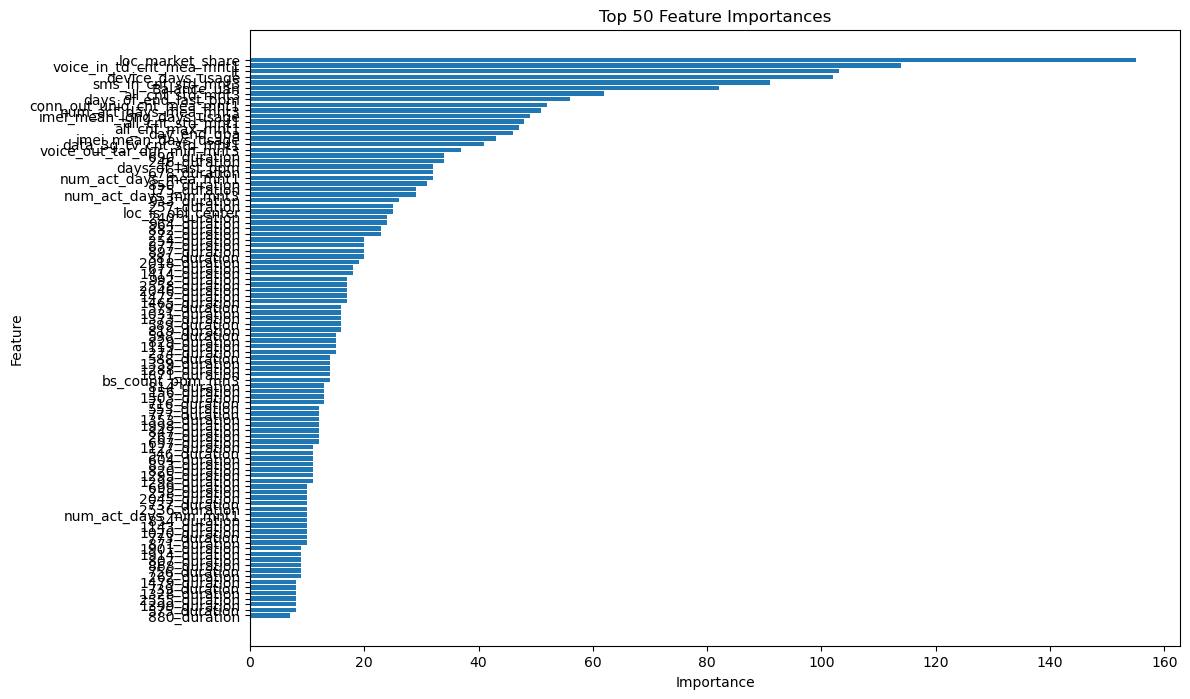

In [11]:
X = df_train_fe_25.drop(columns=['target'])
y = df_train_fe_25['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


model = lgb.LGBMClassifier(objective='binary', is_unbalance=True, boosting_type='gbdt', verbosity=-1)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

importance = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

feature_importance_df_25 = feature_importance_df.sort_values(by='Importance', ascending=False)
top_50_features = feature_importance_df_25.head(100)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(top_50_features)

plt.figure(figsize=(12, 8))
plt.barh(top_50_features['Feature'], top_50_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 50 Feature Importances')
plt.gca().invert_yaxis()
plt.show()


In [12]:
top_40_features_25 = feature_importance_df.head(40)['Feature'].values
df_train_fe_25_40 = df_train_fe_25[top_40_features_25]

In [16]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '454 +3000 DPI BNUM'  
results.append(result)

results_df = pd.DataFrame(results)
results_df

,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.945211,0.900066,0.045145,0.798966,2.610608,5.26237,0.993379,454 +3000 DPI BNUM


                        Feature  Importance
2              loc_market_share         155
4      voice_in_td_cnt_mea_mnt1         114
7                            lt         103
1             device_days_usage         102
12          sms_in_cnt_std_mnt3          91
17                  Balance_uah          82
14             all_cnt_std_mnt3          62
15         days_of_end_last_ppm          56
22   conn_out_uniq_cnt_mea_mnt1          52
6         num_act_days_mea_mnt3          51
19    imei_mean_long_days_usage          49
23             all_cnt_std_mnt1          48
18             all_cnt_max_mnt1          47
9                   day_end_gba          46
20         imei_mean_days_usage          43
24      data_3g_tv_cnt_std_mnt1          41
16   voice_out_tar_dur_min_mnt3          37
219                690_duration          34
78                 246_duration          34
10             days_of_last_ppm          32
212                678_duration          32
3         num_act_days_mea_mnt1 

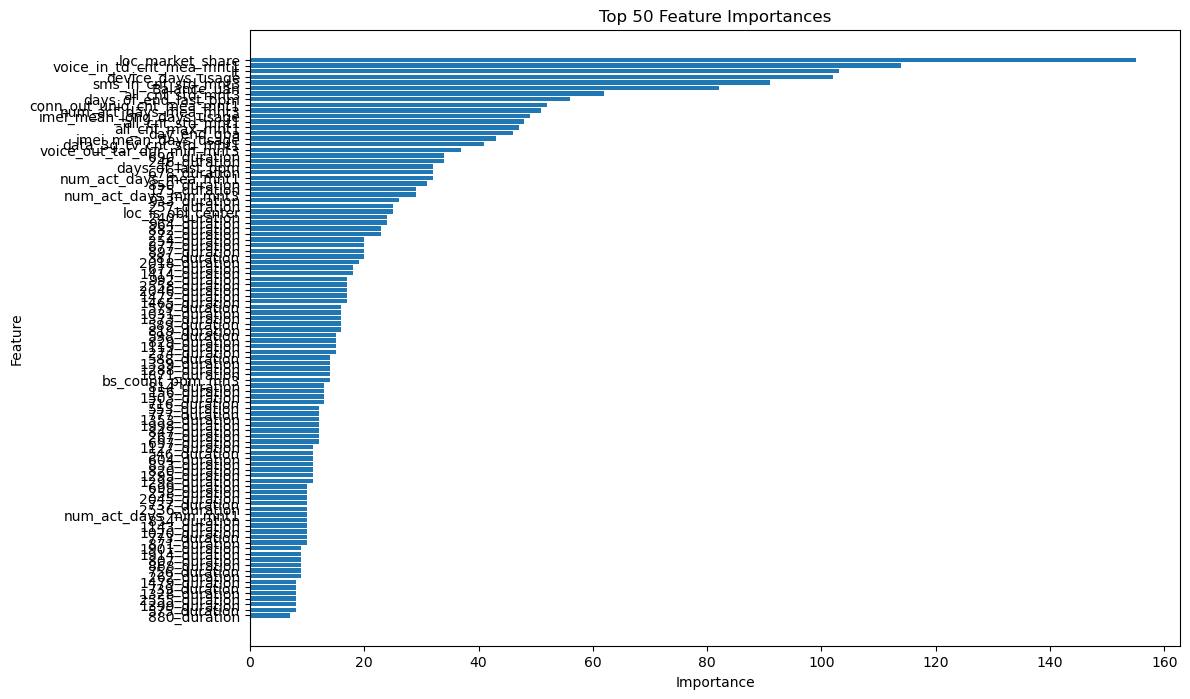

In [17]:
X = df_train_fe_241.drop(columns=['target'])
y = df_train_fe_241['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


model = lgb.LGBMClassifier(objective='binary', is_unbalance=True, boosting_type='gbdt', verbosity=-1)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

importance = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

feature_importance_df_241 = feature_importance_df.sort_values(by='Importance', ascending=False)
top_50_features_241 = feature_importance_df_241.head(50)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(top_50_features)

plt.figure(figsize=(12, 8))
plt.barh(top_50_features['Feature'], top_50_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 50 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [18]:
top_40_features_241 = feature_importance_df_241.head(40)['Feature'].values

df_train_fe_241_40 = df_train_fe_241[top_40_features_241]

In [19]:
model = lgb.LGBMClassifier(verbose=-1, random_state=42, is_unbalance=True)    

results = []
result = train_and_evaluate(model, X_train, X_val, y_train, y_val, model)
result['dataset'] = '454 +3000 DPI BNUM'  
results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', mode='a', header=not os.path.exists('model_results.csv'), index=False)
print("Results have been saved to model_results.csv")

results_df

Results have been saved to model_results.csv


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,train_time,val_time,dataset
0,0.955,0.90247,0.052531,0.787597,2.465223,11.268185,1.347088,454 +3000 DPI BNUM


In [20]:
top_40_features_df = feature_importance_df_25.head(40)
top_40_features_df.to_csv('top_40_features.csv', index=False)
print("Top 40 features have been saved to top_40_features.csv")

Top 40 features have been saved to top_40_features.csv


In [22]:
top_40_features_df = pd.read_csv('top_40_features.csv')
top_40_features_df

,Feature,Importance
0,loc_market_share,155
1,voice_in_td_cnt_mea_mnt1,114
2,lt,103
3,device_days_usage,102
4,sms_in_cnt_std_mnt3,91
5,Balance_uah,82
6,all_cnt_std_mnt3,62
7,days_of_end_last_ppm,56
8,conn_out_uniq_cnt_mea_mnt1,52
9,num_act_days_mea_mnt3,51
